<a href="https://colab.research.google.com/github/andersonsam/bc_heat_wave/blob/main/BC_heat_dome.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Preamble

Glaciated:  
BRIDGE RIVER (SOUTH BRANCH) BELOW BRIDGE GLACIER (08ME023)  
HOMATHKO RIVER AT THE MOUTH (08GD004)  
NORTH SASKATCHEWAN RIVER AT WHIRLPOOL POINT (05DA009)  

Snowy, then depleted:  
CHILLIWACK RIVER ABOVE SLESSE CREEK (08MH103)   
FINLAY RIVER ABOVE AKIE RIVER (07EA005)  
SKEENA RIVER AT USK (08EF001)  

Snowy, but already (or mostly) depleted:  
ELK RIVER AT FERNIE (08NK002)  
SALMO RIVER NEAR SALMO (08NE074)  
OYSTER RIVER BELOW WOODHUS CREEK (08HD011)  

Alberta -- Similar place, different response:  
ATHABASCA RIVER NEAR JASPER  
MIETTE RIVER NEAR JASPER  

Alberta -- Same river, different place:  
BOW RIVER AT LAKE LOUISE  
BOW RIVER AT BANFF  


In [1]:
dir_data = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/data' #where to store data
dir_data_realtime = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/data/temporary' #where to store data
!pip install geopandas

     |████████████████████████████████| 1.0 MB 13.5 MB/s 
     |████████████████████████████████| 16.7 MB 47.5 MB/s 
     |████████████████████████████████| 6.3 MB 35.0 MB/s 


In [2]:
#import required libraries

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import pickle

from datetime import datetime, date, timedelta
from google.colab import drive
from shapely.geometry import Point, Polygon

In [3]:
#mount google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#define functions

def nse(y_obs, y_model):

  """
  Calculates the Nash-Sutcliffe Efficiency (NSE), evaluated between simulated and observed streamflow.

  Use: NSE = nse(y_obs, y_model)

  y_obs, y_model --> these are arrays of the same length (1 x N or N x 1) where N is the number of observations in time
  """

  if not isinstance(y_obs, np.ndarray): #if tensor (or not array), convert to numpy array
    y_obs = np.array(y_obs)
  if not isinstance(y_model, np.ndarray):
    y_model = np.array(y_model)

  y_model = y_model.reshape((-1,1)) #make sure model and obs have same shape
  y_obs = y_obs.reshape((-1,1))

  nse = 1 - np.sum((y_model - y_obs)**2) / np.sum((y_obs - np.mean(y_obs))**2) #calculate NSE

  return nse

def plot_prov_ax(prov, ax):

  """
  plot borders of a province on a given axis

  prov: list of strings of provincial abbreviations; ['AB'], ['BC'], ['AB','BC'], etc; prov = 'all' will plot all provincial/territorial borders
  ax: axis on which to plot the provincial borders

  Examples:

  fig, ax = plt.subplots()
  plot_prov_ax(prov = ['BC', 'AB', 'SK'], ax = ax) #plots British Colubmia, Alberta, and Saskatchewan

  fig, ax = plt.subplots()
  plot_prov_ax(prov = 'all', ax = ax) #plots all provincial/territorial borders
  """

  #load shapefile of provincial boundaries
  provshapes_filename = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/data/PROVINCE.SHP'
  provshapes = gpd.read_file(provshapes_filename)

  #create list of all prov/territorial abbreviations
  prov_abbreviations = [
                        'AB',
                        'SK',
                        'MB',
                        'NL',
                        'PE',
                        'NS',
                        'NT',
                        'NU',
                        'ON',
                        'NB',
                        'YT',
                        'BC',
                        'QC'
                      ]

  #if wanting to plot all borders
  if prov == 'all':
    prov = prov_abbreviations

  #loop through each input province/territory and plot borders
  for pv in prov:

    #polygons of this province/territory
    prov_poly = provshapes['geometry'][prov_abbreviations.index(pv)]

    #some jurisdictions have multiple polygones from lakes/islands/etc (e.g. BC)
    if len(np.shape(prov_poly)) == 0: #if only one polygon to plot

      lonBorder,latBorder = prov_poly.exterior.coords.xy 
      ax.plot(lonBorder,latBorder,'k')

    else: #if multiply polygons in shape to plot

      for ind in range(len(prov_poly)): 
        lonBorder_segment,latBorder_segment = prov_poly[ind].exterior.coords.xy 
        ax.plot(lonBorder_segment,latBorder_segment,'k')

def plot_prov_ax(prov, ax, linewidth = 1):

  """
  plot borders of a province on a given axis

  prov: list of strings of provincial abbreviations; ['AB'], ['BC'], ['AB','BC'], etc; prov = 'all' will plot all provincial/territorial borders
  ax: axis on which to plot the provincial borders

  Examples:

  fig, ax = plt.subplots()
  plot_prov_ax(prov = ['BC', 'AB', 'SK'], ax = ax) #plots British Colubmia, Alberta, and Saskatchewan

  fig, ax = plt.subplots()
  plot_prov_ax(prov = 'all', ax = ax) #plots all provincial/territorial borders
  """

  #load shapefile of provincial boundaries
  provshapes_filename = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/data/PROVINCE.SHP'
  provshapes = gpd.read_file(provshapes_filename)

  #create list of all prov/territorial abbreviations
  prov_abbreviations = [
                        'AB',
                        'SK',
                        'MB',
                        'NL',
                        'PE',
                        'NS',
                        'NT',
                        'NU',
                        'ON',
                        'NB',
                        'YT',
                        'BC',
                        'QC'
                      ]

  #if wanting to plot all borders
  if prov == 'all':
    prov = prov_abbreviations

  #loop through each input province/territory and plot borders
  for pv in prov:

    #polygons of this province/territory
    prov_poly = provshapes['geometry'][prov_abbreviations.index(pv)]

    #some jurisdictions have multiple polygones from lakes/islands/etc (e.g. BC)
    if prov_poly.geom_type == 'Polygon': #if only one polygon to plot

      lonBorder,latBorder = prov_poly.exterior.coords.xy 
      ax.plot(lonBorder,latBorder,'k', linewidth = linewidth)

    else: #if multiply polygons in shape to plot

      for ind in range(len(prov_poly.geoms)): 
        lonBorder_segment,latBorder_segment = prov_poly.geoms[ind].exterior.coords.xy 
        ax.plot(lonBorder_segment,latBorder_segment,'k', linewidth = linewidth)

# Flow data

In [5]:
#load data

prov = ['BC','AB'] #for plotting -- plot_prov_ax(prov = prov, ax = ax)
flowpickle = ['BC_flowvars_1979_2015_missing_40_40_1.pickle', 'AB_flowvars_1979_2015_missing_40_40_1.pickle'] #filenames of .pickle files which contain AB/BC streamflow data

basinspickle = 'WSC_basins_1979_2015_missing_40_40_1.pickle'

#open flow data; since flow data is provided at provincial level, loop through/open/concatenate data from desired provinces
flowDicts = []
for flowfile in flowpickle:
  pickle_in = open(dir_data + '/' + flowfile,'rb')
  flowDicts.append(pickle.load(pickle_in))

#store flow data as a dictionary
flowDict = {
    'stationID' : np.hstack((flowDicts[0]['stationID'],flowDicts[1]['stationID'])), #station ID numbers
    'stationName' : np.hstack((flowDicts[0]['stationName'],flowDicts[1]['stationName'])), #station names
    'stationLat' : np.hstack((flowDicts[0]['stationLat'],flowDicts[1]['stationLat'])), #latitude of each station, in degrees
    'stationLon' : np.hstack((flowDicts[0]['stationLon'],flowDicts[1]['stationLon'])), #longitude of each station, in degrees
    'stationDrainageArea' : np.hstack((flowDicts[0]['stationDrainageArea'],flowDicts[1]['stationDrainageArea'])), #drainage area of each station
    'all_flowseason' : np.vstack((flowDicts[0]['all_flowseason'],flowDicts[1]['all_flowseason'])), #seasonal flow of each station, as evaluated across all years
    'all_flowseason_NF' : np.vstack((flowDicts[0]['all_flowseason_NF'],flowDicts[1]['all_flowseason_NF'])), #seasonal flow of each station, but with missing data filled with minimum value
    'all_flow' : np.vstack((flowDicts[0]['all_flow'],flowDicts[1]['all_flow'])), #daily flow data for each station
    'all_flow_NF' : np.vstack((flowDicts[0]['all_flow_NF'], flowDicts[1]['all_flow_NF'])), #daily flow data for each station, with missing data filled by seasonal value of the missing day
    'windowDates' : flowDicts[0]['windowDates'], #dates within window ("window" refers to time period of interest; here: 1979 - 2015)
    'windowYears' : flowDicts[0]['windowYears'], #years of each day within window
    'windowMonths' : flowDicts[0]['windowMonths'], #months of each day within window
    'windowDays' : flowDicts[0]['windowDays'], #day of month of each day within window
}

#unpack data
stationLat = flowDict['stationLat']
stationLon = flowDict['stationLon']
stationIDs_all = flowDict['stationID']
stationNames = flowDict['stationName']

flowDays = flowDict['windowDays']
flowMonths = flowDict['windowMonths']
flowYears = flowDict['windowYears']

F = flowDict['all_flow_NF'] 

#load basin data
pickle_in = open(dir_data + '/' + basinspickle, 'rb')
stationBasins = pickle.load(pickle_in)

In [6]:
stationIDs = [
              '08ME023',
              '08GD004',
              '05DA009',
              '08MH103',
              '07EA005',
              '08EF001',
              '08NK002',
              '08NE074',
              '08HD011'
]

stationIDs = [
              '08ME023',
              '08GD004',
              '05DA009',
              '08MH103',
              '08KB001',
              '08EF001',
              '08NK002',
              '08NE074',
              '08HD011'
]

stationInds = np.array([int(np.argwhere(stationIDs_all == stationID).squeeze()) for stationID in stationIDs])
classes = [0,0,0,1,1,1,2,2,2]

filenames = [stationID + '_QR_Oct-11-2021.csv' for stationID in stationIDs]

date_inds = np.argwhere(
    (flowMonths == 5) |
    (flowMonths == 6) |
    (flowMonths == 7) |
    (flowMonths == 8) |
    (flowMonths == 9)
).squeeze()

# date_inds = np.argwhere(
#     (flowMonths == 5) |
#     (flowMonths == 6) |
#     (flowMonths == 7) |
#     (flowMonths == 8)
# ).squeeze()

stationBasins = [stationBasins[stationInd] for stationInd in stationInds]

In [7]:
from netCDF4 import Dataset

In [ ]:
#SWE data

#open netcdf file
filenameERA = '/ERA5land_SWE_2021_hourly_01_grid_AB_BC.nc'
# filenameERA = 'adaptor.mars.internal-1641406346.1239731-18004-12-6e45c83b-7b70-40a2-afda-ba88b0a6d71d.nc'
filePathERA = dir_data + filenameERA
ERA = Dataset(filePathERA)

#extract data from file
lonERA = ERA.variables['longitude'][:] #longitude in degrees W 
latERA = ERA.variables['latitude'][:]
hoursERA = ERA.variables['time'][:] #hours since Jan 1, 1900
swe_hourly = ERA.variables['sd'][:] #snow water equivalent, in m

#convert hourly data to daily averages
timestamps_per_day = 24
swe = []
for daynum in range(int(len(hoursERA)/timestamps_per_day)): #for each day
  inds = list(range(daynum*timestamps_per_day,daynum*timestamps_per_day+timestamps_per_day))
  swe.append(np.mean(swe_hourly[inds,:,:],axis=0))

# initDate = [2021,1,1]
# finDate = [2021,12,31]
# years,months,days,dayInds = get_betweenDates(initDate,finDate)

swe = np.asarray(swe)

sweDict = {
  'SWE':swe,
  'lonERA':lonERA,
  'latERA':latERA,    
}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  


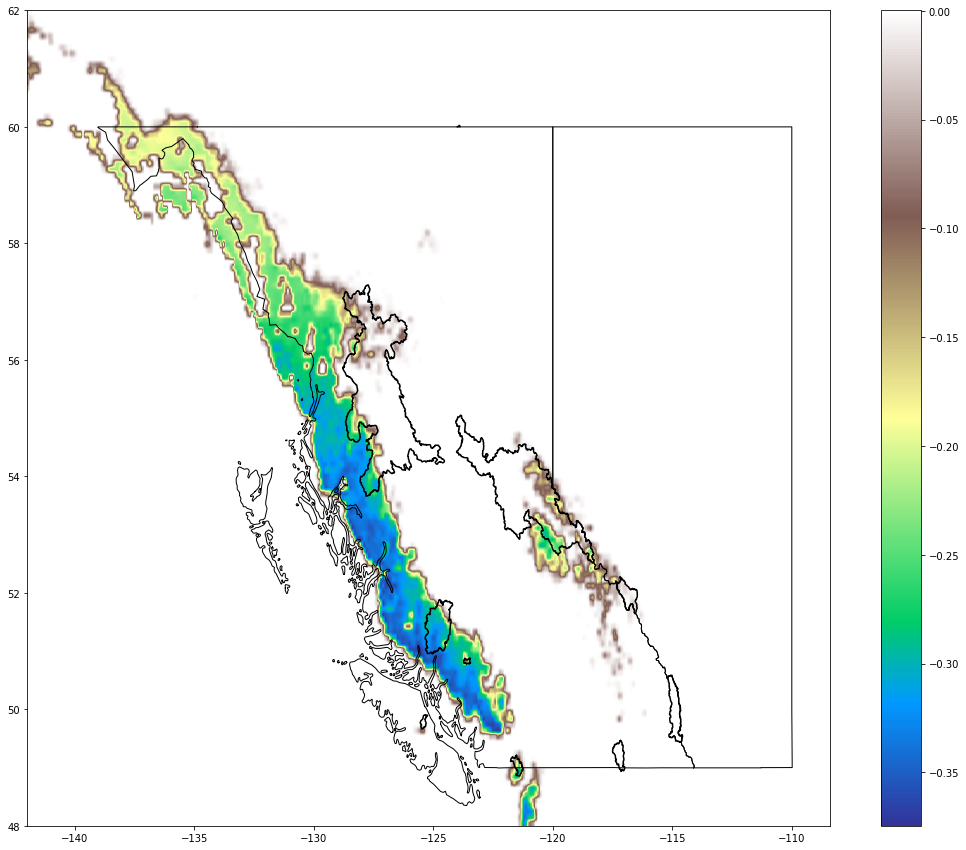

In [ ]:
swe_mean = np.mean(swe, axis = 0)

swe_pre = swe[175]
# swe_pre = swe[210]
swe_post = swe[182]
swe_diff = - swe_post + swe_pre
swe_diff = swe_post - swe_pre
var = np.log(swe_diff)
var = swe_diff

cmap = 'Blues_r'
cmap = 'terrain'
extent_swe = [-142,-110,48,62]

fig, ax = plt.subplots(figsize = (18,15))
im = ax.imshow(var, aspect = 'auto', cmap = cmap, extent = extent_swe)
plot_prov_ax(prov,ax)
# s = ax.scatter(stationLon[stationInds], stationLat[stationInds], c = classes, zOrder = 5, s = 100, edgecolor = 'k', linewidth = 1)

for kk, basin in enumerate(stationBasins):
  xx,yy = basin.exterior.xy
  ax.plot(xx,yy, color = 'k')

plt.colorbar(im)


In [ ]:
#open RGI data and extract area/locations

rgi_dir = dir_data + '/RGI/'

poly_filename = '02_rgi60_WesternCanadaUS.shp'
polys = gpd.read_file(rgi_dir + poly_filename)
cenLon = polys['CenLon']
cenLat = polys['CenLat']
area = polys['Area']

#for each basin, determine which glaciers are within its watershed boundaries

glacier_points = [Point(lon, lat) for lon, lat in zip(cenLon, cenLat)]
glacier_area_in = np.zeros(len(stationInds))
area_glaciers_in = np.zeros(len(stationInds))
glaciers_in_inds_all = [[] for kk in range(len(stationInds))]

for jj, basin in enumerate(stationBasins): #for each basin, determine which glaciers are within basin boundaries

  if basin is not None: #if basin outline exists (a few small non-glaciated basins do not have outlines)

    glaciers_in = np.zeros(len(cenLon)) #will be binary list of all glaciers: 1 == glacier in this basin, 0 == glacier not in this basin

    for kk, point in enumerate(glacier_points): #for each glacier, determine if within basin boundaries
        glaciers_in[kk] = basin.contains(point)

    glaciers_in_inds = np.squeeze(np.argwhere(glaciers_in))
    area_glaciers_in[jj] = np.sum(area[glaciers_in_inds]) #total area of glaciers which are within the watershed boundaries (in paper: A_glaciers)
    glaciers_in_inds_all[jj] = glaciers_in_inds

#calcualte percentage glaciation (in paper: G = A_glaciers / A_basin)
stationArea = np.array([float(flowDict['stationDrainageArea'][stationInds][kk][1:]) for kk in range(len(stationInds))]) #(in paper: A_basin)
stationPG = area_glaciers_in / stationArea #(in paper: G)

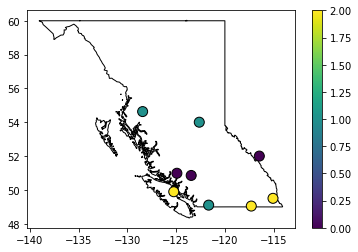

In [ ]:
fig, ax = plt.subplots()
plot_prov_ax(prov = ['BC'], ax = ax)
s = ax.scatter(stationLon[stationInds], stationLat[stationInds], c = classes, zOrder = 5, s = 100, edgecolor = 'k', linewidth = 1)
plt.colorbar(s)

In [ ]:
#calculate historical flows

Ndays = 153
# Ndays = 123
Nstations = len(stationInds)

flow_mean = np.zeros((Nstations, Ndays))
flow_median = np.zeros((Nstations, Ndays))
flow_std = np.zeros((Nstations, Ndays))
flow_q1 = np.zeros((Nstations, Ndays))#np.percentile(flow_mat, 25, axis = 0)
flow_q3 = np.zeros((Nstations, Ndays))#np.percentile(flow_mat, 75, axis = 0)

p1 = 16
p3 = 84

for kk, station in enumerate(stationInds):

  flow_hist = F[station,:]
  flow_mat = flow_hist[date_inds].reshape(-1,Ndays)
  flow_mean[kk,:] = np.mean(flow_mat, axis = 0)
  flow_median[kk,:] = np.median(flow_mat, axis = 0)
  flow_std[kk,:] = np.std(flow_mat, axis = 0)
  flow_q1[kk,:] = np.percentile(flow_mat, p1, axis = 0)
  flow_q3[kk,:] = np.percentile(flow_mat, p3, axis = 0)

In [ ]:
#calculate 2021 flows

flow_daily = np.zeros((Nstations, Ndays))

for station in range(Nstations):
  df = pd.read_csv(dir_data_realtime + '/' + filenames[station], header = 7)
  flow_realtime = df['Value (m3/s)']
  date_flow = [dd[:10] for dd in df[df.columns[0]]]
  datetimes = []
  for day in range(Ndays):
    datetimes.append(datetime(year = 2021, month = 5, day = 1) + timedelta(days = day))
    ds = str(datetime(year = 2021, month = 5, day = 1) + timedelta(days = day))[:10]
    inds = np.array([ii for ii, ee in enumerate(date_flow) if ee == ds])
    flow_daily[station,day] = np.nanmean(flow_realtime[inds])

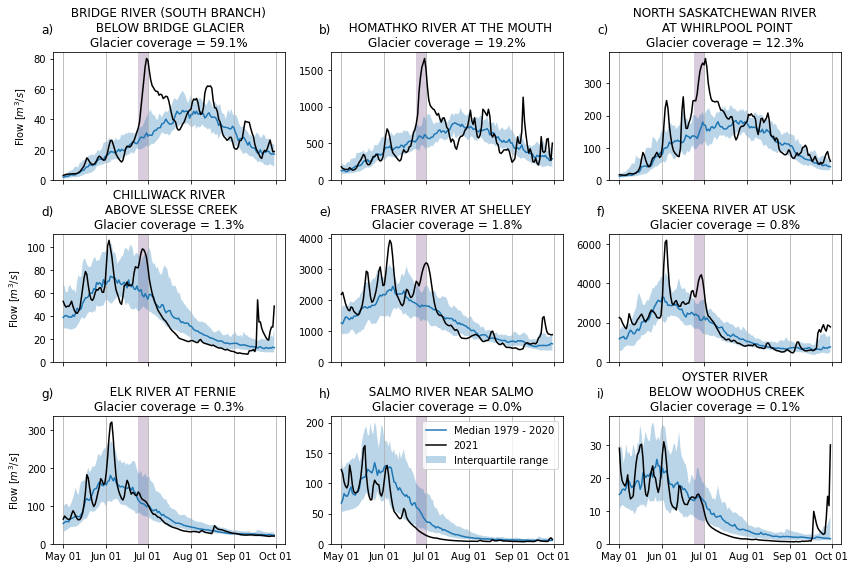

In [ ]:
#visualize

fs = 12

saveIt = 1

abcs = ['a)','b)','c)','d)','e)','f)','g)','h)','i)']

heat_start = 55
heat_fin = heat_start+7
heat_start = datetime(year = 2021, month = 6, day = 24)
heat_fin = heat_start + timedelta(days = 7)
heat_shade = np.ones((1,1))

fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (12,8))

for station, ax in enumerate(axes.flatten()):

  y1 = flow_q1[station,:]
  y2 = flow_q3[station,:]

  bottom = 0
  top = np.max([flow_daily[station,:], y2])*1.05

  #heat
  extent_heat = [mdates.date2num(heat_start), mdates.date2num(heat_fin), top, bottom]
  ax.imshow(heat_shade, extent = extent_heat, alpha = 0.2, aspect = 'auto', label = 'Heat wave')

  #flow
  ax.fill_between(x = datetimes, y1 = y1, y2 = y2, alpha = 0.3, label = 'Interquartile range')
  ax.plot(datetimes, flow_median[station,:], label  = 'Median 1979 - 2020')
  ax.plot(datetimes, flow_daily[station,:], 'k', label = '2021')

  #format
  ax.set_ylim(bottom = bottom, top = top)
  ax.set_xticks(ax.get_xticks())#[::2])  
  monthFormatter = DateFormatter('%b %d')
  ax.xaxis.set_major_formatter(monthFormatter)
  ax.xaxis_date()
  if station % 3 == 0:
    ax.set_ylabel('Flow [$m^3/s$]')

  title_breaks = [5,0,4,3,0,0,0,0,3]
  # if (station == 0) or (station == 2):
  a = stationNames[stationInds[station]].split(' ')
  newtitle = a[:title_breaks[station]] + ['\n'] + a[title_breaks[station]:]
  ax.set_title(' '.join(newtitle) + '\nGlacier coverage = ' + str(np.round(stationPG[station]*100, decimals = 1)) + '%')
  # else:
  #   ax.set_title(stationNames[stationInds[station]] + '\nGlacier coverage = ' + str(np.round(stationPG[station]*100, decimals = 1)) + '%')

  if station == 7:
    ax.legend()
  if station < 6:
    ax.set_xticklabels([])
  ax.grid(True, axis = 'x')
  ax.text(x = -0.05, y = 1.15, s = abcs[station], transform = ax.transAxes, fontsize = fs)

plt.tight_layout(h_pad = 0.2)

if saveIt:
  plt.savefig('heat_wave_flows.png', dpi = 300, bbox_inches = 'tight')

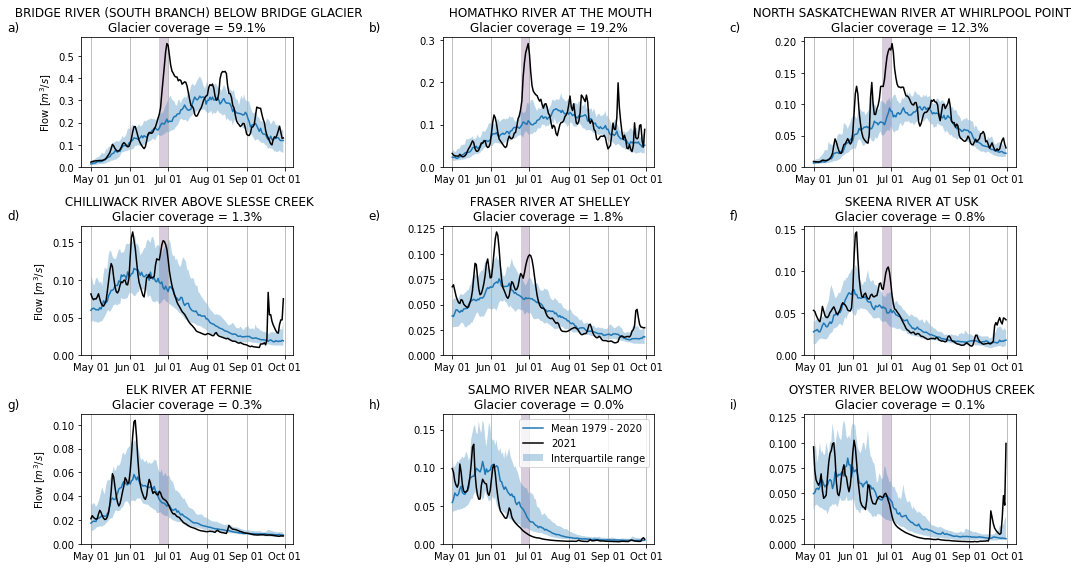

In [ ]:
#visualize: in mm/day rather than m^3/day

saveIt = 0

abcs = ['a)','b)','c)','d)','e)','f)','g)','h)','i)']

heat_start = 55
heat_fin = heat_start+7
heat_start = datetime(year = 2021, month = 6, day = 24)
heat_fin = heat_start + timedelta(days = 7)
heat_shade = np.ones((1,1))

fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (15,8))

for station, ax in enumerate(axes.flatten()):

  y1 = flow_q1[station,:] / stationArea[station]
  y2 = flow_q3[station,:] / stationArea[station]

  bottom = 0
  top = np.max([flow_daily[station,:] / stationArea[station], y2])*1.05

  #heat
  extent_heat = [mdates.date2num(heat_start), mdates.date2num(heat_fin), top, bottom]
  ax.imshow(heat_shade, extent = extent_heat, alpha = 0.2, aspect = 'auto', label = 'Heat wave')

  #flow
  ax.fill_between(x = datetimes, y1 = y1, y2 = y2, alpha = 0.3, label = 'Interquartile range')
  ax.plot(datetimes, flow_median[station,:] / stationArea[station], label  = 'Mean 1979 - 2020')
  ax.plot(datetimes, flow_daily[station,:] / stationArea[station], 'k', label = '2021')

  #format
  ax.set_ylim(bottom = bottom, top = top)
  ax.set_xticks(ax.get_xticks())#[::2])  
  monthFormatter = DateFormatter('%b %d')
  ax.xaxis.set_major_formatter(monthFormatter)
  ax.xaxis_date()
  if station % 3 == 0:
    ax.set_ylabel('Flow [$m^3/s$]')
  ax.set_title(stationNames[stationInds[station]] + '\nGlacier coverage = ' + str(np.round(stationPG[station]*100, decimals = 1)) + '%')
  if station == 7:
    ax.legend()
  ax.grid(True, axis = 'x')
  ax.text(x = -0.35, y = 1.05, s = abcs[station], transform = ax.transAxes, fontsize = fs)

plt.tight_layout()

if saveIt:
  plt.savefig('heat_wave_flows.png', dpi = 300, bbox_inches = 'tight')

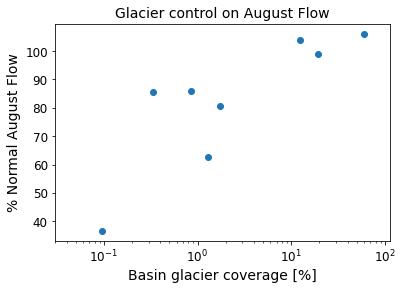

In [ ]:
saveIt = 0

fs = 14

ind_start = 75
ind_end = 135

flow_median_aug = np.sum(flow_median[:,ind_start:ind_end], axis = 1)
flow_2021_aug = np.sum(flow_daily[:,ind_start:ind_end], axis = 1)

aug_ratio = flow_2021_aug / flow_median_aug

fig, ax = plt.subplots()

ax.scatter(stationPG*100, aug_ratio*100)

ax.set_xscale('log')
ax.set_xlim(left = 0.0003*100)
ax.set_xlabel('Basin glacier coverage [%]', fontsize = fs)
ax.set_ylabel('% Normal August Flow', fontsize = fs)
ax.set_title('Glacier control on August Flow', fontsize = fs)
ax.tick_params(labelsize = fs-2)

if saveIt:
  plt.savefig('heat_wave_glacier_control_august.png', dpi = 300, bbox_inches = 'tight')

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:82: ShapelyDeprec

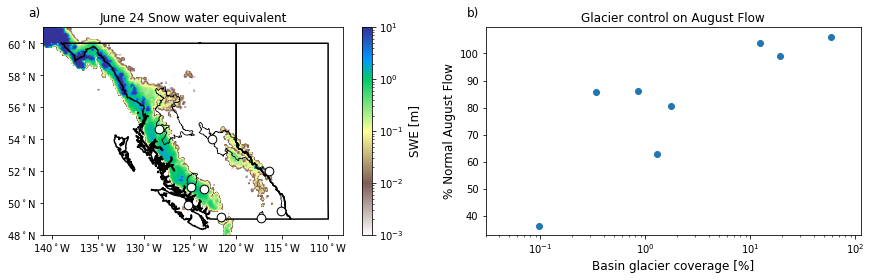

In [ ]:
saveIt = 1

fs = 12

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,4))

swe_pre = swe[174]
swe_post = swe[182]
swe_diff = - swe_post + swe_pre
swe_diff = swe_post - swe_pre
var = swe_pre

cmap = 'Blues'
cmap = 'terrain_r'
extent_swe = [-142,-110,48,62]

im = ax[0].imshow(var, aspect = 'auto', cmap = cmap, extent = extent_swe, norm=matplotlib.colors.LogNorm(), vmin = 10**-3)
plot_prov_ax(prov,ax[0])
s = ax[0].scatter(stationLon[stationInds], stationLat[stationInds], zOrder = 5, s = 75, edgecolor = 'k', linewidth = 1, facecolor = 'w')

for kk, basin in enumerate(stationBasins):
  xx,yy = basin.exterior.xy
  ax[0].plot(xx,yy, color = 'k', linewidth = 0.75)

ax[0].set_xlim(left = -141)
ax[0].set_ylim(top = 61)
ax[0].set_title('June 24 Snow water equivalent', fontsize = fs)

cb = plt.colorbar(im, ax = ax[0])
cb.ax.set_ylabel('SWE [m]', fontsize = fs)

# xlabels = [label.get_text() for label in ax.get_xticklabels()]
# xlabels[0] = 'hi'
# ax.set_xticklabels(xlabels)

# fig.tight_layout()

##### glacier figure

ind_start = 75
ind_end = 135

flow_median_aug = np.sum(flow_median[:,ind_start:ind_end], axis = 1)
flow_2021_aug = np.sum(flow_daily[:,ind_start:ind_end], axis = 1)

aug_ratio = flow_2021_aug / flow_median_aug

# fig, ax = plt.subplots()

ax[1].scatter(stationPG*100, aug_ratio*100)

ax[1].set_xscale('log')
ax[1].set_xlim(left = 0.0003*100)
ax[1].set_xlabel('Basin glacier coverage [%]', fontsize = fs)
ax[1].set_ylabel('% Normal August Flow', fontsize = fs)
ax[1].set_title('Glacier control on August Flow', fontsize = fs)
ax[1].tick_params(labelsize = fs-2)

for kk, aa in enumerate(ax):
  aa.text(x = -0.05, y = 1.05, s = abcs[kk], transform = aa.transAxes, fontsize = fs)

fig.tight_layout()

xtls = [item.get_text()[1:] + '$^\circ$W' for item in ax[0].get_xticklabels()]
ax[0].set_xticklabels(xtls, fontsize = 10)
ytls = [item.get_text() + '$^\circ$N' for item in ax[0].get_yticklabels()]
ax[0].set_yticklabels(ytls, fontsize = 10)

if saveIt:
  plt.savefig('heat_wave_swe_glaciers.png', dpi = 300, bbox_inches = 'tight')

plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:82: ShapelyDeprec

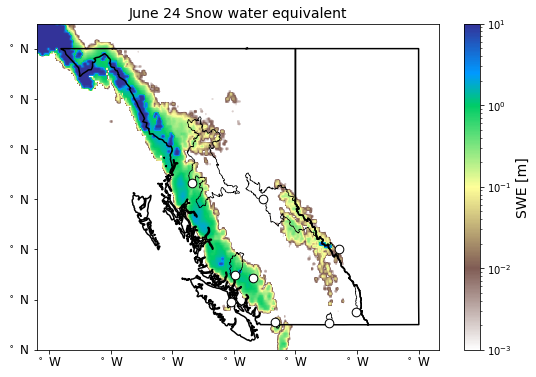

In [ ]:
saveIt = 0

fs = 14

swe_pre = swe[174]
swe_post = swe[182]
swe_diff = - swe_post + swe_pre
swe_diff = swe_post - swe_pre
var = swe_pre

cmap = 'Blues'
cmap = 'terrain_r'
extent_swe = [-142,-110,48,62]

fig, ax = plt.subplots(figsize = (9,6))
im = ax.imshow(var, aspect = 'auto', cmap = cmap, extent = extent_swe, norm=matplotlib.colors.LogNorm(), vmin = 10**-3)
plot_prov_ax(prov,ax)
s = ax.scatter(stationLon[stationInds], stationLat[stationInds], zOrder = 5, s = 75, edgecolor = 'k', linewidth = 1, facecolor = 'w')

for kk, basin in enumerate(stationBasins):
  xx,yy = basin.exterior.xy
  ax.plot(xx,yy, color = 'k', linewidth = 0.75)

ax.set_xlim(left = -141)
ax.set_ylim(top = 61)
ax.set_title('June 24 Snow water equivalent', fontsize = fs)

cb = plt.colorbar(im)
cb.ax.set_ylabel('SWE [m]', fontsize = fs)

# xlabels = [label.get_text() for label in ax.get_xticklabels()]
# xlabels[0] = 'hi'
# ax.set_xticklabels(xlabels)

# fig.tight_layout()

xtls = [item.get_text()[1:] + '$^\circ$ W' for item in ax.get_xticklabels()]
ax.set_xticklabels(xtls, fontsize = 12)
ytls = [item.get_text() + '$^\circ$ N' for item in ax.get_yticklabels()]
ax.set_yticklabels(ytls, fontsize = 12)

if saveIt:
  plt.savefig('heat_wave_swe.png', dpi = 300, bbox_inches = 'tight')

plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:82: ShapelyDeprec

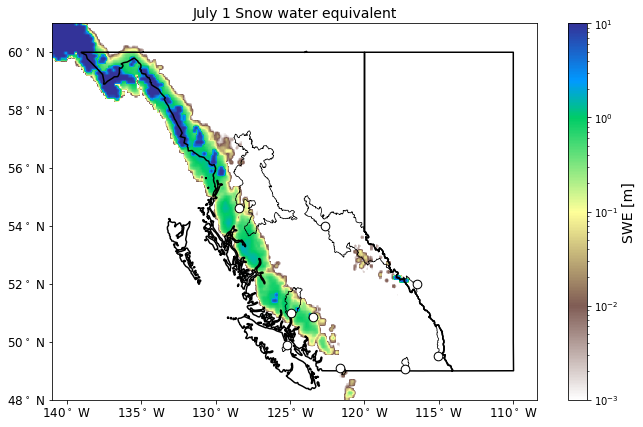

In [ ]:
saveIt = 0

fs = 14

swe_pre = swe[174]
swe_post = swe[182]
swe_diff = - swe_post + swe_pre
swe_diff = swe_post - swe_pre
var = swe_post

cmap = 'Blues'
cmap = 'terrain_r'
extent_swe = [-142,-110,48,62]

fig, ax = plt.subplots(figsize = (9,6))
im = ax.imshow(var, aspect = 'auto', cmap = cmap, extent = extent_swe, norm=matplotlib.colors.LogNorm(), vmin = 10**-3)
plot_prov_ax(prov,ax)
s = ax.scatter(stationLon[stationInds], stationLat[stationInds], zOrder = 5, s = 75, edgecolor = 'k', linewidth = 1, facecolor = 'w')

for kk, basin in enumerate(stationBasins):
  xx,yy = basin.exterior.xy
  ax.plot(xx,yy, color = 'k', linewidth = 0.75)

ax.set_xlim(left = -141)
ax.set_ylim(top = 61)
ax.set_title('July 1 Snow water equivalent', fontsize = fs)

cb = plt.colorbar(im)
cb.ax.set_ylabel('SWE [m]', fontsize = fs)

# xlabels = [label.get_text() for label in ax.get_xticklabels()]
# xlabels[0] = 'hi'
# ax.set_xticklabels(xlabels)

fig.tight_layout()

xtls = [item.get_text()[1:] + '$^\circ$ W' for item in ax.get_xticklabels()]
ax.set_xticklabels(xtls, fontsize = 12)
ytls = [item.get_text() + '$^\circ$ N' for item in ax.get_yticklabels()]
ax.set_yticklabels(ytls, fontsize = 12)

if saveIt:
  plt.savefig('heat_wave_swe.png', dpi = 300, bbox_inches = 'tight')

plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:82: ShapelyDeprec

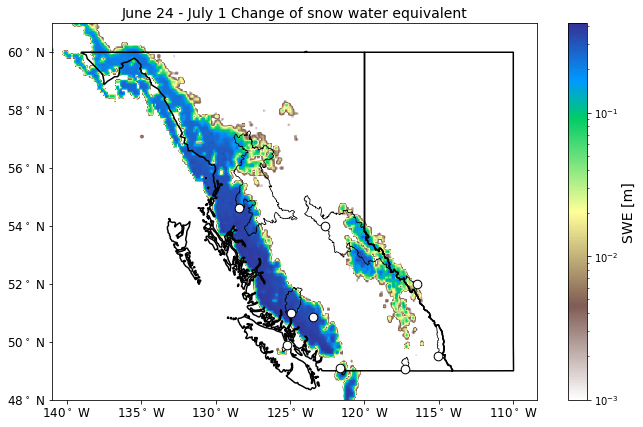

In [ ]:
saveIt = 0

fs = 14

swe_pre = swe[174]
swe_post = swe[182]
swe_diff = - swe_post + swe_pre
swe_diff = swe_post - swe_pre
var = -swe_diff

cmap = 'Blues'
cmap = 'terrain_r'
extent_swe = [-142,-110,48,62]

fig, ax = plt.subplots(figsize = (9,6))
im = ax.imshow(var, aspect = 'auto', cmap = cmap, extent = extent_swe, norm=matplotlib.colors.LogNorm(), vmin = 10**-3)
plot_prov_ax(prov,ax)
s = ax.scatter(stationLon[stationInds], stationLat[stationInds], zOrder = 5, s = 75, edgecolor = 'k', linewidth = 1, facecolor = 'w')

for kk, basin in enumerate(stationBasins):
  xx,yy = basin.exterior.xy
  ax.plot(xx,yy, color = 'k', linewidth = 0.75)

ax.set_xlim(left = -141)
ax.set_ylim(top = 61)
ax.set_title('June 24 - July 1 Change of snow water equivalent', fontsize = fs)

cb = plt.colorbar(im)
cb.ax.set_ylabel('SWE [m]', fontsize = fs)

# xlabels = [label.get_text() for label in ax.get_xticklabels()]
# xlabels[0] = 'hi'
# ax.set_xticklabels(xlabels)

fig.tight_layout()

xtls = [item.get_text()[1:] + '$^\circ$ W' for item in ax.get_xticklabels()]
ax.set_xticklabels(xtls, fontsize = 12)
ytls = [item.get_text() + '$^\circ$ N' for item in ax.get_yticklabels()]
ax.set_yticklabels(ytls, fontsize = 12)

if saveIt:
  plt.savefig('heat_wave_swe.png', dpi = 300, bbox_inches = 'tight')

plt.show()

In [ ]:
#initialize

Nlat_swe = len(latERA)
Nlon_swe = len(lonERA)
Npx = Nlat_swe*Nlon_swe

binary_in = np.zeros((Npx, Nstations))
inside_all_stations = [None] * Nstations
outside_all_stations = [None] * Nstations
radius = .25

x = lonERA #rename for readability when making xx and xxv
y = latERA
xx,yy = np.meshgrid(x,y)
xxv = xx.reshape(-1) #vector (array) where paired elements in xxv and yyv correspond to one pixel in heat map sensitivity space
yyv = yy.reshape(-1)

points = list(zip(xx.flatten(),yy.flatten())) #will loop through each point to see if sensitivity there is in/near or out/far from basins

#loop through each station and determine in/out points/sensitivity
for station in range(len(stationInds)):

  basin = stationBasins[station]
    
  # #determine basin outlines  
  # if basin is not None: #if basin polygon(s) exist -- some small basins do not have polygons from this source (see elif)
  #   xb,yb = basin.exterior.xy #lon/lat (x/y) points of watershed/basin boundary
  # elif basin is None: #if basin shapefile is missing, use stream gauge location w/ radius buffer to estimate in/near pixels (these are small basins)
  #   xb = stationLon[stationInds][station] #basin outline taken to be single point at stream gauge
  #   yb = stationLat[stationInds][station]
    
  #create binary in/near (True) vs out/far (False)
  inside = np.zeros(np.size(swe[0])) #initialize inside/outside array
  for ii, point in enumerate(points): #for each point/pixel in ERA5 space
    p = Point(point[0],point[1])
    inside[ii] = basin.contains(p)
    # d = np.sqrt((point[0] - xb)**2 + (point[1] - yb)**2) #distance from point in ERA5 to all points around basin
    # if np.min(d) <= radius: #if the nearest basin edge to current point in ERA5 is less than prescribed allowable radius
    #   inside[ii] = True #then this point in ERA5 is considered 'inside' (or near) this basin

  inside_this_station = np.squeeze(np.argwhere(inside==True)) #array of indices which are inside this station's basin
  outside_this_station = np.squeeze(np.argwhere(inside==False)) #array of indices which are outside this station's basin

  inside_all_stations[station] = inside_this_station #list of arrays of indices which are inside/near each stations' basin
  outside_all_stations[station] = outside_this_station #list of arrays of indices which are outside/far each stations' basin

unique_in_stations = inside_all_stations

#make binary mask in/out for each basin
mask_stations = np.zeros((Nlat_swe, Nlon_swe, Nstations))
inds_all = np.arange(Npx).reshape(Nlat_swe,Nlon_swe)
for station in range(Nstations):
  dummy = np.zeros(Npx)
  dummy[unique_in_stations[station]] = 1
  mask_stations[:,:,station] = dummy.reshape(Nlat_swe,Nlon_swe)

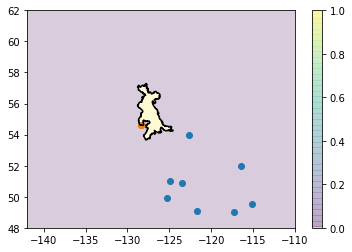

In [ ]:
kk = 5
fig, ax = plt.subplots()
im = ax.imshow(mask_stations[:,:,kk], aspect = 'auto', alpha = 0.2, extent = extent_swe)
ax.scatter(stationLon[stationInds], stationLat[stationInds])
ax.scatter(stationLon[stationInds][kk], stationLat[stationInds][kk])

xx,yy = stationBasins[kk].exterior.xy
ax.plot(xx,yy, 'k')
plt.colorbar(im)

In [ ]:
swe_diff_station = np.zeros(Nstations)
swe_diff_station_sum = np.zeros(Nstations)

for station in range(Nstations):

  #DJF
  swe_diff_station[station] = swe_diff[mask_stations[:,:,station]==1].mean()#(axis = 1)
  swe_diff_station_sum[station] = swe_diff[mask_stations[:,:,station]==1].sum()

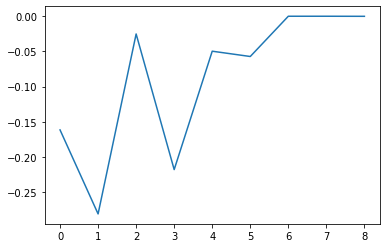

In [ ]:
plt.plot(swe_diff_station)

In [ ]:
may1 = 121
flow_diff = np.max(flow_daily[:,174-may1:182-may1], axis = 1) - flow_daily[:,174-may1]
flow_diff_norm = flow_diff / stationArea

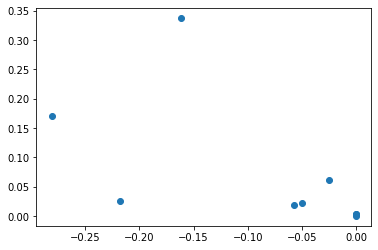

In [ ]:
plt.scatter(swe_diff_station, flow_diff_norm)


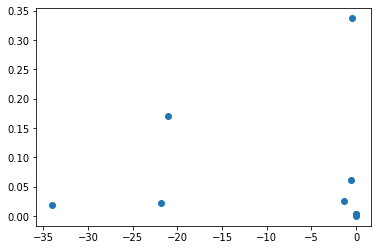

In [ ]:
plt.scatter(swe_diff_station_sum, flow_diff_norm)

In [ ]:
flow_diff[0], swe_diff_station[0], swe_diff_station_sum[0]

(48.51006944444444, -0.16161704789953238, -0.48485114369859716)

# Temp data

In [ ]:
df = pd.read_csv(dir_data_realtime + '/stations_T2m_era.csv')
date_temp = df['date']

In [ ]:
#calculate 2021 temp

temp_daily = np.zeros((Nstations, Ndays))

for station in range(Nstations):
  temp_realtime = df[stationIDs[station]]
  date_temp = [dd[:10] for dd in df[df.columns[1]]]
  datetimes = []
  for day in range(Ndays):
    datetimes.append(datetime(year = 2021, month = 5, day = 1) + timedelta(days = day))
    ds = str(datetime(year = 2021, month = 5, day = 1) + timedelta(days = day))[:10]
    inds = np.array([ii for ii, ee in enumerate(date_temp) if ee == ds])
    temp_daily[station,day] = np.nanmean(temp_realtime[inds])

In [ ]:
len(df.columns[2:])

9

In [ ]:
df = pd.read_csv(dir_data_realtime + '/stations_T2m_eraland.csv')
temp_date = df['date']
temp_months = np.array([int(dd[5:7]) for dd in temp_date])[:-212]
T = df[df.columns[2:]].values
T = T[:-121,:]

date_inds = np.argwhere(
    (temp_months == 5) |
    (temp_months == 6) |
    (temp_months == 7) |
    (temp_months == 8)
).squeeze()

In [ ]:
#calculate historical flows

Ndays = 153
Ndays = 123
Nstations = len(stationInds)

temp_mean = np.zeros((Nstations, Ndays))
temp_median = np.zeros((Nstations, Ndays))
temp_std = np.zeros((Nstations, Ndays))

for kk, station in enumerate(stationInds):

  temp_hist = T[:,kk]
  temp_mat = temp_hist[date_inds].reshape(-1,Ndays)
  temp_mean[kk,:] = np.mean(temp_mat, axis = 0)
  temp_median[kk,:] = np.median(temp_mat, axis = 0)
  temp_std[kk,:] = np.std(temp_mat, axis = 0)

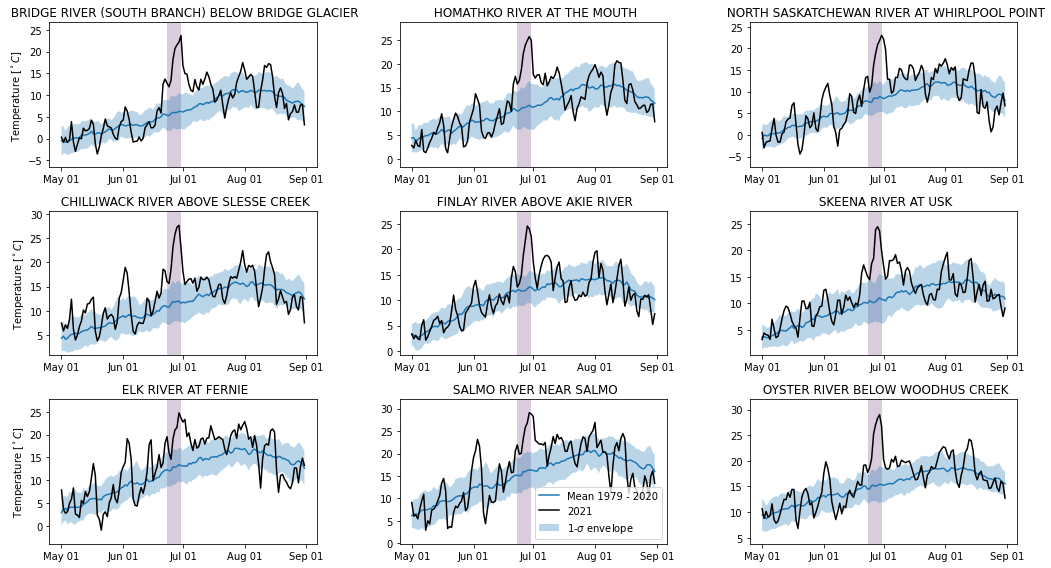

In [ ]:
#visualize

saveIt = 0

heat_start = 55
heat_fin = heat_start+7
heat_start = datetime(year = 2021, month = 6, day = 23)
heat_fin = heat_start + timedelta(days = 7)
heat_shade = np.ones((1,1))

fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (15,8))

for station, ax in enumerate(axes.flatten()):

  y1 = temp_mean[station,:] + temp_std[station,:] - 273
  y2 = temp_mean[station,:] - temp_std[station,:] - 273

  bottom = np.min([temp_daily[station,:] - 273, y1]) - 3 
  top = np.max([temp_daily[station,:] - 273, y1]) + 3 

  extent_heat = [mdates.date2num(heat_start), mdates.date2num(heat_fin), top, bottom]
  ax.imshow(heat_shade, extent = extent_heat, alpha = 0.2, aspect = 'auto', label = 'Heat wave')

  ax.fill_between(x = datetimes, y1 = y1, y2 = y2, alpha = 0.3, label = '1-$\sigma$ envelope')
  ax.plot(datetimes, temp_mean[station,:] - 273, label  = 'Mean 1979 - 2020')

  ax.plot(datetimes, temp_daily[station,:] - 273, 'k', label = '2021')

  ax.set_ylim(bottom = bottom, top = top)

  ax.set_xticks(ax.get_xticks()[::2])  
  monthFormatter = DateFormatter('%b %d')
  ax.xaxis.set_major_formatter(monthFormatter)
  ax.xaxis_date()

  if station % 3 == 0:
    ax.set_ylabel('Temperature [$^\circ C$]')

  ax.set_title(stationNames[stationInds[station]])  
  if station == 7:
    ax.legend()

plt.tight_layout()

if saveIt:
  plt.savefig('heat_wave_temps.png', dpi = 300, bbox_inches = 'tight')

# Prep data

In [5]:
!pip install rasterio
!pip install guppy3
import rasterio
from guppy import hpy

     |████████████████████████████████| 19.3 MB 5.9 MB/s 
     |████████████████████████████████| 611 kB 13.3 MB/s 


In [6]:
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, TimeDistributed, LSTM, Dense, Dropout, GlobalMaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping

from shapely.geometry import Point, Polygon
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering, KMeans

In [7]:
dir_models = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/models' #where to save trained models
dir_output = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/output' #where to save trained model outputs
dir_data_temp = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/data/temporary'

In [8]:
#load data

prov = ['British Columbia', 'Alberta'] #for plotting -- plot_prov_ax(prov = prov, ax = ax)
prov = ['AB','BC']
flowpickle = ['BC_flowvars_1979_2015_missing_40_40_1.pickle', 'AB_flowvars_1979_2015_missing_40_40_1.pickle'] #filenames of .pickle files which contain AB/BC streamflow data
basinspickle = 'WSC_basins_1979_2015_missing_40_40_1.pickle' #filename of pickle file which contains the basin outlines

#open flow data; since flow data is provided at provincial level, loop through/open/concatenate data from desired provinces
flowDicts = []
for flowfile in flowpickle:
  pickle_in = open(dir_data + '/' + flowfile,'rb')
  flowDicts.append(pickle.load(pickle_in))

#store flow data as a dictionary
flowDict = {
    'stationID' : np.hstack((flowDicts[0]['stationID'],flowDicts[1]['stationID'])), #station ID numbers
    'stationName' : np.hstack((flowDicts[0]['stationName'],flowDicts[1]['stationName'])), #station names
    'stationLat' : np.hstack((flowDicts[0]['stationLat'],flowDicts[1]['stationLat'])), #latitude of each station, in degrees
    'stationLon' : np.hstack((flowDicts[0]['stationLon'],flowDicts[1]['stationLon'])), #longitude of each station, in degrees
    'stationDrainageArea' : np.hstack((flowDicts[0]['stationDrainageArea'],flowDicts[1]['stationDrainageArea'])), #drainage area of each station
    'all_flowseason' : np.vstack((flowDicts[0]['all_flowseason'],flowDicts[1]['all_flowseason'])), #seasonal flow of each station, as evaluated across all years
    'all_flowseason_NF' : np.vstack((flowDicts[0]['all_flowseason_NF'],flowDicts[1]['all_flowseason_NF'])), #seasonal flow of each station, but with missing data filled with minimum value
    'all_flow' : np.vstack((flowDicts[0]['all_flow'],flowDicts[1]['all_flow'])), #daily flow data for each station
    'all_flow_NF' : np.vstack((flowDicts[0]['all_flow_NF'], flowDicts[1]['all_flow_NF'])), #daily flow data for each station, with missing data filled by seasonal value of the missing day
    'windowDates' : flowDicts[0]['windowDates'], #dates within window ("window" refers to time period of interest; here: 1979 - 2015)
    'windowYears' : flowDicts[0]['windowYears'], #years of each day within window
    'windowMonths' : flowDicts[0]['windowMonths'], #months of each day within window
    'windowDays' : flowDicts[0]['windowDays'], #day of month of each day within window
}

#load daily temperature data
pickle_in = open(dir_data + '/' + 'tempDict_ERA5_1979_2015_075grid_AB_BC.pickle','rb')
tempDict = pickle.load(pickle_in)

#load daily precipitation data
pickle_in = open(dir_data + '/' + 'precDict_ERA5_1979_2015_075grid_AB_BC.pickle','rb')
precDict = pickle.load(pickle_in)

#unpack data
stationDrainageArea = np.array([np.double(area[1:]) for area in flowDict['stationDrainageArea']])
stationLat = flowDict['stationLat']
stationLon = flowDict['stationLon']
eraLat = tempDict['latERA']
eraLon = tempDict['lonERA']

flowDays = flowDict['windowDays']
flowMonths = flowDict['windowMonths']
flowYears = flowDict['windowYears']
eraDays = tempDict['daysERA']
eraMonths = tempDict['monthsERA']
eraYears = tempDict['yearsERA']

F = flowDict['all_flow_NF'] 
Tmax = np.asarray(tempDict['Tmax'])
Tmin = np.asarray(tempDict['Tmin'])
P = np.asarray(precDict['P'])

Tmean = np.mean(np.asarray(tempDict['T']), axis = 0) #mean annual temperature
Tmax_mean = np.mean(Tmax, axis = 0) #mean max temp
Tmin_mean = np.mean(Tmin, axis = 0) #mean min temp
Ptotal = np.sum(P, axis = 0) / int(len(P)/365) #total annual precip

#load basin data
pickle_in = open(dir_data + '/' + basinspickle, 'rb')
stationBasins = pickle.load(pickle_in)

In [9]:
#select subset of stations

maxLat = 56. #maximum station latitude to include
# maxLat = 60.
stationInds = np.squeeze(np.argwhere(np.expand_dims(stationLat,1)<maxLat)[:,0]) #indices of stations which are below maximum latitude
Nstations = len(stationInds)

F = np.asarray(F) #restructure F to be an array where rows are days and columns are stations
F = np.transpose(np.squeeze(F[stationInds]))

stationBasins = [stationBasins[ii] for ii in stationInds] #only use basins where stations are south of the maximum latitude
stationNames = flowDict['stationName'][stationInds]

In [10]:
#load DEM of region and characterize study basins

mosaic = rasterio.open(dir_data + '/AB_BC_mosaic.tif')
minlon, maxlat = mosaic.xy(0,0)
maxlon, minlat = mosaic.xy(15601,20401)
extentDEM = [minlon,maxlon,minlat,maxlat]
dem = mosaic.read(1)
dem = np.array(dem, dtype = np.float32)

minlon, maxlat = mosaic.xy(0,0)
maxlon, minlat = mosaic.xy(15601,20401)
extentDEM = [minlon,maxlon,minlat,maxlat]

stationGaugeElevation = dem[mosaic.index(x = stationLon[stationInds], y = stationLat[stationInds])] #calculate elevation (in m a.s.l.) of stream gauge

In [11]:
# #visualize study region dem
# fig, ax = plt.subplots(figsize = (20,16))
# ax.imshow(dem, aspect = 'auto', vmin = 0, vmax = np.nanmax(dem), cmap = 'terrain', extent = extentDEM)
# plot_prov_ax(prov = prov, ax = ax)
# ax.scatter(stationLon[stationInds], stationLat[stationInds], c = stationGaugeElevation, edgecolor = 'k', cmap = 'terrain', vmin = 0, vmax = np.nanmax(dem))

In [12]:
print('Range of station elevation (in meters a.s.l.): ')
print('   Minimum: ', np.min(stationGaugeElevation))
print('   Maximum: ', np.max(stationGaugeElevation))
print('   Median:  ', np.median(stationGaugeElevation))

print('Range of station drainage area (in km^2): ')
print('   Minimum: ', np.min(stationDrainageArea))
print('   Maximum: ', np.max(stationDrainageArea))
print('   Median:  ', np.median(stationDrainageArea))

Range of station elevation (in meters a.s.l.): 
   Minimum:  8.0
   Maximum:  1706.0
   Median:   717.5
Range of station drainage area (in km^2): 
   Minimum:  6.22
   Maximum:  133000.0
   Median:   790.0


In [13]:
#reduce spatial extent to only bound the stations of interest

bounding_box = 1 #1/0: yes/no if you want to reduce the spatial extent
border = 1 #number of pixels to border the outermost stations
# border = 10

if bounding_box:

  #find max/min lat/lon of stations in set
  minLon = np.min(stationLon[stationInds])
  maxLon = np.max(stationLon[stationInds])
  minLat = np.min(stationLat[stationInds])
  maxLat = np.max(stationLat[stationInds])

  #find corresponding indices in ERA lat/lon 
  indMinLonERA = np.argmin(np.abs(eraLon - minLon))
  indMaxLonERA = np.argmin(np.abs(eraLon - maxLon))
  indMinLatERA = np.argmin(np.abs(eraLat - minLat))
  indMaxLatERA = np.argmin(np.abs(eraLat - maxLat))

  #pad the bounding box by the value specified by border, if there is room in ERA dataset
  if indMinLatERA + border > len(eraLat) - 1:
    indMinLatERA = len(eraLat) - 1
  else:
    indMinLatERA = indMinLatERA + border

  if indMaxLatERA - border < 1:
    indMaxLatERA = 0
  else:
    indMaxLatERA = indMaxLatERA - border + 1

  if indMaxLonERA + border > len(eraLon) - 1:
    indMaxLonERA = len(eraLon) - 1
  else:
    indMaxLonERA = indMaxLonERA + border

  if indMinLonERA - border < 1:
    indMinLonERA = 0
  else:
    indMinLonERA = indMinLonERA - border

  #trim temp/precip data to only those values within bounding box
  Tmax = Tmax[:, indMaxLatERA:indMinLatERA+1, indMinLonERA:indMaxLonERA+1]
  Tmin = Tmin[:, indMaxLatERA:indMinLatERA+1, indMinLonERA:indMaxLonERA+1]
  P = P[:, indMaxLatERA:indMinLatERA+1, indMinLonERA:indMaxLonERA+1]

  #spatial resolution in lat/lon dimensions
  d_eraLon = eraLon[1] - eraLon[0]
  d_eraLat = eraLat[0] - eraLat[1]

  #for visualization using plt.imshow -- define extent
  extentERA = [eraLon[indMinLonERA] - d_eraLon/2,eraLon[indMaxLonERA] + d_eraLon/2,eraLat[indMinLatERA] - d_eraLat/2,eraLat[indMaxLatERA] + d_eraLat/2]
  eraLon = eraLon[indMinLonERA:indMaxLonERA+1]
  eraLat = eraLat[indMaxLatERA:indMinLatERA+1]

In [14]:
#standardize data relative to training time period

#years/indices of testing/training
trainStartYear = 1979
trainFinYear = 2000
valStartYear = 2001
valFinYear = 2010
testStartYear = 2011
testFinYear = 2015

trainInds = np.squeeze(np.argwhere((flowYears>=trainStartYear) & (flowYears<=trainFinYear)))
valInds = np.squeeze(np.argwhere((flowYears>=valStartYear) & (flowYears<=valFinYear)))
testInds = np.squeeze(np.argwhere((flowYears>=testStartYear) & (flowYears<=testFinYear)))
Ntrain = len(trainInds)
Nval = len(valInds)
Ntest = len(testInds)

#standardize weather variables (normalize wrt training period), then reformat for memory
Tmaxmean_train = np.mean([Tmax[trainInds[ii]] for ii in range(len(trainInds))])
Tmaxstd_train = np.std([Tmax[trainInds[ii]] for ii in range(len(trainInds))])
Tmaxnorm = (Tmax - Tmaxmean_train)/Tmaxstd_train
Tmaxnorm = np.single(Tmaxnorm)

Tminmean_train = np.mean([Tmin[trainInds[ii]] for ii in range(len(trainInds))])
Tminstd_train = np.std([Tmin[trainInds[ii]] for ii in range(len(trainInds))])
Tminnorm = (Tmin - Tminmean_train)/Tminstd_train
Tminnorm = np.single(Tminnorm)

Pmean_train = np.mean([P[trainInds[ii]] for ii in range(len(trainInds))])
Pstd_train = np.std([P[trainInds[ii]] for ii in range(len(trainInds))])
Pnorm = (P - Pmean_train)/Pstd_train
Pnorm = np.single(Pnorm)

#normalize flow wrt to training period for each station
Fnorm = np.empty_like(F)
Fmean = np.zeros(len(stationInds))
Fstd = np.zeros(len(stationInds))
for station in range(np.shape(F)[1]):
  Fmean[station] = np.mean(F[trainInds,station])
  Fstd[station] = np.std(F[trainInds,station])
  Fnorm[:,station] = (F[:,station] - np.mean(F[trainInds,station]))/np.std(F[trainInds,station])

In [15]:
#target data
y_train = np.squeeze([Fnorm[365:trainInds[-1]+1,ii] for ii in range(np.shape(F)[1])]).T #drop first 365 days since those are used to predict first flow day
y_val = np.squeeze([Fnorm[valInds,ii] for ii in range(np.shape(F)[1])]).T
y_test = np.squeeze([Fnorm[testInds,ii] for ii in range(np.shape(F)[1])]).T

y_train = y_train.astype(dtype = np.float16)
y_val = y_val.astype(dtype = np.float16)
y_test = y_test.astype(dtype = np.float16)

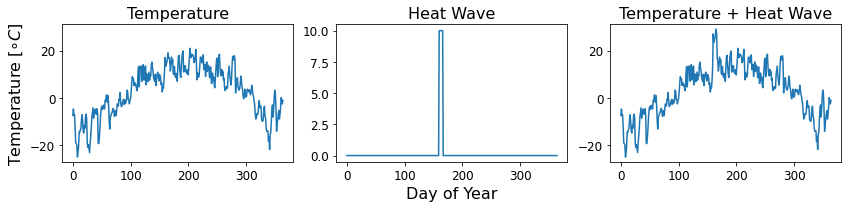

In [16]:
saveIt = 0

x1 = Tmax[365:2*365,6,20]
heat = np.zeros(365)
days_hot = np.arange(160,167)
heat[days_hot] = 10

fs = 16
vars = [x1-273, heat, x1 + heat - 273]
titles = ['Temperature', 'Heat Wave', 'Temperature + Heat Wave']
nrows = 1
ncols = len(vars)
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (4*ncols, 3*nrows))
for kk, ax in enumerate(axes.flatten()):
  ax.plot(vars[kk])
  ax.set_title(titles[kk], fontsize = fs)
  if kk == 1:
    ax.set_xlabel('Day of Year', fontsize = fs)
  if kk == 0:
    ax.set_ylabel('Temperature [$\circ C$]', fontsize = fs)
  if kk != 1:
    ax.set_ylim(top = np.max(vars[2])+2, bottom = np.min(vars[2])-2)
  ax.tick_params(labelsize = fs-4)

plt.tight_layout()

if saveIt:
  plt.savefig('heat_wave_temp_series.png', bbox_inches = 'tight', dpi = 300)

# Cluster seasonal flow

In [17]:
#create cluster input: half seasonal, quarter lat, quarter lon -- we want stations which have similar streamflow characteristics AND are nearby in space

frac_space = 0.5 #fraction of input vector to be the lat/lon
len_input = int(365/frac_space)
cluster_input = np.zeros((len(stationInds), len_input))

flowseason = flowDict['all_flowseason_NF'][stationInds,:]
stationLat_norm = (stationLat[stationInds] - np.mean(stationLat[stationInds])) / np.std(stationLat[stationInds])
stationLon_norm = (stationLon[stationInds] - np.mean(stationLon[stationInds])) / np.std(stationLon[stationInds])

for station in range(len(stationInds)):
  cluster_input[station,:365] = (flowseason[station,:] - np.mean(flowseason[station,:])) / np.std(flowseason[station,:]) #first half is normalized seasonal streamflow
  lat_inds = np.arange(365,365 + int((len_input - 365)/2)) #third quarter is normalized latitude
  lon_inds = np.arange(365 + int((len_input - 365)/2), len_input) #fourth quarter is normalized longitude
  cluster_input[station,lat_inds] = stationLat_norm[station] * np.ones_like(lat_inds)
  cluster_input[station,lon_inds] = stationLon_norm[station] * np.ones_like(lon_inds)

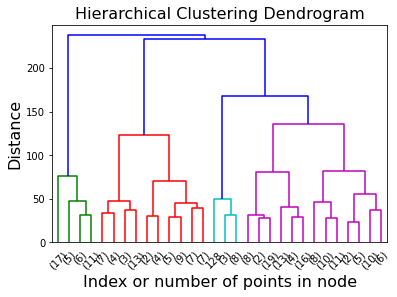

In [18]:
#visualize dendrogram to inform number of clusters

fig, ax = plt.subplots()
linked = linkage(cluster_input, 'ward')
dendrogram(linked, orientation = 'top', distance_sort = 'descending', truncate_mode = 'lastp', p = 30, ax = ax)

ax.set_xlabel("Index or number of points in node", fontsize = 16)
ax.set_ylabel('Distance', fontsize = 16)
ax.set_title('Hierarchical Clustering Dendrogram', fontsize = 16)

plt.show()

In [19]:
#from dendrogram, choose number of clusters and calculate mean pattern of each cluster

n_clusters_seasonal = 6
seasonal_clustering = AgglomerativeClustering(n_clusters = n_clusters_seasonal).fit(cluster_input)

#calculate average of each cluster
cluster_patterns = np.empty((n_clusters_seasonal, np.shape(cluster_input)[1]))
for cluster in range(n_clusters_seasonal):
  cluster_inds = np.argwhere(seasonal_clustering.labels_ == cluster)
  cluster_patterns[cluster,:] = np.mean(cluster_input[cluster_inds.reshape(-1,1),:], axis = 0)

In [20]:
#details for plotting/visualizations 

#determine RGB values of colormap to use: chosen from coolors.co
rgbs = [[241, 135, 1], #cluster 0
      [205, 223, 160], #cluster 1
      [159, 222, 249], #etc
      [233, 134, 207],
      [21, 96, 121],
      [100, 23, 35]]

rgbas = [[241, 135, 1,256],
      [205, 223, 160,256],
      [159, 222, 249,256],
      [233, 134, 207,256],
      [21, 96, 121,256],
      [100, 23, 35,256]]

rgbs_array = np.asarray(rgbs)/256
rgbas_array = np.asarray(rgbas)/256

#colours of each station
cStations = np.empty((len(stationInds), 3))
for kk in range(len(stationInds)):
  cStations[kk,:] = rgbs[seasonal_clustering.labels_[kk]]
cStations /= 256

#assign geographically relevant names for each cluster
cluster_names = [
                 'Central',       #cluster 0
                 'Southern',      #cluster 1
                 'Eastern',       #etc
                 'Coastal',
                 'North-Western',
                 'North-Eastern'
]

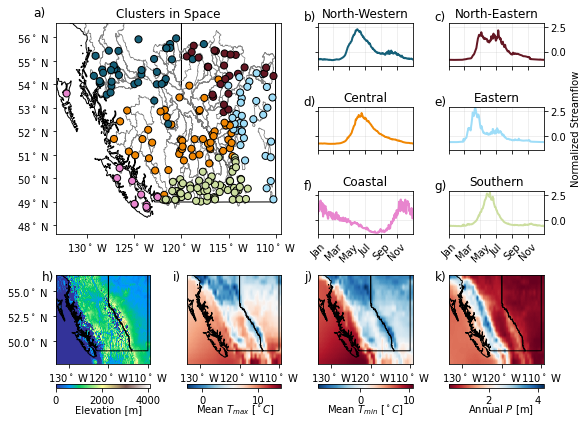

In [21]:
#visualize clustering results (spatial + temporal patterns), elevation, and climate

saveIt = 0

first_days_of_month = [0,31,59,90,120,151,181,212,243,273,304,334]
months_str = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fs = 12 #fontsize

abc = ['a)','b)','c)','d)','e)','f)','g)','h)','i)','j)','k)']

nrows = 5
ncols = 4

fig = plt.figure(figsize = (8,6))
gs = fig.add_gridspec(nrows = nrows, ncols = ncols)

##### top left side: spatial map of stations, coloured by cluster to which they belong

ax0 = fig.add_subplot(gs[:3,:2])

plot_prov_ax(prov=prov, ax = ax0)
ax0.scatter(stationLon[stationInds], stationLat[stationInds], c = cStations, s = 50, linewidth = 1, edgeColor = 'k', zOrder = 3)
ax0.tick_params(labelsize = fs-2)
ax0.set_title('Clusters in Space', fontsize = fs)
ax0.set_xlim((extentERA[0], extentERA[1]))
ax0.set_ylim((extentERA[2], extentERA[3]))
ax0.text(x = -0.1, y = 1.03, s = abc[0], transform = ax0.transAxes, fontsize = fs)

for basin in stationBasins:
  if basin is not None:
    x,y = basin.exterior.xy
    ax0.plot(x, y, color = 'gray', linewidth = 0.75)

##### top right side: subplots of seasonal streamflow of each cluster 

subplot_rows = [0,0,1,1,2,2]
subplot_cols = [2,3,2,3,2,3]

cluster_order = [4,5,0,2,3,1]

for kk, cluster in enumerate(cluster_order):

  ax = fig.add_subplot(gs[subplot_rows[kk], subplot_cols[kk]])
  ax.set_xticks(first_days_of_month[::2])
  ax.set_xlim((0,364))
  ax.set_ylim(bottom = np.min(cluster_patterns)-0.1, top = np.max(cluster_patterns)+0.1)
  ax.set_xticklabels(months_str[::2], rotation = 45)

  if kk<4:
    ax.set_xticklabels([])

  if np.mod(kk,2)==0:
    ax.set_yticklabels([])
  else:
    ax.tick_params(labelleft = False, labelright = True, left = False, right = True)

  if kk == 3:
    ax.set_ylabel('Normalized Streamflow')
    ax.yaxis.set_label_position("right")

  cluster_inds = np.squeeze(np.argwhere(seasonal_clustering.labels_ == cluster))

  var = cluster_patterns[cluster,:365]
  std = np.std(cluster_input[cluster_inds,:365], axis = 0)

  ax.plot(cluster_patterns[cluster,:365], color = rgbs_array[cluster], linewidth = 2)
  ax.tick_params(labelsize = fs-2)
  ax.set_title(cluster_names[cluster], fontsize = fs)
  ax.grid(True, alpha = 0.25)

  ax.text(x = -0.15, y = 1.05, s = abc[kk+1], transform = ax.transAxes, fontsize = fs)

##### bottom: elevation and climate subplots

ax_DEM = fig.add_subplot(gs[-2:,0])
ax_Tmax = fig.add_subplot(gs[-2:,1])
ax_Tmin = fig.add_subplot(gs[-2:,2])
ax_P = fig.add_subplot(gs[-2:,3])

#DEM subplot
extentDEM = [minlon, maxlon, minlat, maxlat]
im_DEM = ax_DEM.imshow(dem, vmin = 0, aspect = 'auto', cmap = 'terrain', extent = extentDEM)
ax_DEM.tick_params(right = False, left = True, labelright = False, labelleft = True)
cb = plt.colorbar(im_DEM, ax = ax_DEM, orientation = 'horizontal')
cb.ax.text(x = 0.2, y = -5, s = 'Elevation [m]', transform = cb.ax.transAxes)
ax_DEM.text(x = -0.15, y = 0.95, s = abc[7], transform = ax_DEM.transAxes, fontsize = fs)

#max temp subplot
im_Tmax = ax_Tmax.imshow(Tmax_mean - 273, aspect = 'auto', cmap = 'RdBu_r', extent = extentERA)
ax_Tmax.tick_params(right = False, left = False, labelright = False, labelleft = False)
cb = plt.colorbar(im_Tmax, ax = ax_Tmax, orientation = 'horizontal')
cb.ax.text(x = 0.1, y = -5, s = 'Mean $T_{max}$ [$^\circ C$]', transform = cb.ax.transAxes)
ax_Tmax.text(x = -0.15, y = 0.95, s = abc[8], transform = ax_Tmax.transAxes, fontsize = fs)

#min temp subplot
im_Tmin = ax_Tmin.imshow(Tmin_mean - 273, aspect = 'auto', cmap = 'RdBu_r', extent = extentERA)
ax_Tmin.tick_params(right = False, left = False, labelright = False, labelleft = False)
cb = plt.colorbar(im_Tmin, ax = ax_Tmin, orientation = 'horizontal')
cb.ax.text(x = 0.1, y = -5, s = 'Mean $T_{min}$ [$^\circ C$]', transform = cb.ax.transAxes)
ax_Tmin.text(x = -0.15, y = 0.95, s = abc[9], transform = ax_Tmin.transAxes, fontsize = fs)

#mean annual precip subplot
im_P = ax_P.imshow(Ptotal*6, aspect = 'auto', cmap = 'RdBu', extent = extentERA)
ax_P.tick_params(right = False, left = False, labelright = False, labelleft = False)
cb = plt.colorbar(im_P, ax = ax_P, orientation = 'horizontal')
cb.ax.text(x = 0.2, y = -5, s = 'Annual $P$ [m]', transform = cb.ax.transAxes)
ax_P.text(x = -0.15, y = 0.95, s = abc[10], transform = ax_P.transAxes, fontsize = fs)

#add provincial borders
plot_prov_ax(prov=prov, ax = ax_DEM)
plot_prov_ax(prov=prov, ax = ax_Tmax)
plot_prov_ax(prov=prov, ax = ax_Tmin)
plot_prov_ax(prov=prov, ax = ax_P)

#set extent
ax_DEM.set_xlim(left = extentERA[0], right = extentERA[1])
ax_DEM.set_ylim(bottom = extentERA[2], top = extentERA[3])
ax_Tmax.set_xlim(left = extentERA[0], right = extentERA[1])
ax_Tmax.set_ylim(bottom = extentERA[2], top = extentERA[3])
ax_Tmin.set_xlim(left = extentERA[0], right = extentERA[1])
ax_Tmin.set_ylim(bottom = extentERA[2], top = extentERA[3])
ax_P.set_xlim(left = extentERA[0], right = extentERA[1])
ax_P.set_ylim(bottom = extentERA[2], top = extentERA[3])

plt.tight_layout(h_pad = -0.5)

#edit ticklabels
axes = [ax0, ax_DEM, ax_Tmax, ax_Tmin, ax_P]
for ax in axes:
  xtls = [str(int(item.get_text()[1:])) + '$^\circ$ W' for item in ax.get_xticklabels()]
  ax.set_xticklabels(xtls)
  ytls = [item.get_text() + '$^\circ$ N' for item in ax.get_yticklabels()]
  ax.set_yticklabels(ytls)

if saveIt:
  plt.savefig('cluster_patterns_climate.png', bbox_inches = 'tight', dpi = 300)

plt.show()

In [22]:
#for each cluster, display elevation stats

for cluster in range(n_clusters_seasonal):

  inds = np.squeeze(np.argwhere(seasonal_clustering.labels_ == cluster))
  print(cluster_names[cluster])
  print('   Range of station elevation (in meters a.s.l.): ')
  print('     Minimum: ', np.min(stationGaugeElevation[inds]))
  print('     Maximum: ', np.max(stationGaugeElevation[inds]))
  print('     Mean:  ', np.mean(stationGaugeElevation[inds]))

Central
   Range of station elevation (in meters a.s.l.): 
     Minimum:  8.0
     Maximum:  1706.0
     Mean:   794.6923
Southern
   Range of station elevation (in meters a.s.l.): 
     Minimum:  38.0
     Maximum:  1660.0
     Mean:   930.9355
Eastern
   Range of station elevation (in meters a.s.l.): 
     Minimum:  523.0
     Maximum:  962.0
     Mean:   751.67645
Coastal
   Range of station elevation (in meters a.s.l.): 
     Minimum:  10.0
     Maximum:  87.0
     Mean:   36.25
North-Western
   Range of station elevation (in meters a.s.l.): 
     Minimum:  8.0
     Maximum:  917.0
     Mean:   520.6923
North-Eastern
   Range of station elevation (in meters a.s.l.): 
     Minimum:  494.0
     Maximum:  956.0
     Mean:   685.6667


In [23]:
#for each cluster, display area stats

for cluster in range(n_clusters_seasonal):

  inds = np.squeeze(np.argwhere(seasonal_clustering.labels_ == cluster))
  print(cluster_names[cluster])
  print('   Range of station drainage area (in km^2): ')
  print('     Minimum: ', np.min(stationDrainageArea[stationInds][inds]))
  print('     Maximum: ', np.max(stationDrainageArea[stationInds][inds]))
  print('     Median:  ', np.median(stationDrainageArea[stationInds][inds]))

Central
   Range of station drainage area (in km^2): 
     Minimum:  21.0
     Maximum:  55400.0
     Median:   1580.0
Southern
   Range of station drainage area (in km^2): 
     Minimum:  6.22
     Maximum:  11500.0
     Median:   288.5
Eastern
   Range of station drainage area (in km^2): 
     Minimum:  44.4
     Maximum:  4700.0
     Median:   579.5
Coastal
   Range of station drainage area (in km^2): 
     Minimum:  10.3
     Maximum:  480.0
     Median:   193.5
North-Western
   Range of station drainage area (in km^2): 
     Minimum:  13.2
     Maximum:  50300.0
     Median:   2850.0
North-Eastern
   Range of station drainage area (in km^2): 
     Minimum:  140.0
     Maximum:  74600.0
     Median:   1610.0


#Ensemble Analysis

In [42]:
#compare results from different model runs

#model runs to explore
runs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

#initialize
NSE_fine_runs = np.empty((len(runs), len(stationInds))) #fine-tuned NSE on test set
NSE_bulk_runs = np.empty((len(runs), len(stationInds))) #bulk NSE on test set
dNSE_runs = np.empty((len(runs), len(stationInds))) #difference in NSE from fine-tuning

A_fine_runs = np.empty((len(runs), len(stationInds))) #A from fine-tuned heatmaps on test set
A_bulk_runs = np.empty((len(runs), len(stationInds))) #A from bulk heatmaps on test set
dA_runs = np.empty((len(runs), len(stationInds))) #difference in A from fine-tuning

heat_mean_fine_runs = np.empty((len(runs), np.size(Tmax[0]), len(stationInds))) #fine-tuned heatmaps of each run
heat_mean_bulk_runs = np.empty((len(runs), np.size(Tmax[0]), len(stationInds))) #bulk heatmaps of each run

y_test_predict_bulk_runs = np.empty((len(runs), Ntest, len(stationInds))) #bulk model predictions of each run

y_train_predict_fine_runs = np.empty((len(runs), Ntrain-365, len(stationInds))) #fine-tuned model predictions of each run
y_val_predict_fine_runs = np.empty((len(runs), Nval, len(stationInds))) #fine-tuned model predictions of each run
y_test_predict_fine_runs = np.empty((len(runs), Ntest, len(stationInds))) #fine-tuned model predictions of each run

y_all_predict_fine_runs = np.empty((len(runs), Ntrain + Nval + Ntest - 365, len(stationInds)))

#loop through each run, open model outputs/heatmaps, calculate NSE and A
for ii, run in enumerate(runs):

  print('Run ' + str(run))

  #load modelled streamflow
  filename_train_fine = 'y_train_fine_predict_' + str(run) + '.csv'
  filename_val_fine = 'y_val_fine_predict_' + str(run) + '.csv'
  filename_test_fine = 'y_test_fine_predict_' + str(run) + '.csv'

  y_train_predict_fine = np.asarray(pd.read_csv(dir_output + '/' + filename_train_fine, header = None))
  y_val_predict_fine = np.asarray(pd.read_csv(dir_output + '/' + filename_val_fine, header = None))
  y_test_predict_fine = np.asarray(pd.read_csv(dir_output + '/' + filename_test_fine, header = None))

  y_train_predict_fine_runs[ii,:,:] = y_train_predict_fine
  y_val_predict_fine_runs[ii,:,:] = y_val_predict_fine
  y_test_predict_fine_runs[ii,:,:] = y_test_predict_fine
  y_all_predict_fine_runs[ii,:,:] = np.vstack((y_train_predict_fine, y_val_predict_fine, y_test_predict_fine))

  for station in range(226):
    NSE_fine_runs[ii,station] = nse(y_obs = y_test[:,station], y_model = y_test_predict_fine[:,station])

y_test_predict = np.mean(y_test_predict_fine_runs, axis = 0)
y_all_predict = np.mean(y_all_predict_fine_runs, axis = 0)

#also calculate NSE of the model ensemble average streamflow
NSE_bulk = np.empty(len(stationInds))
NSE_fine = np.empty(len(stationInds))

for station in range(len(stationInds)):

  NSE_bulk[station] = nse(
      y_obs = y_test[:,station],
      y_model = np.mean(y_test_predict_bulk_runs,axis = 0)[:,station]
  )

  NSE_fine[station] = nse(
      y_obs = y_test[:,station],
      y_model = np.mean(y_test_predict_fine_runs,axis = 0)[:,station]
  )

print('NSE test bulk ensemble = ' + str(np.round(np.median(NSE_bulk), decimals = 2)))
print('NSE test fine ensemble = ' + str(np.round(np.median(NSE_fine), decimals = 2)))

Run 0
Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in square


NSE test bulk ensemble = nan
NSE test fine ensemble = 0.68


In [74]:
#calculate NSE by year
Nyears = 36
NSE_yearly = np.zeros((Nyears, Nstations))
y_obs = np.vstack((y_train,y_val,y_test))
y_mod = np.vstack((
    np.mean(y_train_predict_fine_runs, axis = 0),
    np.mean(y_val_predict_fine_runs, axis = 0),
    np.mean(y_test_predict_fine_runs, axis = 0)))

# Nyears_train = int(np.floor(Ntrain / 365))
# Nyears_val = int(np.floor(Nval / 365))
# Nyears_test = int(np.floor(Ntest / 365))

# kk_year = 0

for year in range(Nyears):
  
  start = year*365
  fin = start + 365

  for station in range(Nstations):
    NSE_yearly[year, station] = nse(
      y_obs = y_obs[start:fin,station],
      y_model = y_mod[start:fin,station]
    )
NSE_yearly[NSE_yearly<0] = 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in double_scalars


In [97]:
dir_heat = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/heat_maps' #where to save heatmaps

#compare results from different model runs

#model runs to explore
runs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

#initialize
NSE_fine_runs = np.empty((len(runs), len(stationInds))) #fine-tuned NSE on test set
NSE_bulk_runs = np.empty((len(runs), len(stationInds))) #bulk NSE on test set
dNSE_runs = np.empty((len(runs), len(stationInds))) #difference in NSE from fine-tuning

A_fine_runs = np.empty((len(runs), len(stationInds))) #A from fine-tuned heatmaps on test set
A_bulk_runs = np.empty((len(runs), len(stationInds))) #A from bulk heatmaps on test set
dA_runs = np.empty((len(runs), len(stationInds))) #difference in A from fine-tuning

heat_mean_fine_runs = np.empty((len(runs), np.size(Tmax[0]), len(stationInds))) #fine-tuned heatmaps of each run
heat_mean_bulk_runs = np.empty((len(runs), np.size(Tmax[0]), len(stationInds))) #bulk heatmaps of each run

y_test_predict_bulk_runs = np.empty((len(runs), Ntest, len(stationInds))) #bulk model predictions of each run
y_test_predict_fine_runs = np.empty((len(runs), Ntest, len(stationInds))) #fine-tuned model predictions of each run

y_all_predict_fine_runs = np.empty((len(runs), Ntrain + Nval + Ntest - 365, len(stationInds)))

#loop through each run, open model outputs/heatmaps, calculate NSE and A
for ii, run in enumerate(runs):

  print('Run ' + str(run))

  #load modelled streamflow
  filename_train_fine = 'y_train_fine_predict_' + str(run) + '.csv'
  filename_val_fine = 'y_val_fine_predict_' + str(run) + '.csv'
  filename_test_fine = 'y_test_fine_predict_' + str(run) + '.csv'

  y_train_predict_fine = np.asarray(pd.read_csv(dir_output + '/' + filename_train_fine, header = None))
  y_val_predict_fine = np.asarray(pd.read_csv(dir_output + '/' + filename_val_fine, header = None))
  y_test_predict_fine = np.asarray(pd.read_csv(dir_output + '/' + filename_test_fine, header = None))
  y_test_predict_fine_runs[ii,:,:] = y_test_predict_fine
  y_all_predict_fine_runs[ii,:,:] = np.vstack((y_train_predict_fine, y_val_predict_fine, y_test_predict_fine))

  #load heat maps
  filename_bulk = 'heat_mean_bulk_' + str(run) + '.csv'
  filename_fine = 'heat_mean_fine_' + str(run) + '.csv'
  heat_mean_bulk = np.asarray(pd.read_csv(dir_heat + '/' + filename_bulk, header = None))
  heat_mean_fine = np.asarray(pd.read_csv(dir_heat + '/' + filename_fine, header = None))
  heat_mean_bulk_runs[ii,:,:] = heat_mean_bulk
  heat_mean_fine_runs[ii,:,:] = heat_mean_fine

  for station in range(226):
    NSE_fine_runs[ii,station] = nse(y_obs = y_test[:,station], y_model = y_test_predict_fine[:,station])

y_test_predict = np.mean(y_test_predict_fine_runs, axis = 0)
y_all_predict = np.mean(y_all_predict_fine_runs, axis = 0)

Run 0
Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9


In [98]:
#also calculate NSE of the model ensemble average streamflow

NSE_bulk = np.empty(len(stationInds))
NSE_fine = np.empty(len(stationInds))

for station in range(len(stationInds)):

  NSE_bulk[station] = nse(
      y_obs = y_test[:,station],
      y_model = np.mean(y_test_predict_bulk_runs,axis = 0)[:,station]
  )

  NSE_fine[station] = nse(
      y_obs = y_test[:,station],
      y_model = np.mean(y_test_predict_fine_runs,axis = 0)[:,station]
  )

print('NSE test bulk ensemble = ' + str(np.round(np.median(NSE_bulk), decimals = 2)))
print('NSE test fine ensemble = ' + str(np.round(np.median(NSE_fine), decimals = 2)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in square


NSE test bulk ensemble = -inf
NSE test fine ensemble = 0.68


In [99]:
stationID = flowDict['stationID'][stationInds]

ids = [
       '08LB064', #North Thompson River at McLure
       '08LE031', #South Thompson River at Chase
       '08LF051', #Thompson River near Spences Bridge
       '07FB001', #Pine River at East Pine
       '08NH084', #Arrow Creek at Erickson
       '07FD001', #Kiskatinaw Creek at Farmington
       '08FF001', #Kitimat River below Hirsch Creek
       '08NJ130', #Anderson Creek near Nelson
       '08EE004', #Bulkley River at Quick
       '08EF001'  #Skeena River at Usk
]

station_comm_inds = np.array([np.argwhere(stationID == id).squeeze() for id in ids])
NSE_fine[station_comm_inds]

array([0.92220462, 0.90986215, 0.93412061, 0.84065567, 0.74357036,
       0.31963672, 0.53036121, 0.6692596 , 0.8252776 , 0.90872266])

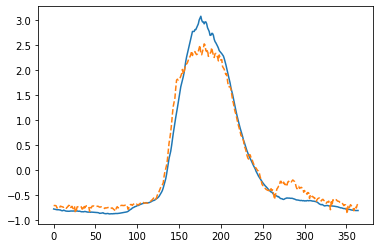

In [100]:
fig, ax = plt.subplots()

# ax.plot(y_test[:365,station_comm_inds[0]],'k')
ax.plot(y_test[:365,station_comm_inds[1]])

# ax.plot(y_test_predict[:365,station_comm_inds[0]],'k--')
ax.plot(y_test_predict[:365,station_comm_inds[1]], linestyle = '--')

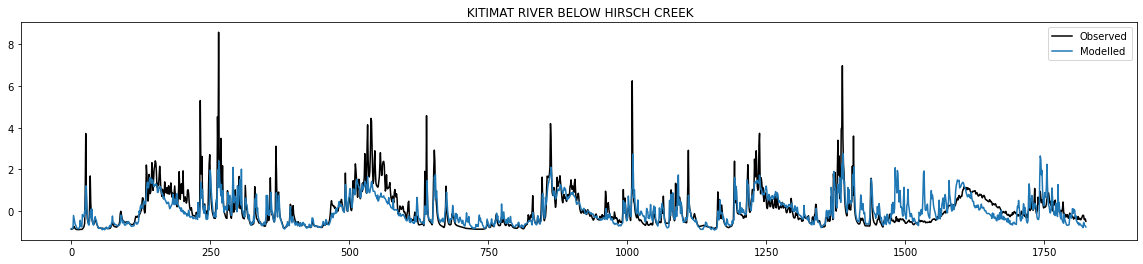

In [101]:
ind = 6

fig, ax = plt.subplots(figsize = (20,4))

ax.plot(y_test[:,station_comm_inds[ind]], 'k', label = 'Observed')
ax.plot(y_test_predict[:,station_comm_inds[ind]], label = 'Modelled')
ax.set_title(stationNames[station_comm_inds[ind]])
plt.legend()

In [102]:
#normalize each heat maps to have zero mean and unity variance -- want to compare spatial form of sensitivity

#initialize
heat_mean_fine_runs_norm = np.zeros_like(heat_mean_fine_runs)
heat_mean_bulk_runs_norm = np.zeros_like(heat_mean_bulk_runs)

#for each station and run, load/normalize each bulk/fine heat map
for station in range(len(stationInds)):
  for run in range(len(runs)):

    hh = heat_mean_fine_runs[run,:,station]
    heat_mean_fine_runs_norm[run,:,station] = (hh - np.mean(hh)) / np.std(hh)

    hh = heat_mean_bulk_runs[run,:,station]
    heat_mean_bulk_runs_norm[run,:,station] = (hh - np.mean(hh)) / np.std(hh)

#calculate ensemble mean heat map for each station
heat_fine_ensemble_mean = heat_mean_fine#heat_mean_fine_runs_norm[0]#
heat_fine_ensemble_mean = np.mean(heat_mean_fine_runs_norm, axis = 0)
heat_bulk_ensemble_mean = np.mean(heat_mean_bulk_runs_norm, axis = 0)

cluster_heat_fine_mean = []
cluster_heat_bulk_mean = []

#calculate ensemble mean heat map for each cluster
for cluster in range(n_clusters_seasonal):

  inds = np.argwhere(seasonal_clustering.labels_ == cluster).reshape(-1,1) #indices of the cluster

  cluster_heat_mean_fine_current = np.squeeze(np.mean(heat_fine_ensemble_mean[:,inds], axis = 1))
  cluster_heat_mean_bulk_current = np.squeeze(np.mean(heat_bulk_ensemble_mean[:,inds], axis = 1))
  
  cluster_heat_fine_mean.append(cluster_heat_mean_fine_current)
  cluster_heat_bulk_mean.append(cluster_heat_mean_bulk_current)

# #calculate sensitive areas on ensemble mean heat maps
# A_fine = np.zeros((len(stationInds),))
# A_bulk= np.zeros((len(stationInds),))

# for station in range(len(stationInds)):
#   A_bulk[station] = get_A(heat = heat_bulk_ensemble_mean[:,station])
#   A_fine[station] = get_A(heat = heat_fine_ensemble_mean[:,station])

In [103]:
from scipy.stats import ks_2samp, pearsonr

In [104]:
def get_ks(heat, radius, basins, eraLon, eraLat, stationLon, stationLat, stationInds, n_clusters, labels):

  """
  Calculates Kolmogorov-Smirnov (KS) D-statistic

  heat = sensitivity heat map, numpy array; dimensions of (n_lat*n_lon) x n_stations (e.g. 384 x 226 if there are 226 stations and the ERA5 input is 12 x 32 in space)
  radius = radius around stream gauge basins which counts as 'near' the watersheds (for in/near vs out/far distribution determination)
  basins = list of stream gauge basins (polygons from which exteriors are used to calculate in/near vs out/far)
  eraLon = np array of longitudes in ERA5 grid
  eraLat = np array of latitudes in ERA5 grid
  stationLon = np array of longitudes of all stream gauge stations
  stationLat = np array of latitudes of all stream gauge stations
  stationInds = np array of indices of stations in stationLon/Lat/basins to use
  n_clusters = int; number of streamflow regimes/clusters 
  labels = np array of cluster labels of each stream gauge station
  """
  
  #initialize
  heat_in_station = [None] * len(stationInds)
  heat_out_station = [None] * len(stationInds)
  inside_all_stations = [None] * len(stationInds)
  outside_all_stations = [None] * len(stationInds)
  heat_in_clusters = [None] * n_clusters
  heat_out_clusters = [None] * n_clusters

  x = eraLon #rename for readability when making xx and xxv
  y = eraLat
  xx,yy = np.meshgrid(x,y)
  xxv = xx.reshape(-1) #vector (array) where paired elements in xxv and yyv correspond to one pixel in heat map sensitivity space
  yyv = yy.reshape(-1)

  points = list(zip(xx.flatten(),yy.flatten())) #will loop through each point to see if sensitivity there is in/near or out/far from basins

  #loop through each station and determine in/out points/sensitivity
  for station in range(len(stationInds)):

    #initialize
    heat_in_this_station = []
    heat_out_this_station = []

    #heatmap/basin of the current station
    heat_station = heat[:,station]
    basin = stationBasins[station]
      
    #determine basin outlines  
    if basin is not None: #if basin polygon(s) exist -- some small basins do not have polygons from this source (see elif)
      
      # xb,yb = basin[0][0].exterior.xy #lon/lat (x/y) points of watershed/basin boundary
      xb,yb = basin.exterior.xy #lon/lat (x/y) points of watershed/basin boundary
      basinPath = matplotlib.path.Path(np.vstack((xb, yb)).T, closed = True) #convert to path to use contains_points method
      # inside = basinPath.contains_points(points, radius = radius) #in theory this statement should work -- sometimes had errors.  Manually calculate below instead.
    
    elif basin is None: #if basin shapefile is missing, use stream gauge location w/ radius buffer to estimate in/near pixels (these are small basins)

      xb = stationLon[stationInds][station] #basin outline taken to be single point at stream gauge
      yb = stationLat[stationInds][station]
      
    #create binary in/near (True) vs out/far (False)
    inside = np.zeros(np.size(Tmax[0])) #initialize inside/outside array
    for ii, point in enumerate(points): #for each point/pixel in ERA5 space
      d = np.sqrt((point[0] - xb)**2 + (point[1] - yb)**2) #distance from point in ERA5 to all points around basin
      if np.min(d) <= radius: #if the nearest basin edge to current point in ERA5 is less than prescribed allowable radius
        inside[ii] = True #then this point in ERA5 is considered 'inside' (or near) this basin

    inside_this_station = np.squeeze(np.argwhere(inside==True)) #array of indices which are inside this station's basin
    outside_this_station = np.squeeze(np.argwhere(inside==False)) #array of indices which are outside this station's basin

    heat_in_station[station] = heat_station[inside_this_station] #sensitivity ('heat') of the inside/near pixels
    heat_out_station[station] = heat_station[outside_this_station] #sensitivity ('heat') of the outside/far pixels

    inside_all_stations[station] = inside_this_station #list of arrays of indices which are inside/near each stations' basin
    outside_all_stations[station] = outside_this_station #list of arrays of indices which are outside/far each stations' basin

  #find the sensitivity ('heat') of inside/near and outisde/far of all stations belonging to each cluster
  for cluster in range(n_clusters):

    #initialize
    heat_in_this_cluster = []
    heat_out_this_cluster = []
    stations_this_cluster = np.squeeze(np.argwhere(labels == cluster)) #stations in this cluster

    #print(stations_this_cluster)
    for station in stations_this_cluster: #for each station in the cluster
      for temp in heat_in_station[station]: #for each sensitivity ('heat') value within/near this station's basin
        heat_in_this_cluster.append(temp) #append the heat to the "inside cluster's" set
      for temp in heat_out_station[station]: #for each sensitivity ('heat') value outside/far from this station's basin
        heat_out_this_cluster.append(temp) #append the heat to the "outside cluster's" set

    heat_in_clusters[cluster] = heat_in_this_cluster
    heat_out_clusters[cluster] = heat_out_this_cluster

  #find unique pixels in each clusters' set of basins; some basins in same cluster can share pixels, but here we want unique indices for visualization
  unique_in_clusters = [None] * n_clusters

  for cluster in range(n_clusters): #for each cluster

    unique_in_this_cluster = [] #initialize
    stations_this_cluster = np.squeeze(np.argwhere(labels == cluster)) #stations in this cluster

    for station in stations_this_cluster: #for each station
      for ind in inside_all_stations[station]: #for each index within/near this stations' basin
        unique_in_this_cluster.append(ind) #append the index
    unique_in_clusters[cluster] = list(set(unique_in_this_cluster)) #since some stations in the same cluster have the same index, take only unique indices

  #now, calculate Kolmogorov-Smirnov D-Statistic as evaluated between inside/outside heat distributions for each cluster
  ks = np.empty(n_clusters)
  p = np.empty(n_clusters)
  for cluster in range(n_clusters):
    ks[cluster],p[cluster] = ks_2samp(heat_in_clusters[cluster], heat_out_clusters[cluster])

  return ks, p, heat_in_clusters, heat_out_clusters, unique_in_clusters

In [105]:
#calculate kolmogorov-smirnov D-statistic for each bulk/fine run, and bulk/fine ensembles

#initialize
ks_bulk = np.zeros((len(runs), n_clusters_seasonal))
ks_fine = np.zeros((len(runs), n_clusters_seasonal))

p_bulk = np.zeros((len(runs), n_clusters_seasonal))
p_fine = np.zeros((len(runs), n_clusters_seasonal))

heat_in_clusters_bulk = [None] * len(runs)
heat_in_clusters_fine = [None] * len(runs)

heat_out_clusters_bulk = [None] * len(runs)
heat_out_clusters_fine = [None] * len(runs)

unique_in_clusters_bulk = [None] * len(runs)
unique_in_clusters_fine = [None] * len(runs)

#for each run, calculate D-stat for bulk/fine heat maps
for run_ind in range(len(runs)):
  
  #calculate ks for bulk
  data = heat_mean_bulk_runs[run_ind,:,:]
  data_mean = data.mean(axis=0)
  data_std = data.std(axis=0)
  data_norm = np.asarray([(data[:,kk] - data_mean[kk]) / data_std[kk] for kk in range(len(stationInds))]).T

  ks_bulk[run_ind,:], p_bulk[run_ind,:], heat_in_clusters_bulk[run_ind], heat_out_clusters_bulk[run_ind], unique_in_clusters = get_ks(
      heat = data_norm, 
      radius = 1.,
      basins = stationBasins, 
      eraLon = eraLon, 
      eraLat = eraLat, 
      stationLon = stationLon, 
      stationLat = stationLat, 
      stationInds = stationInds, 
      n_clusters = n_clusters_seasonal, 
      labels = seasonal_clustering.labels_
      )

  #calculate ks for fine
  data = heat_mean_fine_runs[run_ind,:,:]
  data_mean = data.mean(axis=0)
  data_std = data.std(axis=0)
  data_norm = np.asarray([(data[:,kk] - data_mean[kk]) / data_std[kk] for kk in range(len(stationInds))]).T

  ks_fine[run_ind,:], p_fine[run_ind,:], heat_in_clusters_fine[run_ind], heat_out_clusters_fine[run_ind], unique_in_clusters = get_ks(
      heat = data_norm, 
      radius = 1.,
      basins = stationBasins, 
      eraLon = eraLon, 
      eraLat = eraLat, 
      stationLon = stationLon, 
      stationLat = stationLat, 
      stationInds = stationInds, 
      n_clusters = n_clusters_seasonal, 
      labels = seasonal_clustering.labels_
      )

#calculate for bulk ensemble mean heat map
data = heat_bulk_ensemble_mean
data_mean = data.mean(axis=0)
data_std = data.std(axis=0)
data_norm = np.asarray([(data[:,kk] - data_mean[kk]) / data_std[kk] for kk in range(len(stationInds))]).T
ks_bulk_ensemble, p_bulk_ensemble, heat_in_clusters_bulk_ensemble, heat_out_clusters_bulk_ensemble, unique_in_clusters = get_ks(
      heat = data_norm, 
      radius = 1.,
      basins = stationBasins, 
      eraLon = eraLon, 
      eraLat = eraLat, 
      stationLon = stationLon, 
      stationLat = stationLat, 
      stationInds = stationInds, 
      n_clusters = n_clusters_seasonal, 
      labels = seasonal_clustering.labels_
      )

#calculate for fine-tuned ensemble mean heat map
data = heat_fine_ensemble_mean
data_mean = data.mean(axis=0)
data_std = data.std(axis=0)
data_norm = np.asarray([(data[:,kk] - data_mean[kk]) / data_std[kk] for kk in range(len(stationInds))]).T
ks_fine_ensemble, p_fine_ensemble, heat_in_clusters_fine_ensemble, heat_out_clusters_fine_ensemble, unique_in_clusters = get_ks(
      heat = data_norm, 
      radius = 1.,
      basins = stationBasins, 
      eraLon = eraLon, 
      eraLat = eraLat, 
      stationLon = stationLon, 
      stationLat = stationLat, 
      stationInds = stationInds, 
      n_clusters = n_clusters_seasonal, 
      labels = seasonal_clustering.labels_
      )

#Heat wave quantification

In [106]:
inds_jan1 = np.argwhere((eraDays == 1) & (eraMonths == 1)).squeeze()
Nyears = len(inds_jan1)
Ndays = np.shape(Tmax)[0]
Nlat = len(eraLat)
Nlon = len(eraLon)

Tmax_90p = np.zeros((Nlat, Nlon, 365))
Tmax_mats = np.zeros((Nlat, Nlon, Nyears, 365))
Tmax_diffs = np.zeros((Nlat, Nlon, Nyears*365))
is_heat_wave = np.zeros((Nlat,Nlon,Nyears*365))
P_mats = np.zeros((Nlat, Nlon, Nyears, 365))

kk_lat = 10
kk_lon = 20

for kk_lat in range(Nlat):
  for kk_lon in range(Nlon):

    Tmax_mat = np.zeros((Nyears,365))
    P_mat = np.zeros((Nyears,365))

    for kk, ind_jan1 in enumerate(inds_jan1):
      Tmax_mat[kk,:] = Tmax[ind_jan1 : ind_jan1 + 365, kk_lat, kk_lon] #Nyears x 365
      P_mat[kk,:] = P[ind_jan1 : ind_jan1 + 365, kk_lat, kk_lon]

    Tmax_mats[kk_lat,kk_lon,:,:] = Tmax_mat
    P_mats[kk_lat,kk_lon,:,:] = P_mat

    Tmax_90p[kk_lat,kk_lon,:] = np.percentile(Tmax_mat, q = 90, axis = 0)
    Tmax_diff = Tmax_mat - Tmax_90p[kk_lat,kk_lon,:] #Nyears x 365
    Tmax_diff = Tmax_diff.reshape(-1,1).squeeze()
    Tmax_diffs[kk_lat,kk_lon,:] = Tmax_diff

    inds_heat = np.argwhere(Tmax_diff > 0).squeeze()

    for kk in range(len(Tmax_diff)-2):

      if is_heat_wave[kk_lat,kk_lon,kk] == 0:

        T0 = Tmax_diff[kk]
        T1 = Tmax_diff[kk+1]
        T2 = Tmax_diff[kk+2]

        if (T0>0) & (T1>0) & (T2>0):
          is_heat_wave[kk_lat,kk_lon,kk] = 1
          is_heat_wave[kk_lat,kk_lon,kk+1] = 1
          is_heat_wave[kk_lat,kk_lon,kk+2] = 1

In [107]:
#characterize heat waves on average over whole period: number and intensity 

N_heat_waves = np.zeros((Nlat,Nlon))
len_heat_waves_mean = np.zeros((Nlat,Nlon))
T_heat_waves_mean = np.zeros((Nlat,Nlon))

P_mean = np.sum(np.sum(P_mats, axis = -1), axis = -1) / Nyears

for kk_lat in range(Nlat):
  for kk_lon in range(Nlon):

    is_heat_wave_diff = is_heat_wave[kk_lat,kk_lon,1:] - is_heat_wave[kk_lat,kk_lon,:-1]
    heat_starts = np.argwhere(is_heat_wave_diff == 1).squeeze() + 1
    heat_ends = np.argwhere(is_heat_wave_diff == -1).squeeze() 

    if heat_starts[-1] > heat_ends[-1]: #if the final heat wave identified starts but doesn't end in the record
      heat_starts = heat_starts[:-1]

    #number of heat waves at this grid cell
    N_heat_waves[kk_lat,kk_lon] = len(heat_starts)

    #quantify temperature and length in days of each heat wave
    T_heat_waves_here = np.zeros(int(N_heat_waves[kk_lat,kk_lon]))
    len_heat_waves_here = np.zeros(int(N_heat_waves[kk_lat,kk_lon]))

    for kk_heat in range(int(N_heat_waves[kk_lat,kk_lon])): #for each heat wave at this grid cell
      # T_heat_waves_here[kk_heat]= np.mean(Tmax[heat_starts[kk_heat] : heat_ends[kk_heat],kk_lat, kk_lon]) #temp = mean temp degrees
      # T_heat_waves_here[kk_heat] = np.max(Tmax[heat_starts[kk_heat] : heat_ends[kk_heat],kk_lat, kk_lon]) #temp = max temp degrees
      T_heat_waves_here[kk_heat] = np.mean(Tmax_diffs[kk_lat,kk_lon,heat_starts[kk_heat] : heat_ends[kk_heat]]) #temp = mean temp degrees above 90p
      # T_heat_waves_here[kk_heat] = np.max(Tmax_diffs[kk_lat,kk_lon,heat_starts[kk_heat] : heat_ends[kk_heat]]) #temp = max temp degrees above 90p
      # T_heat_waves_here[kk_heat]= np.mean(Tmax[heat_starts[kk_heat] : heat_ends[kk_heat],kk_lat, kk_lon]) - Tmax_90p[kk_lat,kk_lon,np.mod(heat_starts[kk_heat],365)] #temp = mean temp degrees from 90p
      # T_heat_waves_here[kk_heat] = np.max(Tmax[heat_starts[kk_heat] : heat_ends[kk_heat],kk_lat, kk_lon]) - Tmax_90p[kk_lat,kk_lon,np.mod(heat_starts[kk_heat],365)] #temp = max temp degrees from 90p
      len_heat_waves_here[kk_heat] = heat_ends[kk_heat] - heat_starts[kk_heat] + 1 #length

    T_heat_waves_mean[kk_lat,kk_lon] = np.mean(T_heat_waves_here) #in degrees
    len_heat_waves_mean[kk_lat,kk_lon] = np.mean(len_heat_waves_here)

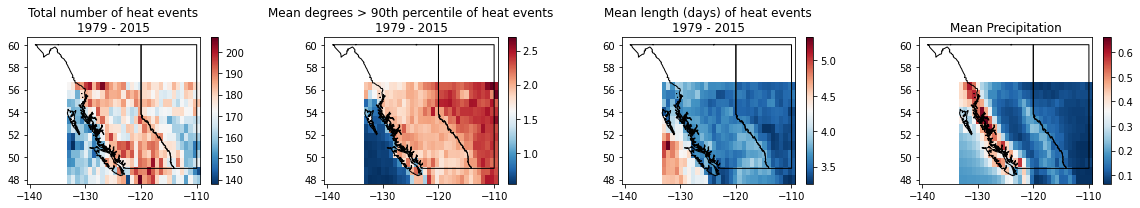

In [108]:
saveIt = 0

vars = [
        N_heat_waves,
        T_heat_waves_mean,
        len_heat_waves_mean,
        P_mean        
]
Nvars = len(vars)

titles = [
          'Total number of heat events\n1979 - 2015',
          'Mean degrees > 90th percentile of heat events\n1979 - 2015',
          'Mean length (days) of heat events\n1979 - 2015',
          'Mean Precipitation'
]

nrows = 1
ncols = Nvars

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (4*ncols, 3*nrows))

for kk, var in enumerate(vars):

  im = axes[kk].imshow(var,aspect = 'auto', cmap = 'RdBu_r', extent = extentERA)
  plot_prov_ax(prov = prov, ax = axes[kk])
  plt.colorbar(im, ax = axes[kk])
  axes[kk].set_title(titles[kk])

# im = axes[1].imshow(T_heat_waves_mean,aspect = 'auto', cmap = 'RdBu_r', extent = extentERA)
# plot_prov_ax(prov = prov, ax = axes[1])
# plt.colorbar(im, ax = axes[1])
# axes[1].set_title(titles[kk])

# im = axes[2].imshow(len_heat_waves_mean,aspect = 'auto', cmap = 'RdBu_r', extent = extentERA)
# plot_prov_ax(prov = prov, ax = axes[2])
# plt.colorbar(im, ax = axes[2])
# axes[2].set_title(titles[kk])

plt.tight_layout()

if saveIt:
  plt.savefig('heat_wave_prelim2.png', bbox_inches = 'tight', dpi = 300)

plt.show()

In [ ]:
#prep for clustering

Npx = Nlat*Nlon
cluster_input = np.zeros((Nyears*365, Npx))
for day in range(Nyears*365):
  cluster_input[day,:] = is_heat_wave[:,:,day].reshape(1,-1)

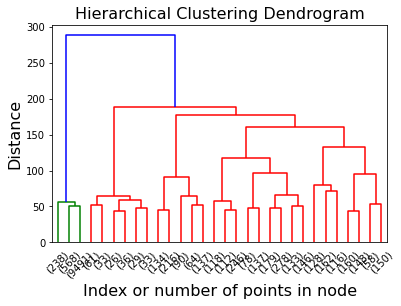

In [ ]:
#visualize dendrogram to inform number of clusters

fig, ax = plt.subplots()
linked = linkage(cluster_input, 'ward')
dendrogram(linked, orientation = 'top', distance_sort = 'descending', truncate_mode = 'lastp', p = 30, ax = ax)

ax.set_xlabel("Index or number of points in node", fontsize = 16)
ax.set_ylabel('Distance', fontsize = 16)
ax.set_title('Hierarchical Clustering Dendrogram', fontsize = 16)

plt.show()

In [ ]:
#from dendrogram, choose number of clusters and calculate mean pattern of each cluster

n_clusters_seasonal = 6
seasonal_clustering = AgglomerativeClustering(n_clusters = n_clusters_seasonal).fit(cluster_input)

#calculate average of each cluster
cluster_patterns = np.empty((n_clusters_seasonal, np.shape(cluster_input)[1]))
for cluster in range(n_clusters_seasonal):
  cluster_inds = np.argwhere(seasonal_clustering.labels_ == cluster)
  cluster_patterns[cluster,:] = np.mean(cluster_input[cluster_inds.reshape(-1,1),:], axis = 0)

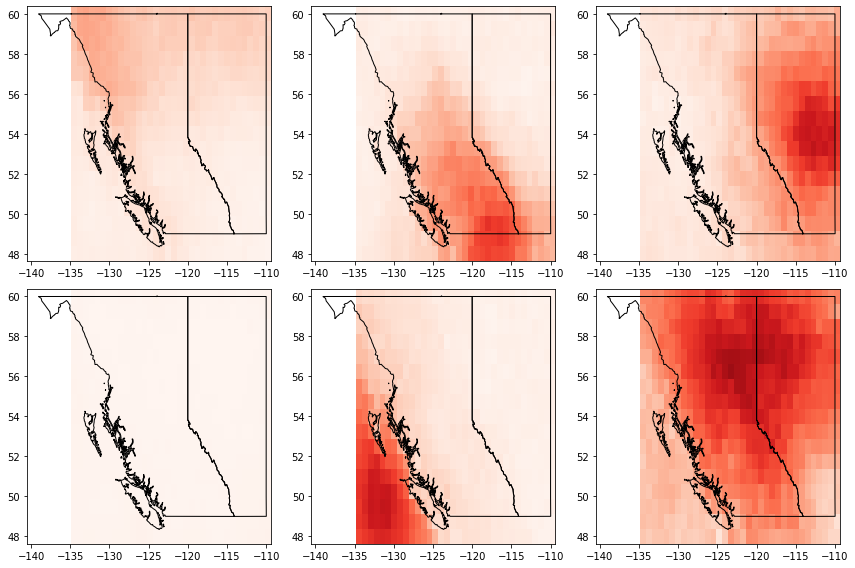

In [ ]:
saveIt = 0

nrows = 2
ncols = n_clusters_seasonal//2

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (4*ncols, 4*nrows))

for cluster, ax in enumerate(axes.flatten()):
  ax.imshow(cluster_patterns[cluster,:].reshape(Nlat,Nlon), vmax = 1, vmin = 0, cmap = 'Reds', extent = extentERA, aspect = 'auto')
  plot_prov_ax(prov = prov, ax = ax)

plt.tight_layout()

if saveIt:
  plt.savefig('heat_wave_prelim.png', bbox_inches = 'tight', dpi = 300)

In [ ]:
kk_year, kk_lat, kk_lon, np.size(heat_starts)

(0, 6, 2, 1)

In [49]:
np.shape(P_mats)

(17, 44, 37, 365)

In [60]:
Tmax_mat

array([[254.56571791, 256.79321542, 256.59932984, ..., 274.99513554,
        270.44392661, 275.02429126],
       [276.81007952, 271.703454  , 273.82744869, ..., 282.43567696,
        280.29127327, 283.5727503 ],
       [274.412021  , 274.29977146, 274.82457454, ..., 252.1137213 ,
        255.4083184 , 255.31502008],
       ...,
       [269.33163564, 270.83315556, 270.1363337 , ..., 267.55896747,
        272.31572426, 267.53126953],
       [267.60124327, 270.69758143, 279.09005734, ..., 262.00771712,
        253.22163891, 267.98026772],
       [272.03582929, 273.4207263 , 271.66555156, ..., 262.7992951 ,
        263.75414514, 264.28769494]])

In [109]:
#characterize heat waves for each year and each pixel: number, intensity, total precip, snow fraction

N_heat_waves = np.zeros((Nyears,Nlat,Nlon)) #years, lat, lon
len_heat_waves_mean = np.zeros((Nyears,Nlat,Nlon))
T_heat_waves_mean = np.zeros((Nyears,Nlat,Nlon))

#calc precip indicators
Tmax_mats = np.zeros((Nyears, Nlat, Nlon, 365))
P_mats = np.zeros((Nyears, Nlat, Nlon, 365))
P_snow_mats = np.zeros((Nyears, Nlat, Nlon, 365))

for kk_lat in range(Nlat):
  for kk_lon in range(Nlon):

    Tmax_mat = np.zeros((Nyears,365))
    P_mat = np.zeros((Nyears,365))
    P_snow_mat = np.zeros((Nyears, 365))

    for kk, ind_jan1 in enumerate(inds_jan1):
      Tmax_mat[kk,:] = Tmax[ind_jan1 : ind_jan1 + 365, kk_lat, kk_lon] #Nyears x 365
      P_mat[kk,:] = P[ind_jan1 : ind_jan1 + 365, kk_lat, kk_lon]
    P_snow_mat[Tmax_mat < 273] = P_mat[Tmax_mat < 273]

    Tmax_mats[:,kk_lat,kk_lon,:] = Tmax_mat
    P_mats[:,kk_lat,kk_lon,:] = P_mat
    P_snow_mats[:,kk_lat,kk_lon,:] = P_snow_mat

P_total = np.sum(P_mats, axis = -1)
P_snow_frac = np.sum(P_snow_mats, axis = -1) / P_total

#calc heat wave indicators
for kk_year in range(Nyears):
  for kk_lat in range(Nlat):
    for kk_lon in range(Nlon):
      
      if kk_year == 0:
        kk_jan1 = kk_year*365
        kk_dec31 = kk_jan1 + 365 + 3
      elif kk_year == Nyears - 1:
        kk_jan1 = kk_year*365 - 3
        kk_dec31 = kk_jan1 + 365
      else:
        kk_jan1 = kk_year*365 - 3
        kk_dec31 = kk_jan1 + 365 + 3

      if kk_year == Nyears - 1:
        is_heat_wave_diff = is_heat_wave[kk_lat, kk_lon, kk_jan1+1:kk_dec31] - is_heat_wave[kk_lat,kk_lon,kk_jan1:kk_dec31-1]
      else:
        is_heat_wave_diff = is_heat_wave[kk_lat, kk_lon, kk_jan1+1:kk_dec31+1] - is_heat_wave[kk_lat,kk_lon,kk_jan1:kk_dec31]

      heat_starts = kk_jan1 + np.argwhere(is_heat_wave_diff == 1).squeeze() + 1
      heat_ends = kk_jan1 + np.argwhere(is_heat_wave_diff == -1).squeeze() 

      if (np.size(heat_starts) > 0) & (np.size(heat_ends) > 0):

        #if only one heat wave this year, make into array
        if np.size(heat_starts) == 1:
          heat_starts = np.array([heat_starts.squeeze()])
        if np.size(heat_ends) == 1:
          heat_ends = np.array([heat_ends.squeeze()])

        #if error caused start of first heat wave to be after end of first heat wave 
        if heat_starts[0] > heat_ends[0]:
          heat_ends = heat_ends[1:]

        if np.size(heat_ends) > 0:

          #if error caused end of last heat wave to be before start of last heat wave  
          if heat_ends[-1] < heat_starts[-1]:
            heat_starts = heat_starts[:-1]

          # if heat_starts[0] < kk_year*365:
          #   heat_starts = heat_starts[1:]
          #   heat_ends = heat_ends[1:]
          # if heat_starts[-1] > (kk_year+1)*365:
          #   heat_starts = heat_starts[:-1]
          #   heat_ends = heat_ends[:-1]

          if np.size(heat_ends) < np.size(heat_starts):
            heat_starts = heat_starts[:-1]
          # if np.size(heat_ends) == 1:
          #   heat_ends = np.array([heat_ends.squeeze()])
          if np.size(heat_ends) > np.size(heat_starts):
            heat_ends = heat_ends[1:]

          #number of heat waves at this grid cell
          N_heat_waves[kk_year,kk_lat,kk_lon] = np.size(heat_starts)

          #quantify temperature and length in days of each heat wave
          T_heat_waves_here = np.zeros(int(N_heat_waves[kk_year,kk_lat,kk_lon]))
          len_heat_waves_here = np.zeros(int(N_heat_waves[kk_year,kk_lat,kk_lon]))

          for kk_heat in range(int(N_heat_waves[kk_year,kk_lat,kk_lon])): #for each heat wave at this grid cell
            # T_heat_waves_here[kk_heat]= np.mean(Tmax[heat_starts[kk_heat] : heat_ends[kk_heat],kk_lat, kk_lon]) #temp = mean temp degrees
            # T_heat_waves_here[kk_heat] = np.max(Tmax[heat_starts[kk_heat] : heat_ends[kk_heat],kk_lat, kk_lon]) #temp = max temp degrees
            T_heat_waves_here[kk_heat] = np.mean(Tmax_diffs[kk_lat,kk_lon,heat_starts[kk_heat] : heat_ends[kk_heat]]) #temp = mean temp degrees above 90p
            # T_heat_waves_here[kk_heat] = np.max(Tmax_diffs[kk_lat,kk_lon,heat_starts[kk_heat] : heat_ends[kk_heat]]) #temp = max temp degrees above 90p
            # T_heat_waves_here[kk_heat]= np.mean(Tmax[heat_starts[kk_heat] : heat_ends[kk_heat],kk_lat, kk_lon]) - Tmax_90p[kk_lat,kk_lon,np.mod(heat_starts[kk_heat],365)] #temp = mean temp degrees from 90p
            # T_heat_waves_here[kk_heat] = np.max(Tmax[heat_starts[kk_heat] : heat_ends[kk_heat],kk_lat, kk_lon]) - Tmax_90p[kk_lat,kk_lon,np.mod(heat_starts[kk_heat],365)] #temp = max temp degrees from 90p
            len_heat_waves_here[kk_heat] = heat_ends[kk_heat] - heat_starts[kk_heat] + 1 #length

          if N_heat_waves[kk_year,kk_lat,kk_lon] == 0:
            len_heat_waves_mean[kk_year,kk_lat,kk_lon] = 0
            T_heat_waves_mean[kk_year,kk_lat,kk_lon] = 0
          else:
            T_heat_waves_mean[kk_year,kk_lat,kk_lon] = np.mean(T_heat_waves_here) #in degrees
            len_heat_waves_mean[kk_year,kk_lat,kk_lon] = np.mean(len_heat_waves_here)

          if len_heat_waves_mean[kk_year,kk_lat,kk_lon] < 0:
            print(kk_year,kk_lat,kk_lon)


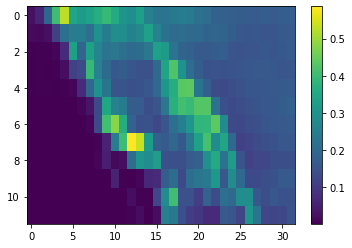

In [110]:
plt.imshow(np.mean(P_snow_frac,axis = 0), aspect = 'auto')
plt.colorbar()

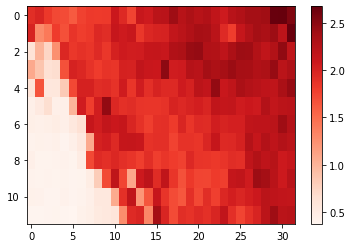

In [111]:
plt.imshow(np.mean(T_heat_waves_mean,axis = 0), aspect = 'auto', cmap = 'Reds')
plt.colorbar()

In [112]:
Npx = Nlat * Nlon
N_heat_waves_mat = np.reshape(N_heat_waves,(Nyears,Npx)).T
T_heat_waves_mat = np.reshape(T_heat_waves_mean,(Nyears,Npx)).T
len_heat_waves_mat = np.reshape(len_heat_waves_mean,(Nyears,Npx)).T
P_total_mat = np.reshape(P_total,(Nyears,Npx)).T
P_snow_frac_mat = np.reshape(P_snow_frac,(Nyears,Npx)).T

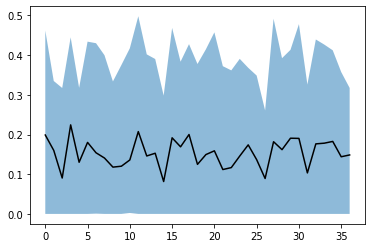

In [113]:
var = N_heat_waves_mat
# var = T_heat_waves_mat
# var = len_heat_waves_mat
var = P_snow_frac_mat

x1 = np.percentile(var, axis = 0, q = 5)
x2 = np.percentile(var, axis = 0, q = 50)
x3 = np.percentile(var, axis = 0, q = 95)

plt.fill_between(x = np.arange(Nyears), y1 = x1, y2 = x3, alpha = 0.5)
plt.plot(x2, 'k')

In [114]:
from sklearn.decomposition import PCA

In [228]:
#prep for clustering

cluster_to_model = 5
print(cluster_names[cluster_to_model])

#average over entire domain
vars = [
        np.mean(N_heat_waves_mat[np.asarray(unique_in_clusters[cluster_to_model]).squeeze(),:], axis = 0),
        np.mean(T_heat_waves_mat[np.asarray(unique_in_clusters[cluster_to_model]).squeeze(),:], axis = 0),
        np.mean(len_heat_waves_mat[np.asarray(unique_in_clusters[cluster_to_model]).squeeze(),:], axis = 0)#,
        # np.mean(P_total_mat[np.asarray(unique_in_clusters[cluster]).squeeze(),:], axis = 0),
        # np.mean(P_snow_frac_mat[np.asarray(unique_in_clusters[cluster]).squeeze(),:], axis = 0)
]
Nvars = len(vars)

#normalize variables
vars_norm = np.zeros((Nyears, Nvars))
for kk_var, var in enumerate(vars):
  vars_norm[:,kk_var] = (var - np.mean(var)) / np.std(var)

#pca on normalized variables
n_components = 3
pca = PCA(n_components = n_components)
PCs = pca.fit_transform(vars_norm)
frac_var = pca.explained_variance_ratio_
eigvecs = pca.components_

cluster_input = PCs

# cluster_input = np.zeros((Nyears, Nvars))
# for kk_var, var in enumerate(vars):
#   cluster_input[:,kk_var] = (var - np.mean(var)) / np.std(var)


North-Eastern


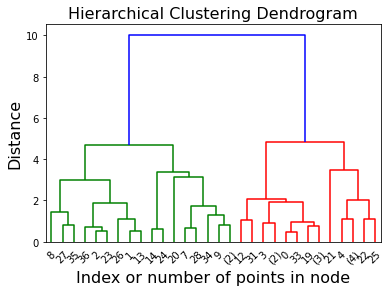

In [229]:
#visualize dendrogram to inform number of clusters

fig, ax = plt.subplots()
linked = linkage(cluster_input, 'ward')
dendrogram(linked, orientation = 'top', distance_sort = 'descending', truncate_mode = 'lastp', p = 30, ax = ax)

ax.set_xlabel("Index or number of points in node", fontsize = 16)
ax.set_ylabel('Distance', fontsize = 16)
ax.set_title('Hierarchical Clustering Dendrogram', fontsize = 16)

plt.show()

In [230]:
#from dendrogram, choose number of clusters and calculate mean pattern of each cluster

n_clusters = 2
clustering = AgglomerativeClustering(n_clusters = n_clusters).fit(cluster_input)

#calculate average of each cluster
cluster_patterns = np.empty((n_clusters, np.shape(cluster_input)[1]))
for cluster in range(n_clusters):
  cluster_inds = np.argwhere(clustering.labels_ == cluster)
  cluster_patterns[cluster,:] = np.mean(cluster_input[cluster_inds.reshape(-1,1),:], axis = 0)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


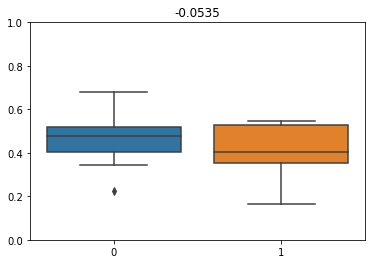

In [231]:
cluster_inds = np.argwhere(seasonal_clustering.labels_ == cluster_to_model).squeeze()
NSE_this_cluster = np.mean(NSE_yearly[:,cluster_inds], axis = -1)

dNSE = np.median(NSE_this_cluster[np.argwhere(clustering.labels_[1:] == 1).squeeze()]) - np.median(NSE_this_cluster[np.argwhere(clustering.labels_[1:] == 0).squeeze()])
dNSE = np.mean(NSE_this_cluster[np.argwhere(clustering.labels_[1:] == 1).squeeze()]) - np.mean(NSE_this_cluster[np.argwhere(clustering.labels_[1:] == 0).squeeze()])

sns.boxplot(clustering.labels_[1:], NSE_this_cluster)
plt.ylim(top = 1, bottom = 0)
plt.title(np.round(dNSE, decimals = 4))

plt.show()

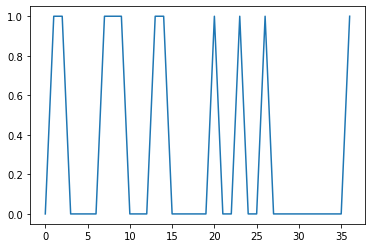

In [218]:
plt.plot(clustering.labels_)

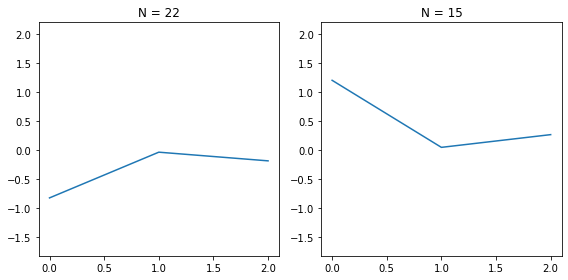

In [195]:
saveIt = 0

nrows = 1
ncols = n_clusters

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (4*ncols, 4*nrows))

for cluster, ax in enumerate(axes.flatten()):
  ax.plot(cluster_patterns[cluster,:])
  ax.set_ylim(bottom = np.min(cluster_patterns) - 1, top = np.max(cluster_patterns) + 1)

  ax.set_title('N = ' + str(int(len(np.argwhere(clustering.labels_==cluster)))))

plt.tight_layout()

if saveIt:
  plt.savefig('heat_wave_prelim.png', bbox_inches = 'tight', dpi = 300)

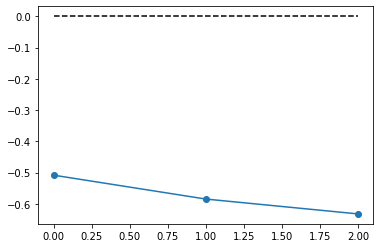

In [196]:
plt.plot(eigvecs[0,:], marker = 'o')
plt.plot([0,2],[0,0], 'k--')

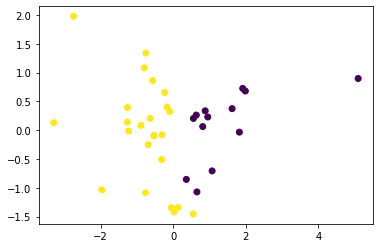

In [179]:
plt.scatter(PCs[:,0], PCs[:,1], c = clustering.labels_)

In [258]:
#prep for clustering

Npx = Nlat*Nlon
cluster_input = np.zeros((Npx,Nyears))
for px in range(Npx):
  cluster_input[px,:] = N_heat_waves_mat[px,:]
  cluster_input[px,:] = T_heat_waves_mat[px,:]
  # cluster_input[px,:] = len_heat_waves_mat[px,:]
  cluster_input[px,:] = P_total_mat[px,:]
  # cluster_input[px,:] = P_snow_frac_mat[px,:]

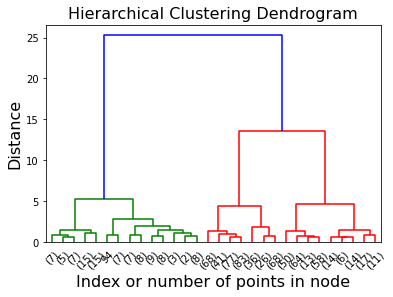

In [259]:
#visualize dendrogram to inform number of clusters

fig, ax = plt.subplots()
linked = linkage(cluster_input, 'ward')
dendrogram(linked, orientation = 'top', distance_sort = 'descending', truncate_mode = 'lastp', p = 30, ax = ax)

ax.set_xlabel("Index or number of points in node", fontsize = 16)
ax.set_ylabel('Distance', fontsize = 16)
ax.set_title('Hierarchical Clustering Dendrogram', fontsize = 16)

plt.show()

In [90]:
#from dendrogram, choose number of clusters and calculate mean pattern of each cluster

n_clusters = 3
clustering = AgglomerativeClustering(n_clusters = n_clusters).fit(cluster_input)

#calculate average of each cluster
cluster_patterns = np.empty((n_clusters, np.shape(cluster_input)[1]))
for cluster in range(n_clusters):
  cluster_inds = np.argwhere(clustering.labels_ == cluster)
  cluster_patterns[cluster,:] = np.mean(cluster_input[cluster_inds.reshape(-1,1),:], axis = 0)

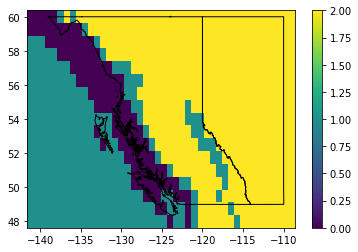

In [91]:
fig, ax = plt.subplots()
im = ax.imshow(clustering.labels_.reshape(Nlat,Nlon), aspect = 'auto', extent = extentERA)
plot_prov_ax(prov = prov, ax = ax)
plt.colorbar(im, ax = ax)

# Community source data

In [ ]:
filename = 'BritishColumbia_Municipal_Water_Supply_Overview_2021_with_sources_fix.csv'
df_sources = pd.read_csv(dir_data + '/' + filename)
df_sources.head()

Name    Status  ... Unnamed: 34  Unnamed: 35
0  100 Mile House  District  ...         NaN          NaN
1      Abbotsford      City  ...         NaN          NaN
2      Abbotsford      City  ...         NaN          NaN
3      Abbotsford      City  ...         NaN          NaN
4       Alert Bay   Village  ...         NaN          NaN

[5 rows x 36 columns]

In [ ]:
communities = [
               'Ashcroft',
               'Chase',
               'Kamloops',
               'Chetwynd',
               'Creston',
               'Dawson Creek',
               'Pouce Coupe',
               'Kitimat',
               'Nelson',
               'Telkwa',
               'Terrace'
]

N_communities = len(communities)
lat_community = np.zeros(N_communities)
lon_community = np.zeros(N_communities)

for kk, community in enumerate(communities):
  sources = df_sources['Name']==community
  lats = df_sources['Municipality Lat']
  lons = df_sources['Municipality Lon']
  lat = lats[sources]
  lon = lons[sources]
  if np.size(lat)>1:
    lat = lat.values
    lon = lon.values
    lat = lat[0]
    lon = lon[0]

  lat_community[kk] = lat
  lon_community[kk] = lon

In [ ]:
stationNames[station_comm_inds]

array([' NORTH THOMPSON RIVER AT MCLURE',
       ' SOUTH THOMPSON RIVER AT CHASE',
       ' THOMPSON RIVER NEAR SPENCES BRIDGE', ' PINE RIVER AT EAST PINE',
       ' ARROW CREEK NEAR ERICKSON', ' KISKATINAW RIVER NEAR FARMINGTON',
       ' KITIMAT RIVER BELOW HIRSCH CREEK', ' ANDERSON CREEK NEAR NELSON',
       ' BULKLEY RIVER AT QUICK', ' SKEENA RIVER AT USK'], dtype=object)

In [ ]:
stationLat[station_comm_inds]

array([53.30642, 51.64947, 51.18802, 56.245  , 49.44847, 55.54217,
       54.60694, 49.20263, 57.90027, 55.42654])

In [ ]:
station_comm_inds

array([ 59,  64,  65,   3,  99,   8,  26, 106,  14,  19])

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:82: ShapelyDeprec

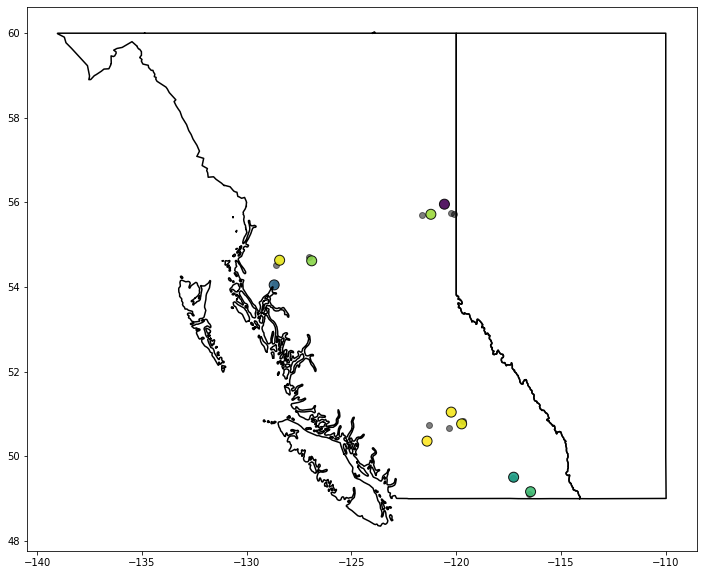

In [ ]:
fig, ax = plt.subplots(figsize = (12,10))
plot_prov_ax(prov = prov, ax = ax)
ax.scatter(lon_community, lat_community, facecolor = 'k', edgecolor = 'k', alpha = 0.5)
ax.scatter(stationLon[stationInds][station_comm_inds], stationLat[stationInds][station_comm_inds], c = NSE_fine[station_comm_inds], edgecolor = 'k', alpha = 0.9, s= 100)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:82: ShapelyDeprec

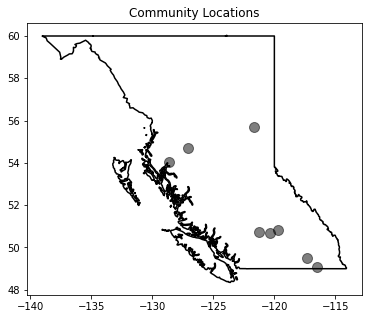

In [ ]:
saveIt = 0
inds = np.array([0,1,2,3,4,7,8,9])
fig, ax = plt.subplots(figsize = (6,5))
plot_prov_ax(prov = ['BC'], ax = ax)
ax.scatter(lon_community[inds], lat_community[inds], facecolor = 'k', edgecolor = 'k', alpha = 0.5, s = 100)
ax.set_title('Community Locations')
# ax.scatter(stationLon[stationInds][station_comm_inds], stationLat[stationInds][station_comm_inds], c = NSE_fine[station_comm_inds], edgecolor = 'k', alpha = 0.9, s= 100)

if saveIt:
  plt.savefig('community_locations.png', dpi = 300, bbox_inches = 'tight')

In [ ]:
np.argwhere((df_sources['Name']=='Kitimat').values).squeeze()

array(97)

# Calculate % Glaciation

In [ ]:
#open RGI data and extract area/locations

rgi_dir = dir_data + '/RGI/'

poly_filename = '02_rgi60_WesternCanadaUS.shp'
polys = gpd.read_file(rgi_dir + poly_filename)
cenLon = polys['CenLon']
cenLat = polys['CenLat']
area = polys['Area']

#for each basin, determine which glaciers are within its watershed boundaries

glacier_points = [Point(lon, lat) for lon, lat in zip(cenLon, cenLat)]
glacier_area_in = np.zeros(len(stationInds))
area_glaciers_in = np.zeros(len(stationInds))
glaciers_in_inds_all = [[] for kk in range(len(stationInds))]

for jj, basin in enumerate(stationBasins): #for each basin, determine which glaciers are within basin boundaries

  if basin is not None: #if basin outline exists (a few small non-glaciated basins do not have outlines)

    glaciers_in = np.zeros(len(cenLon)) #will be binary list of all glaciers: 1 == glacier in this basin, 0 == glacier not in this basin

    for kk, point in enumerate(glacier_points): #for each glacier, determine if within basin boundaries
        glaciers_in[kk] = basin.contains(point)

    glaciers_in_inds = np.squeeze(np.argwhere(glaciers_in))
    area_glaciers_in[jj] = np.sum(area[glaciers_in_inds]) #total area of glaciers which are within the watershed boundaries (in paper: A_glaciers)
    glaciers_in_inds_all[jj] = glaciers_in_inds

#calcualte percentage glaciation (in paper: G = A_glaciers / A_basin)
stationArea = np.array([float(flowDict['stationDrainageArea'][stationInds][kk][1:]) for kk in range(len(stationInds))]) #(in paper: A_basin)
stationPG = area_glaciers_in / stationArea #(in paper: G)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:82: ShapelyDeprec

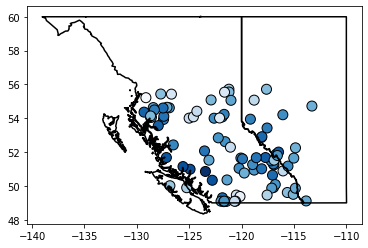

In [ ]:
#visualize percentage glaciation in space

fig, ax = plt.subplots()
plot_prov_ax(prov, ax)
plt.scatter(stationLon[stationInds], stationLat[stationInds], c = np.log(stationPG), edgecolor = 'k', s = 100, cmap = 'Blues')

In [ ]:
Nstations = len(stationInds)

glacier_classes = 3*np.ones(Nstations)
glacier_classes[stationPG<=0.1] = 2
glacier_classes[stationPG<=0.01] = 1
glacier_classes[stationPG==0] = 0

glacier_classes_names = ['$G=0$',
                         '$0<G\leq1\%$',
                         '$1\%<G\leq10\%$',
                         '$10\%<G\leq100\%$']

rgbs_glacier = np.array([[148, 210, 189],
                         [11, 170, 173],
                         [0, 95, 115],
                         [0, 18, 25]]) / 255

# Heat wave: different years

In [ ]:
#load all models for easier use later on
models = [[None for cluster in range(n_clusters_seasonal)] for run in range(Nruns)] 
for run in range(Nruns):
  for cluster in range(n_clusters_seasonal):
    filename_model = 'model_fine_' + str(run) + '_cluster_' + str(cluster) + '.h5'
    models[run][cluster] = tf.keras.models.load_model(dir_models + '/' + filename_model)

In [ ]:
#construct test predictor/target tensors -- here we won't make the train/validate predictor/target tensors to save memory; we will analyze the test period

Nyears = 37
years = np.arange(10)
Nyears_predict = len(years)
Ndays_predict = 365
Nruns = 10
batch_size = 128
nchannels = 3 

y_predict_perturb_all = np.zeros((Ndays_predict, Nstations, Nyears_predict, Nruns))
y_predict_all = np.zeros((Ndays_predict, Nstations, Nyears_predict, Nruns))

for year in years:

  print('Year: ' + str(year+1) + ' / ' + str(Nyears_predict))

  #predictor data
  x = np.empty((Ndays_predict, 365,) + np.shape(Tmaxnorm)[1:] + (nchannels,),dtype=np.float16)
  x_perturb = np.empty((Ndays_predict, 365,) + np.shape(Tmaxnorm)[1:] + (nchannels,),dtype=np.float16)

  #first, make (n_time x n_lon x n_lat x n_channels) tensor -- will be used to form weather videos 
  x_intermediate = np.empty(np.shape(Tmaxnorm) + (nchannels,),dtype='single')
  x_intermediate[:,:,:,0] = Tmaxnorm
  x_intermediate[:,:,:,1] = Tminnorm
  x_intermediate[:,:,:,2] = Pnorm

  leap_adjust = np.zeros(Nyears, dtype = 'int')
  leap_adjust[np.mod(range(Nyears),4)==1] = 1
  leap_adjust = np.cumsum(leap_adjust)
  hot_days = np.array([np.arange(150,160)+365*kk + leap_adjust[kk] for kk in range(Nyears)]).reshape(-1,)
  hot_anomaly_degrees = 10
  Tmax_anomaly = hot_anomaly_degrees / Tmaxstd_train
  Tmin_anomaly = hot_anomaly_degrees / Tminstd_train
  perturb = np.zeros(np.shape(x_intermediate))
  perturb[hot_days,:,:,0] = Tmax_anomaly
  perturb[hot_days,:,:,1] = Tmin_anomaly

  x_intermediate_perturb = x_intermediate + perturb

  #testing
  for ii in range(Ndays_predict):
    x[ii] = x_intermediate[ii + 365*year : ii + 365*(year+1)]
    x_perturb[ii] = x_intermediate_perturb[ii + 365*year : ii + 365*(year+1)]

  #convert predict/target arrays to tensors
  x = tf.convert_to_tensor(x)
  x_perturb = tf.convert_to_tensor(x_perturb)

  for run in range(Nruns):

    print('\tRun: ' + str(run))

    for cluster in range(n_clusters_seasonal):

      print('\t\tCluster: ' + str(cluster))

      #prep model
      inds = np.argwhere(seasonal_clustering.labels_ == cluster).squeeze()
      filename_model = 'model_fine_' + str(run) + '_cluster_' + str(cluster) + '.h5'
      # model = tf.keras.models.load_model(dir_models + '/' + filename_model)
      model = models[run][cluster]

      #predict perturbed (hot)
      y_predict_perturb_all[:,inds,year,run] = model.predict(x_perturb, batch_size = batch_size)
      y_predict_all[:,inds,year,run] = model.predict(x, batch_size = batch_size)

y_predict_perturb = np.mean(y_predict_perturb_all, axis = -1)
y_predict = np.mean(y_predict_all, axis = -1)

Year: 1 / 10
	Run: 0
		Cluster: 0
		Cluster: 1
		Cluster: 2
		Cluster: 3
		Cluster: 4
		Cluster: 5
	Run: 1
		Cluster: 0
		Cluster: 1
		Cluster: 2
		Cluster: 3
		Cluster: 4
		Cluster: 5
	Run: 2
		Cluster: 0
		Cluster: 1
		Cluster: 2
		Cluster: 3
		Cluster: 4
		Cluster: 5
	Run: 3
		Cluster: 0
		Cluster: 1
		Cluster: 2
		Cluster: 3
		Cluster: 4
		Cluster: 5
	Run: 4
		Cluster: 0
		Cluster: 1
		Cluster: 2
		Cluster: 3
		Cluster: 4
		Cluster: 5
	Run: 5
		Cluster: 0
		Cluster: 1
		Cluster: 2
		Cluster: 3
		Cluster: 4
		Cluster: 5
	Run: 6
		Cluster: 0
		Cluster: 1
		Cluster: 2
		Cluster: 3
		Cluster: 4
		Cluster: 5
	Run: 7
		Cluster: 0
		Cluster: 1
		Cluster: 2
		Cluster: 3
		Cluster: 4
		Cluster: 5
	Run: 8
		Cluster: 0
		Cluster: 1
		Cluster: 2
		Cluster: 3
		Cluster: 4
		Cluster: 5
	Run: 9
		Cluster: 0
		Cluster: 1
		Cluster: 2
		Cluster: 3
		Cluster: 4
		Cluster: 5
Year: 2 / 10
	Run: 0
		Cluster: 0
		Cluster: 1
		Cluster: 2
		Cluster: 3
		Cluster: 4
		Cluster: 5
	Run: 1
		Cluster: 0
		Clust

3 minutes first year (loading all models first time); 10 runs  
2 minutes for second year, and subsequent years (10 runs) 
~1 hour 15 minutes for one heat wave, 37 years
15 hours for 12 heat waves

19m 20s for 1 heat wave, 10 runs, 10 years, loading models each time  

~1.1 - 1.25 min/year for 10 runs  
40 - 45 min / heat wave (37 years)  
8 - 9 hours for 12 heat waves  

In [ ]:
#save

save_data = 0

if save_data:

  dir_data_temp = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/data/temporary'
  yy_perturb = np.reshape(np.transpose(y_predict_perturb, [2,0,1]), (Nyears_predict * 365, Nstations)) 
  yy = np.reshape(np.transpose(y_predict, [2,0,1]), (Nyears_predict * 365, Nstations)) 

  filename_perturb = 'y_predict_perturb_' + str(Nruns) + 'runs_' + str(Nyears_predict) + 'years.csv'
  filename = 'y_predict_' + str(Nruns) + 'runs_' + str(Nyears_predict) + 'years.csv'

  np.savetxt(dir_data_temp + '/' + filename, yy, delimiter = ',')
  np.savetxt(dir_data_temp + '/' + filename_perturb, yy_perturb, delimiter = ',')

In [ ]:
load_data = 1

if load_data:

  filename_perturb = 'y_predict_perturb_' + str(Nruns) + 'runs_' + str(Nyears_predict) + 'years.csv'
  filename = 'y_predict_' + str(Nruns) + 'runs_' + str(Nyears_predict) + 'years.csv'

  yy_perturb = pd.read_csv(dir_data_temp + '/' + filename_perturb, header = None).values
  yy = pd.read_csv(dir_data_temp + '/' + filename, header = None).values

  y_predict_perturb = np.reshape(yy_perturb, (Nyears_predict, Ndays_predict, Nstations)).transpose([1,2,0])
  y_predict = np.reshape(yy, (Nyears_predict, Ndays_predict, Nstations)).transpose([1,2,0])

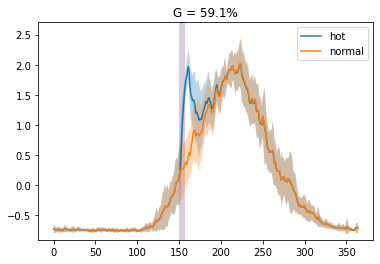

In [ ]:
#mean and variability

station = 71

fig, ax = plt.subplots()

x1 = np.mean(y_predict_perturb[:, station, :], axis = -1)
x2 = np.mean(y_predict[:,station, :], axis = -1)

x3 = np.std(y_predict_perturb[:, station, :], axis = -1)
x4 = np.std(y_predict[:,station, :], axis = -1)

top = np.max([x1+x3,x2+x4])*1.1
bottom = np.min([x1-x3,x2-x4])*1.1

extent_heat = [np.min(hot_days), np.min(hot_days)+7, bottom, top]
ax.imshow(heat_shade, extent = extent_heat, alpha = 0.2, aspect = 'auto', label = 'Heat wave')

ax.plot(x1, label = 'hot')
ax.plot(x2, label = 'normal')

ax.fill_between(x = range(365), y1 = x1+x3, y2 = x1-x3, alpha = 0.3)
ax.fill_between(x = range(365), y1 = x2+x4, y2 = x2-x4, alpha = 0.3)

ax.set_title('G = ' + str(np.round(stationPG[station]*100, decimals = 1)) + '%')

ax.legend()

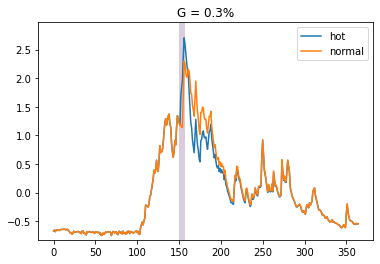

In [ ]:
station = 4
year = 0

fig, ax = plt.subplots()

x1 = y_predict_perturb[:, station, year]
x2 = y_predict[:,station, year]

top = np.max([x1,x2])*1.1
bottom = np.min([x1,x2])*1.1

extent_heat = [np.min(hot_days), np.min(hot_days)+7, bottom, top]
ax.imshow(heat_shade, extent = extent_heat, alpha = 0.2, aspect = 'auto', label = 'Heat wave')

ax.plot(x1, label = 'hot')
ax.plot(x2, label = 'normal')
ax.set_title('G = ' + str(np.round(stationPG[station]*100, decimals = 1)) + '%')

ax.legend()


# Heat wave: rolling, different years

In [ ]:
#load all models for easier use later on
Nruns = 10
models = [[None for cluster in range(n_clusters_seasonal)] for run in range(Nruns)] 
for run in range(Nruns):
  for cluster in range(n_clusters_seasonal):
    filename_model = 'model_fine_' + str(run) + '_cluster_' + str(cluster) + '.h5'
    models[run][cluster] = tf.keras.models.load_model(dir_models + '/' + filename_model)

KeyboardInterrupt: ignored

In [ ]:
Nyears = 36
Nyears_predict = 36
years = np.arange(Nyears_predict)
Ndays_predict = 365
Nruns = 10

days_start = np.arange(0,350,30)
heat_wave_duration = 7
days_fin = days_start + heat_wave_duration
N_heat_waves = len(days_start)

In [ ]:
#construct test predictor/target tensors -- here we won't make the train/validate predictor/target tensors to save memory; we will analyze the test period

Nyears = 36
Nyears_predict = 36
years = np.arange(Nyears_predict)
Ndays_predict = 365
Nruns = 10

days_start = np.arange(0,350,30)
heat_wave_duration = 7
days_fin = days_start + heat_wave_duration
N_heat_waves = len(days_start)

batch_size = 64
nchannels = 3 

y_predict_perturb_all = np.zeros((Ndays_predict, Nstations, N_heat_waves, Nyears_predict, Nruns))
y_predict_all = np.zeros((Ndays_predict, Nstations, Nyears_predict, Nruns))

y_predict_heat_waves = np.zeros((Ndays_predict, Nstations,N_heat_waves, Nyears_predict))

#first, make (n_time x n_lon x n_lat x n_channels) tensor -- will be used to form weather videos 
x_intermediate = np.empty(np.shape(Tmaxnorm) + (nchannels,),dtype='single')
x_intermediate[:,:,:,0] = Tmaxnorm
x_intermediate[:,:,:,1] = Tminnorm
x_intermediate[:,:,:,2] = Pnorm

leap_adjust = np.zeros(Nyears, dtype = 'int')
leap_adjust[np.mod(range(Nyears),4)==1] = 1
leap_adjust = np.cumsum(leap_adjust)

for year in years:

  print('Year: ' + str(year+1) + ' / ' + str(Nyears_predict))

  for kk, (day_start, day_fin) in enumerate(zip(days_start, days_fin)):
    
    print('\tHeat wave: ' + str(kk))

    #predictor data
    x = np.empty((Ndays_predict, 365,) + np.shape(Tmaxnorm)[1:] + (nchannels,),dtype=np.float16)
    x_perturb = np.empty((Ndays_predict, 365,) + np.shape(Tmaxnorm)[1:] + (nchannels,),dtype=np.float16)

    hot_days = np.array([np.arange(day_start,day_fin)+365*kk + leap_adjust[kk] for kk in range(Nyears)]).reshape(-1,)
    hot_anomaly_degrees = 10

    Tmax_anomaly = hot_anomaly_degrees / Tmaxstd_train
    Tmin_anomaly = hot_anomaly_degrees / Tminstd_train

    perturb = np.zeros(np.shape(x_intermediate))
    perturb[hot_days,:,:,0] = Tmax_anomaly
    perturb[hot_days,:,:,1] = Tmin_anomaly

    x_intermediate_perturb = x_intermediate + perturb

    #testing
    for ii in range(Ndays_predict):
      x[ii] = x_intermediate[ii + 365*year : ii + 365*(year+1)]
      x_perturb[ii] = x_intermediate_perturb[ii + 365*year : ii + 365*(year+1)]

    #convert predict/target arrays to tensors
    x = tf.convert_to_tensor(x)
    x_perturb = tf.convert_to_tensor(x_perturb)

    for run in range(Nruns):

      print('\t\tRun: ' + str(run))

      for cluster in range(n_clusters_seasonal):

        # print('\t\t\tCluster: ' + str(cluster))

        #prep model
        inds = np.argwhere(seasonal_clustering.labels_ == cluster).squeeze()
        filename_model = 'model_fine_' + str(run) + '_cluster_' + str(cluster) + '.h5'
        # model = tf.keras.models.load_model(dir_models + '/' + filename_model)
        model = models[run][cluster]

        #predict perturbed (hot)
        y_predict_perturb_all[:,inds,kk,year,run] = model.predict(x_perturb, batch_size = batch_size)
        if kk == 0:
          y_predict_all[:,inds,year,run] = model.predict(x, batch_size = batch_size)

  print(hpy().heapu())

y_predict_perturb = np.mean(y_predict_perturb_all, axis = -1)
y_predict = np.mean(y_predict_all, axis = -1)
y_predict_heat_waves = y_predict_perturb

3.5 minutes for 7 years, 4 heat waves, 1 run
40 sec for 1 year, 4 heat waves, 1 run == 7min for 10 runs, 260 min for 37 years, 12 hours for 

In [ ]:
#save

save_data = 0

if save_data:

  yy = np.reshape(np.transpose(y_predict, [2,0,1]), (Nyears_predict * 365, Nstations)) 
  filename = 'y_predict_' + str(Nruns) + 'runs_' + str(Nyears_predict) + 'years.csv'
  np.savetxt(dir_data_temp + '/' + filename, yy, delimiter = ',')

  for heat_wave in range(N_heat_waves):

    yy_perturb = np.reshape(np.transpose(y_predict_perturb[:,:,heat_wave,:], [2,0,1]), (Nyears_predict * 365, Nstations)) 
    filename_perturb = 'y_predict_perturb_' + str(Nruns) + 'runs_' + str(Nyears_predict) + 'years_heatwave' + str(heat_wave) + '.csv'
    np.savetxt(dir_data_temp + '/' + filename_perturb, yy_perturb, delimiter = ',')

In [ ]:
load_data = 1

if load_data:

  y_predict_perturb = np.zeros((Ndays_predict, Nstations, N_heat_waves, Nyears_predict))

  filename = 'y_predict_' + str(Nruns) + 'runs_' + str(Nyears_predict) + 'years.csv'
  yy = pd.read_csv(dir_data_temp + '/' + filename, header = None).values
  y_predict = np.reshape(yy, (Nyears_predict, Ndays_predict, Nstations)).transpose([1,2,0])

  for heat_wave in range(N_heat_waves):
    filename_perturb = 'y_predict_perturb_' + str(Nruns) + 'runs_' + str(Nyears_predict) + 'years_heatwave' + str(heat_wave) + '.csv'
    yy_perturb = pd.read_csv(dir_data_temp + '/' + filename_perturb, header = None).values
    y_predict_perturb[:,:,heat_wave,:] = np.reshape(yy_perturb, (Nyears_predict, Ndays_predict, Nstations)).transpose([1,2,0])
  
  y_predict_heat_waves = y_predict_perturb

In [ ]:
max_diffs = np.zeros((Nstations, N_heat_waves, Nyears_predict))
min_diffs = np.zeros((Nstations, N_heat_waves, Nyears_predict))

Ndays_high = np.zeros((Nstations, N_heat_waves, Nyears_predict))
Ndays_low = np.zeros((Nstations, N_heat_waves, Nyears_predict))

for year in range(Nyears_predict):

  max_diffs[:,:,year] = np.max(y_predict_heat_waves[:,:,:,year] - np.expand_dims(y_predict[:,:,year], axis = -1), axis = 0)
  min_diffs[:,:,year] = np.min(y_predict_heat_waves[:,:,:,year] - np.expand_dims(y_predict[:,:,year], axis = -1), axis = 0)

for station in range(Nstations):
  for month in range(12):
    for year in range(Nyears_predict):
      x1 = y_predict_heat_waves[:,station,month,year] - y_predict[:,station,year]
      max_diff = max_diffs[station,month,year]
      min_diff = min_diffs[station,month,year]
      Ndays_high[station,month,year] = len(np.argwhere(x1 > max_diff / 2))
      Ndays_low[station,month,year] = len(np.argwhere(x1 < min_diff / 2))

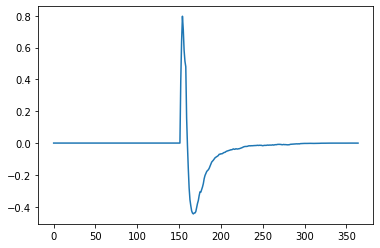

In [ ]:
station = 0
x1 = y_predict_heat_waves[:,station,5,0] - y_predict[:,station,0]

max_diff = np.max(x1)
min_diff = np.min(x1)

Ndays_high = len(np.argwhere(x1 > max_diff / 2))
Ndays_low = len(np.argwhere(x1 < min_diff / 2))

plt.plot(x1)

In [ ]:
Ndays_high, Ndays_low

(6, 19)

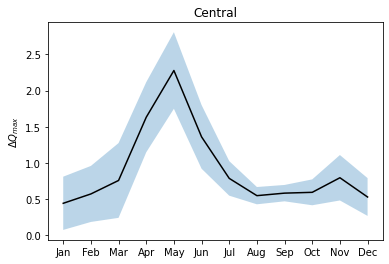

In [ ]:
cluster = 0

inds = np.argwhere(seasonal_clustering.labels_ == cluster).squeeze()

x1 = np.mean(np.mean(max_diffs[inds,:,:], axis = 0), axis = -1)
x2 = np.std(np.mean(max_diffs[inds,:,:], axis = 0), axis = -1)

fig, ax = plt.subplots()

ax.fill_between(range(N_heat_waves), y1 = x1+x2, y2 = x1-x2, alpha = 0.3)
ax.plot(x1, 'k')

ax.set_xticks(range(12))
ax.set_xticklabels(months_str)

ax.set_ylabel('$\Delta Q_{max}$')
ax.set_title(cluster_names[cluster])

plt.show()

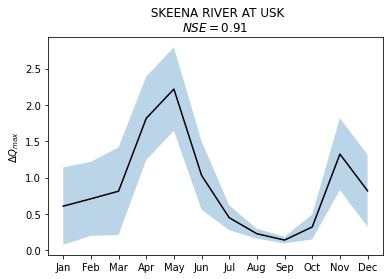

In [ ]:
ind = station_comm_inds[9]

x1 = np.mean(max_diffs[ind,:,:], axis = -1)
x2 = np.std(max_diffs[ind,:,:], axis = -1)

fig, ax = plt.subplots()

ax.fill_between(range(N_heat_waves), y1 = x1+x2, y2 = x1-x2, alpha = 0.3)
ax.plot(x1, 'k')

ax.set_xticks(range(12))
ax.set_xticklabels(months_str)

ax.set_ylabel('$\Delta Q_{max}$')
ax.set_title(stationNames[ind] + '\n$NSE = $' + str(np.round(NSE_fine[ind], decimals = 2)))

plt.show()

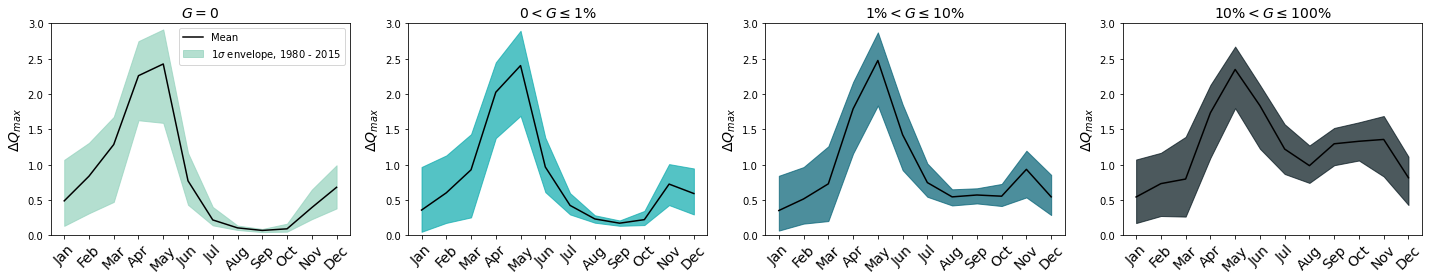

In [ ]:
saveIt = 0

glacier_class = 3

fs = 14

ncols = 4
nrows = 1
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (5*ncols, 4*nrows))

for glacier_class, ax in enumerate(axes.flatten()):#range(4):

  inds = np.argwhere((glacier_classes == glacier_class) & (NSE_fine > 0.7)).squeeze()

  x1 = np.mean(np.mean(max_diffs[inds,:,:], axis = 0), axis = -1)
  x2 = np.std(np.mean(max_diffs[inds,:,:], axis = 0), axis = -1)

  ax.fill_between(range(N_heat_waves), y1 = x1+x2, y2 = x1-x2, alpha = 0.7, label = '1$\sigma$ envelope, 1980 - 2015', color = rgbs_glacier[glacier_class,:])
  ax.plot(x1, 'k', label = 'Mean')

  ax.set_xticks(range(12))
  ax.set_xticklabels(months_str, fontsize = fs, rotation = 45)
  ax.set_ylabel('$\Delta Q_{max}$', fontsize = fs)
  ax.set_title(glacier_classes_names[glacier_class], fontsize = fs)
  ax.set_ylim(bottom = 0, top = 3)

  if glacier_class == 0:
    ax.legend()

plt.tight_layout()

if saveIt:
  plt.savefig('deltaQmax_variability.png', dpi = 300, bbox_inches = 'tight')

plt.show()

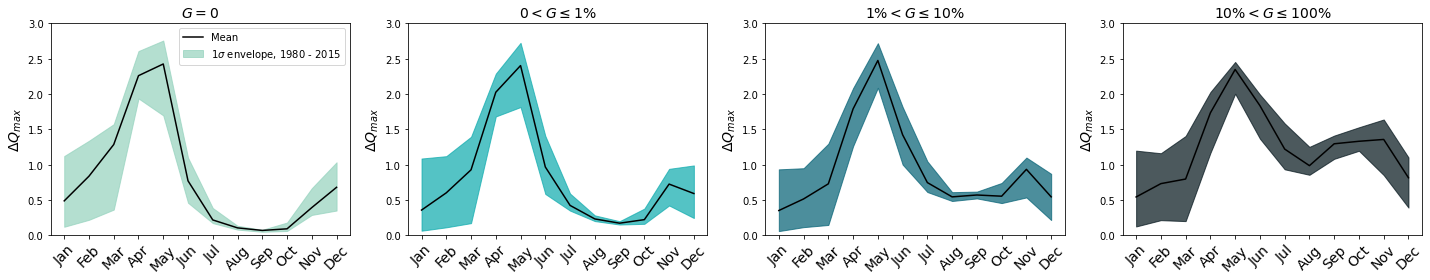

In [ ]:
saveIt = 0

glacier_class = 3

fs = 14

ncols = 4
nrows = 1
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (5*ncols, 4*nrows))

for glacier_class, ax in enumerate(axes.flatten()):#range(4):

  inds = np.argwhere((glacier_classes == glacier_class) & (NSE_fine > 0.7)).squeeze()

  x1 = np.median(np.mean(max_diffs[inds,:,:], axis = 0), axis = -1)
  x2 = np.percentile(np.mean(max_diffs[inds,:,:], axis = 0), q = 16, axis = -1)
  x3 = np.percentile(np.mean(max_diffs[inds,:,:], axis = 0), q = 84, axis = -1)

  ax.fill_between(range(N_heat_waves), y1 = x2, y2 = x3, alpha = 0.7, label = '1$\sigma$ envelope, 1980 - 2015', color = rgbs_glacier[glacier_class,:])
  ax.plot(x1, 'k', label = 'Mean')

  ax.set_xticks(range(12))
  ax.set_xticklabels(months_str, fontsize = fs, rotation = 45)
  ax.set_ylabel('$\Delta Q_{max}$', fontsize = fs)
  ax.set_title(glacier_classes_names[glacier_class], fontsize = fs)
  ax.set_ylim(bottom = 0, top = 3)

  if glacier_class == 0:
    ax.legend()

plt.tight_layout()

if saveIt:
  plt.savefig('deltaQmax_variability.png', dpi = 300, bbox_inches = 'tight')

plt.show()

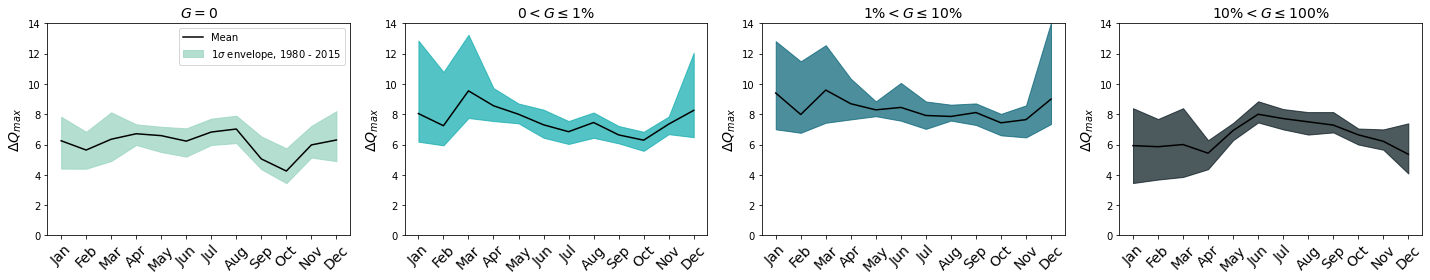

In [ ]:
#high days from heat wave (heat wave longevity)

saveIt = 0

glacier_class = 3

fs = 14

ncols = 4
nrows = 1
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (5*ncols, 4*nrows))

for glacier_class, ax in enumerate(axes.flatten()):#range(4):

  inds = np.argwhere((glacier_classes == glacier_class) & (NSE_fine > 0.7)).squeeze()

  x1 = np.median(np.mean(Ndays_high[inds,:,:], axis = 0), axis = -1)
  x2 = np.percentile(np.mean(Ndays_high[inds,:,:], axis = 0), q = 16, axis = -1)
  x3 = np.percentile(np.mean(Ndays_high[inds,:,:], axis = 0), q = 84, axis = -1)

  ax.fill_between(range(N_heat_waves), y1 = x2, y2 = x3, alpha = 0.7, label = '1$\sigma$ envelope, 1980 - 2015', color = rgbs_glacier[glacier_class,:])
  ax.plot(x1, 'k', label = 'Mean')

  ax.set_xticks(range(12))
  ax.set_xticklabels(months_str, fontsize = fs, rotation = 45)
  ax.set_ylabel('$\Delta Q_{max}$', fontsize = fs)
  ax.set_title(glacier_classes_names[glacier_class], fontsize = fs)
  ax.set_ylim(bottom = 0, top = 14)

  if glacier_class == 0:
    ax.legend()

plt.tight_layout()

if saveIt:
  plt.savefig('deltaQmax_variability.png', dpi = 300, bbox_inches = 'tight')

plt.show()

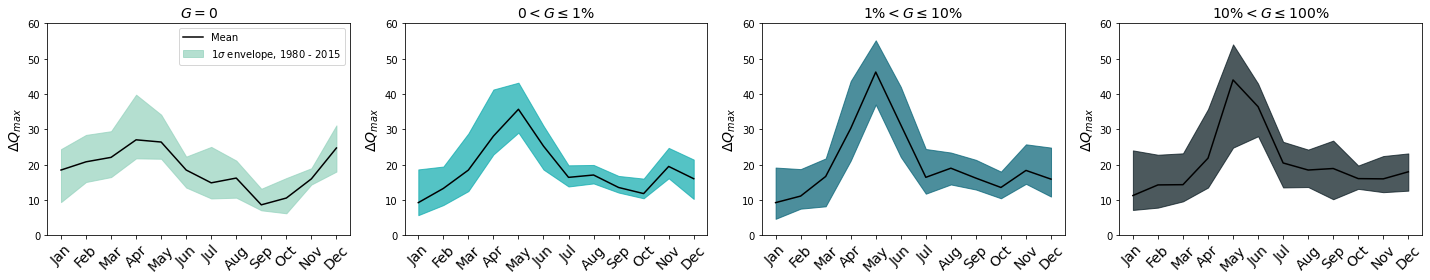

In [ ]:
#low days from heat wave (heat wave debt longevity)

saveIt = 0

glacier_class = 3

fs = 14

ncols = 4
nrows = 1
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (5*ncols, 4*nrows))

for glacier_class, ax in enumerate(axes.flatten()):#range(4):

  inds = np.argwhere((glacier_classes == glacier_class) & (NSE_fine > 0.7)).squeeze()

  x1 = np.median(np.mean(Ndays_low[inds,:,:], axis = 0), axis = -1)
  x2 = np.percentile(np.mean(Ndays_low[inds,:,:], axis = 0), q = 16, axis = -1)
  x3 = np.percentile(np.mean(Ndays_low[inds,:,:], axis = 0), q = 84, axis = -1)

  ax.fill_between(range(N_heat_waves), y1 = x2, y2 = x3, alpha = 0.7, label = '1$\sigma$ envelope, 1980 - 2015', color = rgbs_glacier[glacier_class,:])
  ax.plot(x1, 'k', label = 'Mean')

  ax.set_xticks(range(12))
  ax.set_xticklabels(months_str, fontsize = fs, rotation = 45)
  ax.set_ylabel('$\Delta Q_{max}$', fontsize = fs)
  ax.set_title(glacier_classes_names[glacier_class], fontsize = fs)
  ax.set_ylim(bottom = 0, top = 60)

  if glacier_class == 0:
    ax.legend()

plt.tight_layout()

if saveIt:
  plt.savefig('deltaQmax_variability.png', dpi = 300, bbox_inches = 'tight')

plt.show()

In [ ]:
#calculate hottest and coldest overall years

Nyears_hot_cold = 10

Tmax_yearly = np.array([np.mean(Tmax[start:start+365,:,:]) for start in np.arange(365,len(Tmax)-1,365)])
Tmin_yearly = np.array([np.mean(Tmin[start:start+365,:,:]) for start in np.arange(365,len(Tmax)-1,365)])
Tmean_yearly = np.mean([Tmax_yearly,Tmin_yearly], axis = 0)

hot_years = np.argsort(Tmean_yearly[:-1])[-Nyears_hot_cold:].squeeze()
cold_years = np.argsort(Tmean_yearly[:-1])[:Nyears_hot_cold].squeeze()

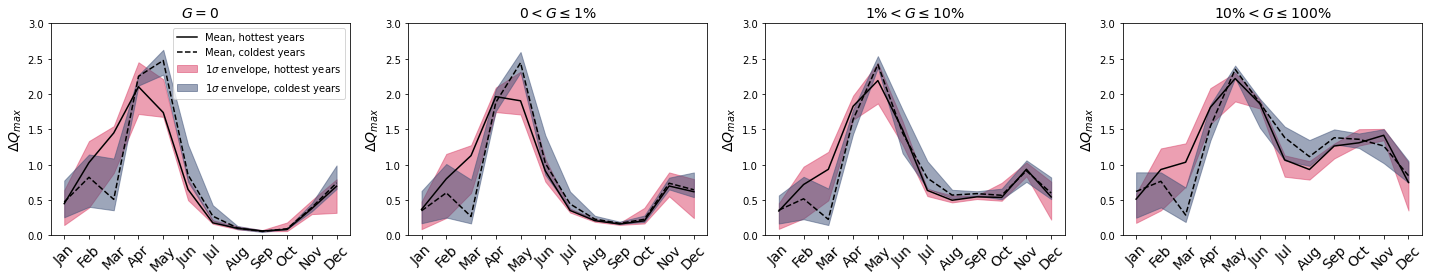

In [ ]:
#hot years: max_diffs

saveIt = 0

rgbs_hot_cold = np.array([
                          [218, 65, 103],
                          [60, 79, 118]
])/255 #hot, then cold (red, then blue)

p1 = 25
p2 = 75

fs = 14

ncols = 4
nrows = 1
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (5*ncols, 4*nrows))

for glacier_class, ax in enumerate(axes.flatten()):#range(4):

  inds = np.argwhere((glacier_classes == glacier_class) & (NSE_fine > 0.7)).squeeze()

  var = max_diffs[:,:,hot_years]
  x1 = np.median(np.mean(var[inds,:,:], axis = 0), axis = -1)
  x2 = np.percentile(np.mean(var[inds,:,:], axis = 0), q = p1, axis = -1)
  x3 = np.percentile(np.mean(var[inds,:,:], axis = 0), q = p2, axis = -1)
  ax.fill_between(range(N_heat_waves), y1 = x2, y2 = x3, alpha = 0.5, label = '1$\sigma$ envelope, hottest years', color = rgbs_hot_cold[0,:])
  ax.plot(x1, color = 'k', label = 'Mean, hottest years')

  var = max_diffs[:,:,cold_years]
  x1 = np.median(np.mean(var[inds,:,:], axis = 0), axis = -1)
  x2 = np.percentile(np.mean(var[inds,:,:], axis = 0), q = p1, axis = -1)
  x3 = np.percentile(np.mean(var[inds,:,:], axis = 0), q = p2, axis = -1)
  ax.fill_between(range(N_heat_waves), y1 = x2, y2 = x3, alpha = 0.5, label = '1$\sigma$ envelope, coldest years', color = rgbs_hot_cold[1,:])
  ax.plot(x1, 'k--', label = 'Mean, coldest years')

  ax.set_xticks(range(12))
  ax.set_xticklabels(months_str, fontsize = fs, rotation = 45)
  ax.set_ylabel('$\Delta Q_{max}$', fontsize = fs)
  ax.set_title(glacier_classes_names[glacier_class], fontsize = fs)
  ax.set_ylim(bottom = 0, top = 3)

  if glacier_class == 0:
    ax.legend()

plt.tight_layout()

if saveIt:
  plt.savefig('deltaQmax_variability.png', dpi = 300, bbox_inches = 'tight')

plt.show()

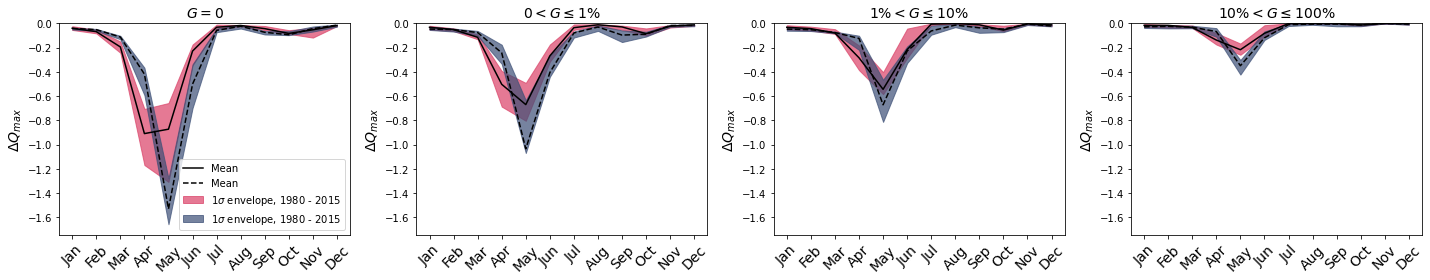

In [ ]:
#hot years: min_diffs

saveIt = 0

rgbs_hot_cold = np.array([
                          [218, 65, 103],
                          [60, 79, 118]
])/255 #hot, then cold (red, then blue)

p1 = 25
p2 = 75

fs = 14

ncols = 4
nrows = 1
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (5*ncols, 4*nrows))

for glacier_class, ax in enumerate(axes.flatten()):#range(4):

  inds = np.argwhere((glacier_classes == glacier_class) & (NSE_fine > 0.7)).squeeze()

  # x1 = np.median(np.mean(max_diffs[inds,:,:], axis = 0), axis = -1)
  # x2 = np.percentile(np.mean(max_diffs[inds,:,:], axis = 0), q = 16, axis = -1)
  # x3 = np.percentile(np.mean(max_diffs[inds,:,:], axis = 0), q = 84, axis = -1)
  # ax.fill_between(range(N_heat_waves), y1 = x2, y2 = x3, alpha = 0.7, label = '1$\sigma$ envelope, 1980 - 2015', color = rgbs_glacier[glacier_class,:])
  # ax.plot(x1, 'k', label = 'Mean')

  var = min_diffs[:,:,hot_years]
  x1 = np.median(np.mean(var[inds,:,:], axis = 0), axis = -1)
  x2 = np.percentile(np.mean(var[inds,:,:], axis = 0), q = p1, axis = -1)
  x3 = np.percentile(np.mean(var[inds,:,:], axis = 0), q = p2, axis = -1)
  ax.fill_between(range(N_heat_waves), y1 = x2, y2 = x3, alpha = 0.7, label = '1$\sigma$ envelope, 1980 - 2015', color = rgbs_hot_cold[0,:])
  ax.plot(x1, 'k', label = 'Mean')

  var = min_diffs[:,:,cold_years]
  x1 = np.median(np.mean(var[inds,:,:], axis = 0), axis = -1)
  x2 = np.percentile(np.mean(var[inds,:,:], axis = 0), q = p1, axis = -1)
  x3 = np.percentile(np.mean(var[inds,:,:], axis = 0), q = p2, axis = -1)
  ax.fill_between(range(N_heat_waves), y1 = x2, y2 = x3, alpha = 0.7, label = '1$\sigma$ envelope, 1980 - 2015', color = rgbs_hot_cold[1,:])
  ax.plot(x1, 'k--', label = 'Mean')

  ax.set_xticks(range(12))
  ax.set_xticklabels(months_str, fontsize = fs, rotation = 45)
  ax.set_ylabel('$\Delta Q_{max}$', fontsize = fs)
  ax.set_title(glacier_classes_names[glacier_class], fontsize = fs)
  ax.set_ylim(bottom = -1.75, top = 0)

  if glacier_class == 0:
    ax.legend()

plt.tight_layout()

if saveIt:
  plt.savefig('deltaQmax_variability.png', dpi = 300, bbox_inches = 'tight')

plt.show()

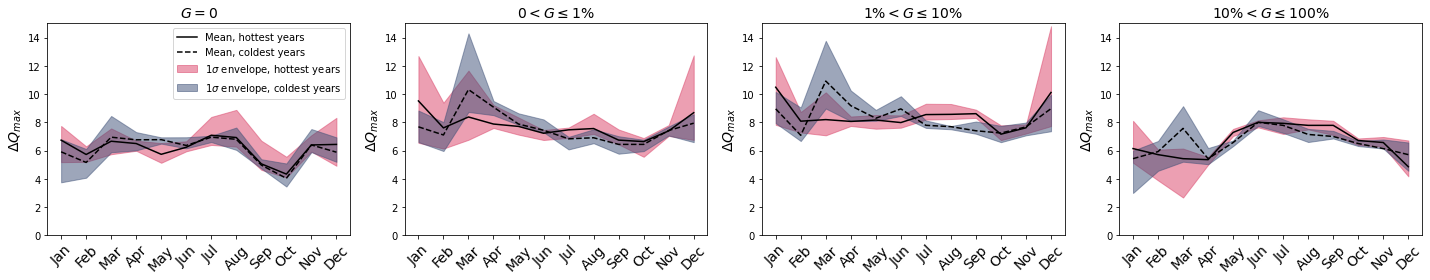

In [ ]:
#hot years: length of initial response

saveIt = 0

rgbs_hot_cold = np.array([
                          [218, 65, 103],
                          [60, 79, 118]
])/255 #hot, then cold (red, then blue)

p1 = 25
p2 = 75

fs = 14

ncols = 4
nrows = 1
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (5*ncols, 4*nrows))

for glacier_class, ax in enumerate(axes.flatten()):#range(4):

  inds = np.argwhere((glacier_classes == glacier_class) & (NSE_fine > 0.7)).squeeze()

  var = Ndays_high[:,:,hot_years]
  x1 = np.median(np.mean(var[inds,:,:], axis = 0), axis = -1)
  x2 = np.percentile(np.mean(var[inds,:,:], axis = 0), q = p1, axis = -1)
  x3 = np.percentile(np.mean(var[inds,:,:], axis = 0), q = p2, axis = -1)
  ax.fill_between(range(N_heat_waves), y1 = x2, y2 = x3, alpha = 0.5, label = '1$\sigma$ envelope, hottest years', color = rgbs_hot_cold[0,:])
  ax.plot(x1, color = 'k', label = 'Mean, hottest years')

  var = Ndays_high[:,:,cold_years]
  x1 = np.median(np.mean(var[inds,:,:], axis = 0), axis = -1)
  x2 = np.percentile(np.mean(var[inds,:,:], axis = 0), q = p1, axis = -1)
  x3 = np.percentile(np.mean(var[inds,:,:], axis = 0), q = p2, axis = -1)
  ax.fill_between(range(N_heat_waves), y1 = x2, y2 = x3, alpha = 0.5, label = '1$\sigma$ envelope, coldest years', color = rgbs_hot_cold[1,:])
  ax.plot(x1, 'k--', label = 'Mean, coldest years')

  ax.set_xticks(range(12))
  ax.set_xticklabels(months_str, fontsize = fs, rotation = 45)
  ax.set_ylabel('$\Delta Q_{max}$', fontsize = fs)
  ax.set_title(glacier_classes_names[glacier_class], fontsize = fs)
  ax.set_ylim(bottom = 0, top = 15)

  if glacier_class == 0:
    ax.legend()

plt.tight_layout()

if saveIt:
  plt.savefig('deltaQmax_variability.png', dpi = 300, bbox_inches = 'tight')

plt.show()

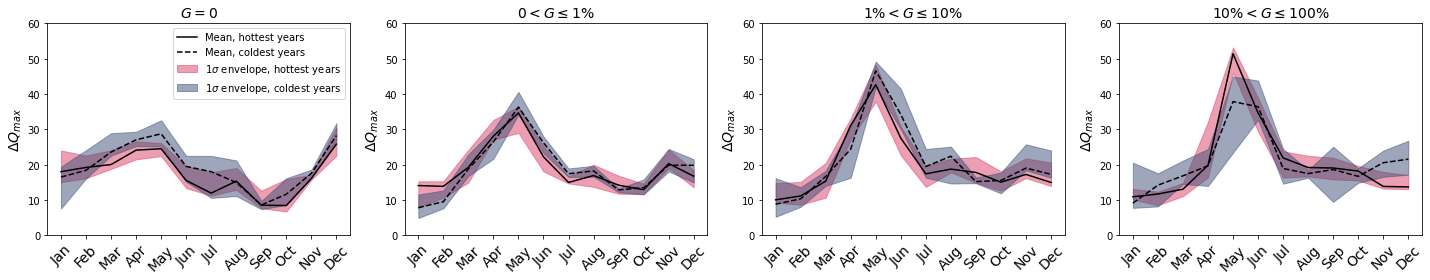

In [ ]:
#hot years: length of delayed response

saveIt = 0

rgbs_hot_cold = np.array([
                          [218, 65, 103],
                          [60, 79, 118]
])/255 #hot, then cold (red, then blue)

p1 = 25
p2 = 75

fs = 14

ncols = 4
nrows = 1
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (5*ncols, 4*nrows))

for glacier_class, ax in enumerate(axes.flatten()):#range(4):

  inds = np.argwhere((glacier_classes == glacier_class) & (NSE_fine > 0.7)).squeeze()

  var = Ndays_low[:,:,hot_years]
  x1 = np.median(np.mean(var[inds,:,:], axis = 0), axis = -1)
  x2 = np.percentile(np.mean(var[inds,:,:], axis = 0), q = p1, axis = -1)
  x3 = np.percentile(np.mean(var[inds,:,:], axis = 0), q = p2, axis = -1)
  ax.fill_between(range(N_heat_waves), y1 = x2, y2 = x3, alpha = 0.5, label = '1$\sigma$ envelope, hottest years', color = rgbs_hot_cold[0,:])
  ax.plot(x1, color = 'k', label = 'Mean, hottest years')

  var = Ndays_low[:,:,cold_years]
  x1 = np.median(np.mean(var[inds,:,:], axis = 0), axis = -1)
  x2 = np.percentile(np.mean(var[inds,:,:], axis = 0), q = p1, axis = -1)
  x3 = np.percentile(np.mean(var[inds,:,:], axis = 0), q = p2, axis = -1)
  ax.fill_between(range(N_heat_waves), y1 = x2, y2 = x3, alpha = 0.5, label = '1$\sigma$ envelope, coldest years', color = rgbs_hot_cold[1,:])
  ax.plot(x1, 'k--', label = 'Mean, coldest years')

  ax.set_xticks(range(12))
  ax.set_xticklabels(months_str, fontsize = fs, rotation = 45)
  ax.set_ylabel('$\Delta Q_{max}$', fontsize = fs)
  ax.set_title(glacier_classes_names[glacier_class], fontsize = fs)
  ax.set_ylim(bottom = 0, top = 60)

  if glacier_class == 0:
    ax.legend()

plt.tight_layout()

if saveIt:
  plt.savefig('deltaQmax_variability.png', dpi = 300, bbox_inches = 'tight')

plt.show()

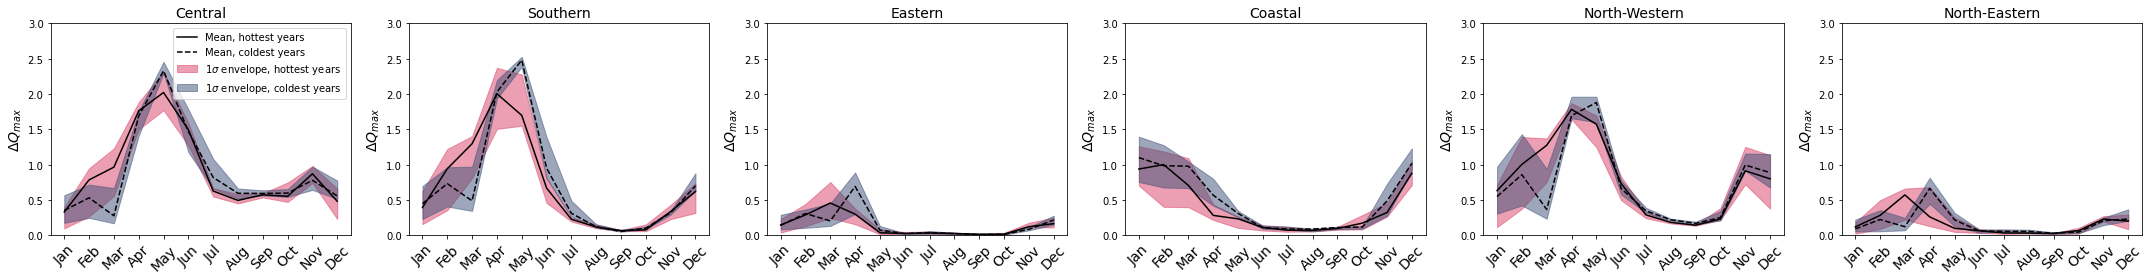

In [ ]:
#hot years: max_diffs

saveIt = 0

rgbs_hot_cold = np.array([
                          [218, 65, 103],
                          [60, 79, 118]
])/255 #hot, then cold (red, then blue)

p1 = 25
p2 = 75

fs = 14

ncols = 6
nrows = 1
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (5*ncols, 4*nrows))

for glacier_class, ax in enumerate(axes.flatten()):#range(4):

  inds = np.argwhere((seasonal_clustering.labels_ == glacier_class)).squeeze()# & (NSE_fine > 0.7)).squeeze()

  var = max_diffs[:,:,hot_years]
  x1 = np.median(np.mean(var[inds,:,:], axis = 0), axis = -1)
  x2 = np.percentile(np.mean(var[inds,:,:], axis = 0), q = p1, axis = -1)
  x3 = np.percentile(np.mean(var[inds,:,:], axis = 0), q = p2, axis = -1)
  ax.fill_between(range(N_heat_waves), y1 = x2, y2 = x3, alpha = 0.5, label = '1$\sigma$ envelope, hottest years', color = rgbs_hot_cold[0,:])
  ax.plot(x1, color = 'k', label = 'Mean, hottest years')

  var = max_diffs[:,:,cold_years]
  x1 = np.median(np.mean(var[inds,:,:], axis = 0), axis = -1)
  x2 = np.percentile(np.mean(var[inds,:,:], axis = 0), q = p1, axis = -1)
  x3 = np.percentile(np.mean(var[inds,:,:], axis = 0), q = p2, axis = -1)
  ax.fill_between(range(N_heat_waves), y1 = x2, y2 = x3, alpha = 0.5, label = '1$\sigma$ envelope, coldest years', color = rgbs_hot_cold[1,:])
  ax.plot(x1, 'k--', label = 'Mean, coldest years')

  ax.set_xticks(range(12))
  ax.set_xticklabels(months_str, fontsize = fs, rotation = 45)
  ax.set_ylabel('$\Delta Q_{max}$', fontsize = fs)
  ax.set_title(cluster_names[glacier_class], fontsize = fs)
  ax.set_ylim(bottom = 0, top = 3)

  if glacier_class == 0:
    ax.legend()

plt.tight_layout()

if saveIt:
  plt.savefig('deltaQmax_variability.png', dpi = 300, bbox_inches = 'tight')

plt.show()

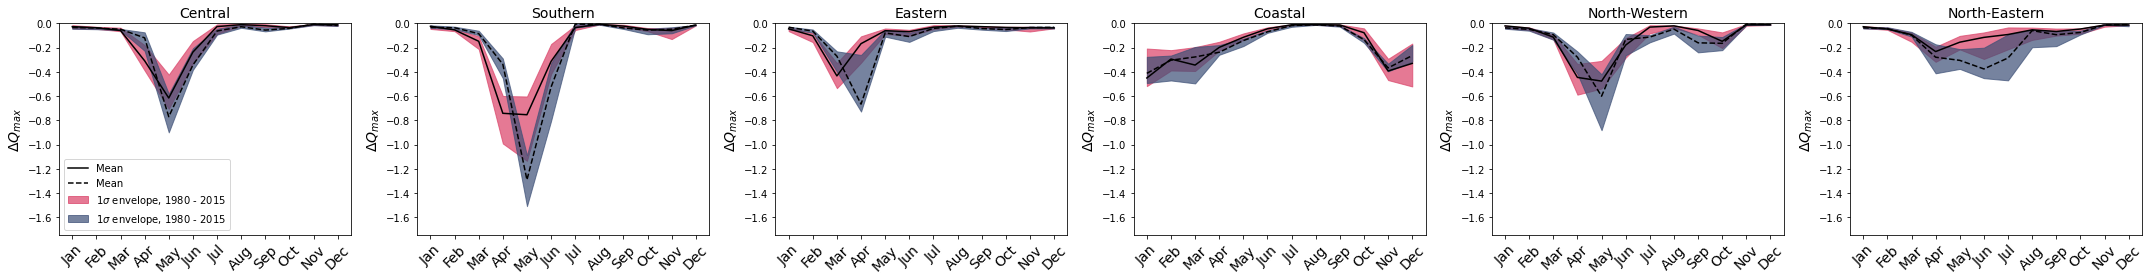

In [ ]:
#hot years: min_diffs

saveIt = 0

rgbs_hot_cold = np.array([
                          [218, 65, 103],
                          [60, 79, 118]
])/255 #hot, then cold (red, then blue)

p1 = 25
p2 = 75

fs = 14

ncols = 6
nrows = 1
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (5*ncols, 4*nrows))

for glacier_class, ax in enumerate(axes.flatten()):#range(4):

  inds = np.argwhere((seasonal_clustering.labels_ == glacier_class)).squeeze()# & (NSE_fine > 0.7)).squeeze()

  # x1 = np.median(np.mean(max_diffs[inds,:,:], axis = 0), axis = -1)
  # x2 = np.percentile(np.mean(max_diffs[inds,:,:], axis = 0), q = 16, axis = -1)
  # x3 = np.percentile(np.mean(max_diffs[inds,:,:], axis = 0), q = 84, axis = -1)
  # ax.fill_between(range(N_heat_waves), y1 = x2, y2 = x3, alpha = 0.7, label = '1$\sigma$ envelope, 1980 - 2015', color = rgbs_glacier[glacier_class,:])
  # ax.plot(x1, 'k', label = 'Mean')

  var = min_diffs[:,:,hot_years]
  x1 = np.median(np.mean(var[inds,:,:], axis = 0), axis = -1)
  x2 = np.percentile(np.mean(var[inds,:,:], axis = 0), q = p1, axis = -1)
  x3 = np.percentile(np.mean(var[inds,:,:], axis = 0), q = p2, axis = -1)
  ax.fill_between(range(N_heat_waves), y1 = x2, y2 = x3, alpha = 0.7, label = '1$\sigma$ envelope, 1980 - 2015', color = rgbs_hot_cold[0,:])
  ax.plot(x1, 'k', label = 'Mean')

  var = min_diffs[:,:,cold_years]
  x1 = np.median(np.mean(var[inds,:,:], axis = 0), axis = -1)
  x2 = np.percentile(np.mean(var[inds,:,:], axis = 0), q = p1, axis = -1)
  x3 = np.percentile(np.mean(var[inds,:,:], axis = 0), q = p2, axis = -1)
  ax.fill_between(range(N_heat_waves), y1 = x2, y2 = x3, alpha = 0.7, label = '1$\sigma$ envelope, 1980 - 2015', color = rgbs_hot_cold[1,:])
  ax.plot(x1, 'k--', label = 'Mean')

  ax.set_xticks(range(12))
  ax.set_xticklabels(months_str, fontsize = fs, rotation = 45)
  ax.set_ylabel('$\Delta Q_{max}$', fontsize = fs)
  ax.set_title(cluster_names[glacier_class], fontsize = fs)
  ax.set_ylim(bottom = -1.75, top = 0)

  if glacier_class == 0:
    ax.legend()

plt.tight_layout()

if saveIt:
  plt.savefig('deltaQmax_variability.png', dpi = 300, bbox_inches = 'tight')

plt.show()

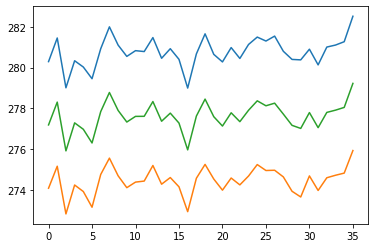

In [ ]:
plt.plot(Tmax_yearly[:-1])
plt.plot(Tmin_yearly[:-1])
plt.plot(Tmean_yearly[:-1])

In [ ]:
np.sort(Tmean_yearly[:-1])
hot_years = np.argsort(Tmean_yearly[:-1])[-10:]
cold_years = np.argsort(Tmean_yearly[:-1])[:10]
np.median(hot_years), np.median(cold_years)

(24.5, 15.5)

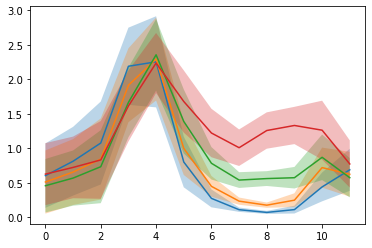

In [ ]:
glacier_class = 3

for glacier_class in range(4):

  inds = np.argwhere((glacier_classes == glacier_class) & (NSE_fine > 0.7)).squeeze()

  x1 = np.mean(np.mean(max_diffs[inds,:,:], axis = 0), axis = -1)
  x2 = np.std(np.mean(max_diffs[inds,:,:], axis = 0), axis = -1)

  plt.plot(x1)
  plt.fill_between(range(N_heat_waves), y1 = x1+x2, y2 = x1-x2, alpha = 0.3)

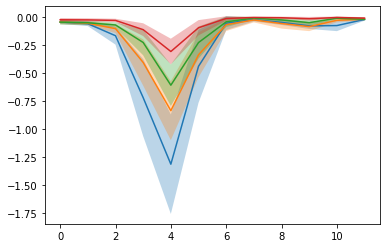

In [ ]:
#min diffs

for glacier_class in range(4):

  inds = np.argwhere((glacier_classes == glacier_class) & (NSE_fine > 0.7)).squeeze()

  x1 = np.mean(np.mean(min_diffs[inds,:,:], axis = 0), axis = -1)
  x2 = np.std(np.mean(min_diffs[inds,:,:], axis = 0), axis = -1)

  plt.plot(x1)
  plt.fill_between(range(N_heat_waves), y1 = x1+x2, y2 = x1-x2, alpha = 0.3)

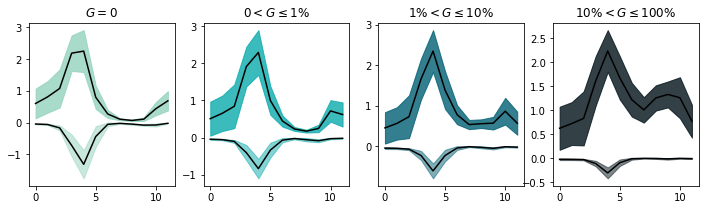

In [ ]:
rgbs_glacier = np.array([[148, 210, 189],
                         [11, 170, 173],
                         [0, 95, 115],
                         [0, 18, 25]]) / 255

nrows = 1
ncols = 4

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (3*ncols, 3*nrows))

for glacier_class, ax in enumerate(axes.flatten()):

  inds = np.argwhere((glacier_classes == glacier_class) & (NSE_fine > 0.7)).squeeze()

  x1 = np.mean(np.mean(max_diffs[inds,:,:], axis = 0), axis = -1)
  # x1 = 0
  x2 = np.std(np.mean(max_diffs[inds,:,:], axis = 0), axis = -1)
  x3 = np.mean(np.mean(min_diffs[inds,:,:], axis = 0), axis = -1)
  # x3 = 0
  x4 = np.std(np.mean(min_diffs[inds,:,:], axis = 0), axis = -1)

  ax.fill_between(range(N_heat_waves), y1 = x1+x2, y2 = x1-x2, alpha = 0.8, color = rgbs_glacier[glacier_class,:])
  ax.plot(x1, color = 'k')

  ax.fill_between(range(N_heat_waves), y1 = x3+x4, y2 = x3-x4, alpha = 0.5, color = rgbs_glacier[glacier_class,:])
  ax.plot(x3, color = 'k')

  ax.set_title(glacier_classes_names[glacier_class])

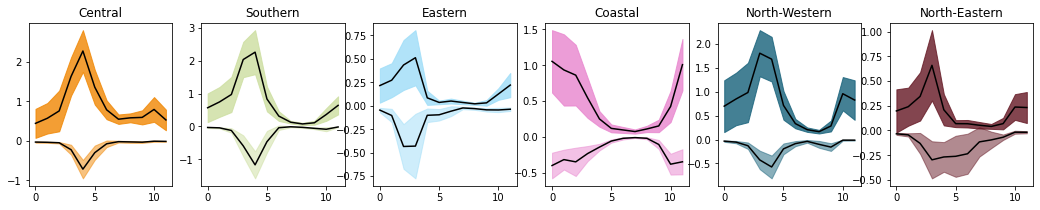

In [ ]:
nrows = 1
ncols = 6

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (3*ncols, 3*nrows))

for cluster, ax in enumerate(axes.flatten()):

  inds = np.argwhere((seasonal_clustering.labels_ == cluster) & (NSE_fine > 0.0)).squeeze()

  x1 = np.mean(np.mean(max_diffs[inds,:,:], axis = 0), axis = -1)
  x2 = np.std(np.mean(max_diffs[inds,:,:], axis = 0), axis = -1)
  x3 = np.mean(np.mean(min_diffs[inds,:,:], axis = 0), axis = -1)
  x4 = np.std(np.mean(min_diffs[inds,:,:], axis = 0), axis = -1)

  # x1 = 0
  # x3 = 0

  ax.fill_between(range(N_heat_waves), y1 = x1+x2, y2 = x1-x2, alpha = 0.8, color = rgbs_array[cluster,:])
  ax.plot(x1, color = 'k')

  ax.fill_between(range(N_heat_waves), y1 = x3+x4, y2 = x3-x4, alpha = 0.5, color = rgbs_array[cluster,:])
  ax.plot(x3, color = 'k')

  ax.set_title(cluster_names[cluster])

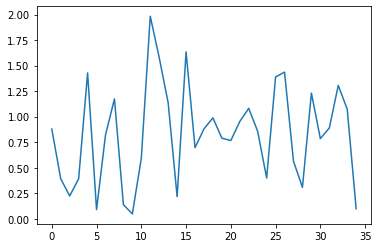

In [ ]:
glacier_class = 0
heat_wave = 1
inds = np.argwhere((glacier_classes == glacier_class) & (NSE_fine > 0.7)).squeeze()
x1 = np.mean(max_diffs[inds,heat_wave,:-1], axis = 0)

plt.plot(x1)

Text(0.5, 1.0, 'Central')

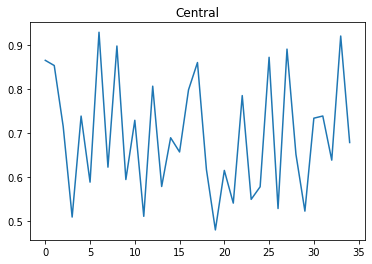

In [ ]:
cluster = 0
heat_wave = 9
inds = np.argwhere((seasonal_clustering.labels_ == cluster) & (NSE_fine > 0.7)).squeeze()
x1 = np.mean(max_diffs[inds,heat_wave,:-1], axis = 0)

plt.plot(x1)
plt.title(cluster_names[cluster])

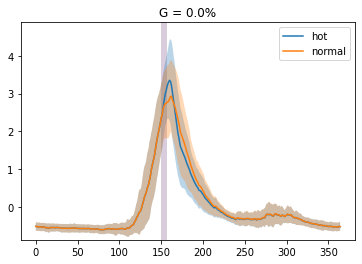

In [ ]:
#mean and variability

station = 0
heat_wave = 5

fig, ax = plt.subplots()

x1 = np.mean(y_predict_perturb[:, station, heat_wave, :], axis = -1)
x2 = np.mean(y_predict[:,station, :], axis = -1)

x3 = np.std(y_predict_perturb[:, station, heat_wave, :], axis = -1)
x4 = np.std(y_predict[:,station, :], axis = -1)

top = np.max([x1+x3,x2+x4])*1.1
bottom = np.min([x1-x3,x2-x4])*1.1

extent_heat = [days_start[heat_wave], days_start[heat_wave]+7, bottom, top]
ax.imshow(heat_shade, extent = extent_heat, alpha = 0.2, aspect = 'auto', label = 'Heat wave')

ax.plot(x1, label = 'hot')
ax.plot(x2, label = 'normal')

ax.fill_between(x = range(365), y1 = x1+x3, y2 = x1-x3, alpha = 0.3)
ax.fill_between(x = range(365), y1 = x2+x4, y2 = x2-x4, alpha = 0.3)

ax.set_title('G = ' + str(np.round(stationPG[station]*100, decimals = 1)) + '%')

ax.legend()

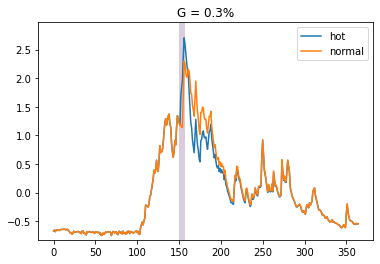

In [ ]:
station = 4
year = 0

fig, ax = plt.subplots()

x1 = y_predict_perturb[:, station, year]
x2 = y_predict[:,station, year]

top = np.max([x1,x2])*1.1
bottom = np.min([x1,x2])*1.1

extent_heat = [np.min(hot_days), np.min(hot_days)+7, bottom, top]
ax.imshow(heat_shade, extent = extent_heat, alpha = 0.2, aspect = 'auto', label = 'Heat wave')

ax.plot(x1, label = 'hot')
ax.plot(x2, label = 'normal')
ax.set_title('G = ' + str(np.round(stationPG[station]*100, decimals = 1)) + '%')

ax.legend()


# Heat wave: different years, non-stationary climate

In [ ]:
#construct test predictor/target tensors -- here we won't make the train/validate predictor/target tensors to save memory; we will analyze the test period

Nyears = 36
years = np.arange(36)
Nyears_predict = len(years)
Ndays_predict = 365
Nruns = 1

batch_size = 64
nchannels = 3 

#load all models for easier use later on
models = [[None for cluster in range(n_clusters_seasonal)] for run in range(Nruns)] 
for run in range(Nruns):
  for cluster in range(n_clusters_seasonal):
    filename_model = 'model_fine_' + str(run) + '_cluster_' + str(cluster) + '.h5'
    models[run][cluster] = tf.keras.models.load_model(dir_models + '/' + filename_model)

#temp anomalies to add to all days
T_background_anomalies = np.array([0,2])
N_background_anomalies = len(T_background_anomalies)
Tmax_background_anomalies = T_background_anomalies / Tmaxstd_train
Tmin_background_anomalies = T_background_anomalies / Tminstd_train

#temp anomaly to define heat wave
leap_adjust = np.zeros(Nyears, dtype = 'int')
leap_adjust[np.mod(range(Nyears),4)==1] = 1
leap_adjust = np.cumsum(leap_adjust)
hot_days = np.array([np.arange(150,157)+365*kk + leap_adjust[kk] for kk in range(Nyears)]).reshape(-1,)
hot_anomaly_degrees = 10
Tmax_anomaly = hot_anomaly_degrees / Tmaxstd_train
Tmin_anomaly = hot_anomaly_degrees / Tminstd_train

y_predict_perturb_all = np.zeros((Ndays_predict, Nstations, Nyears_predict, N_background_anomalies, Nruns))
y_predict_all = np.zeros((Ndays_predict, Nstations, Nyears_predict, N_background_anomalies, Nruns))

for kk, (Tmax_background_anomaly, Tmin_background_anomaly) in enumerate(zip(Tmax_background_anomalies, Tmin_background_anomalies)):

  print('Background perturbation: ' + str(kk))

  #first, make (n_time x n_lon x n_lat x n_channels) tensor -- will be used to form weather videos 
  x_intermediate = np.empty(np.shape(Tmaxnorm) + (nchannels,),dtype='single')
  x_intermediate[:,:,:,0] = Tmaxnorm
  x_intermediate[:,:,:,1] = Tminnorm
  x_intermediate[:,:,:,2] = Pnorm

  perturb_heat_wave = np.zeros(np.shape(x_intermediate))
  perturb_heat_wave[hot_days,:,:,0] = Tmax_anomaly
  perturb_heat_wave[hot_days,:,:,1] = Tmin_anomaly

  perturb_background = np.zeros(np.shape(x_intermediate))
  perturb_background[:,:,:,0] += Tmax_background_anomaly
  perturb_background[:,:,:,1] += Tmin_background_anomaly

  x_intermediate_heat_wave_background = x_intermediate + perturb_heat_wave + perturb_background
  x_intermediate_background = x_intermediate + perturb_background

  for year in years:

    print('\tYear: ' + str(year+1) + ' / ' + str(Nyears_predict))

    #predictor data
    x_heat_wave_background = np.empty((Ndays_predict, 365,) + np.shape(Tmaxnorm)[1:] + (nchannels,),dtype=np.float16)
    x_background = np.empty((Ndays_predict, 365,) + np.shape(Tmaxnorm)[1:] + (nchannels,),dtype=np.float16)

    #testing
    for ii in range(Ndays_predict):
      x_background[ii] = x_intermediate_background[ii + 365*year : ii + 365*(year+1)]
      x_heat_wave_background[ii] = x_intermediate_heat_wave_background[ii + 365*year : ii + 365*(year+1)]

    #convert predict/target arrays to tensors
    x_background = tf.convert_to_tensor(x_background)
    x_heat_wave_background = tf.convert_to_tensor(x_heat_wave_background)

    for run in range(Nruns):

      print('\t\tRun: ' + str(run))

      for cluster in range(n_clusters_seasonal):

        print('\t\t\tCluster: ' + str(cluster))

        #prep model
        inds = np.argwhere(seasonal_clustering.labels_ == cluster).squeeze()
        filename_model = 'model_fine_' + str(run) + '_cluster_' + str(cluster) + '.h5'
        model = models[run][cluster]

        #predict perturbed (hot)
        y_predict_perturb_all[:,inds,year,kk,run] = model.predict(x_heat_wave_background, batch_size = batch_size)
        y_predict_all[:,inds,year,kk,run] = model.predict(x_background, batch_size = batch_size)
        
    print(hpy().heapu())

y_predict_perturb = np.mean(y_predict_perturb_all, axis = -1)
y_predict = np.mean(y_predict_all, axis = -1)

Background perturbation: 0
	Year: 1 / 36
		Run: 0
			Cluster: 0
			Cluster: 1
			Cluster: 2
			Cluster: 3
			Cluster: 4
			Cluster: 5
Partition of a set of 86066 objects. Total size = 23000771 bytes.
 Index  Count   %     Size   % Cumulative  % Type
     0   2208   3 12846464  56  12846464  56 array.array
     1  19830  23  5242584  23  18089048  79 dict
     2  18847  22  1206208   5  19295256  84 shapely.geometry.polygon.Polygon
     3  19045  22   609420   3  19904676  87 int
     4   6229   7   548152   2  20452828  89 builtins.weakref
     5   6331   7   506480   2  20959308  91 types.BuiltinMethodType
     6   2210   3   442000   2  21401308  93 memoryview
     7    459   1   354808   2  21756116  95 set
     8   2210   3   318240   1  22074356  96 builtins.managedbuffer
     9    688   1   314200   1  22388556  97 type
<163 more rows. Type e.g. '_.more' to view.>
	Year: 2 / 36
		Run: 0
			Cluster: 0
			Cluster: 1
			Cluster: 2
			Cluster: 3
			Cluster: 4
			Cluster: 5
Partition 

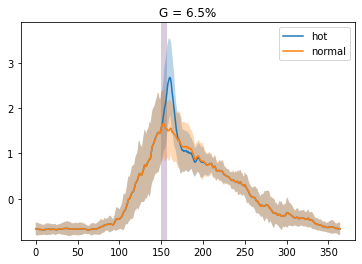

In [ ]:
#mean and variability

station = 101
background = 1

fig, ax = plt.subplots()

x1 = np.mean(y_predict_perturb[:, station, :, background], axis = 1)
x2 = np.mean(y_predict[:,station, :, background], axis = 1)

x3 = np.std(y_predict_perturb[:, station, :, background], axis = 1)
x4 = np.std(y_predict[:,station, :, background], axis = 1)

top = np.max([x1+x3,x2+x4])*1.1
bottom = np.min([x1-x3,x2-x4])*1.1

extent_heat = [np.min(hot_days), np.min(hot_days)+7, bottom, top]
ax.imshow(heat_shade, extent = extent_heat, alpha = 0.2, aspect = 'auto', label = 'Heat wave')

ax.plot(x1, label = 'hot')
ax.plot(x2, label = 'normal')

ax.fill_between(x = range(365), y1 = x1+x3, y2 = x1-x3, alpha = 0.3)
ax.fill_between(x = range(365), y1 = x2+x4, y2 = x2-x4, alpha = 0.3)

ax.set_title('G = ' + str(np.round(stationPG[station]*100, decimals = 1)) + '%')

ax.legend()

In [ ]:
max_diffs = np.zeros((Nstations, N_background_anomalies, Nyears_predict))
min_diffs = np.zeros((Nstations, N_background_anomalies, Nyears_predict))

for year in range(Nyears_predict):

  max_diffs[:,:,year] = np.max(y_predict_perturb[:,:,year,:] - y_predict[:,:,year,:], axis = 0)
  min_diffs[:,:,year] = np.min(y_predict_perturb[:,:,year,:] - y_predict[:,:,year,:], axis = 0)

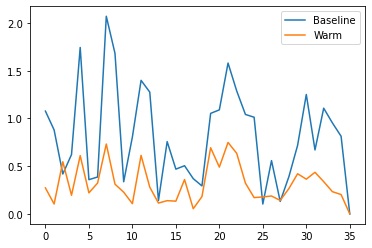

In [ ]:
station = 0

x1 = max_diffs[station,0,:]
x2 = max_diffs[station,1,:]

plt.plot(x1, label = 'Baseline')
plt.plot(x2, label = 'Warm')
plt.legend()

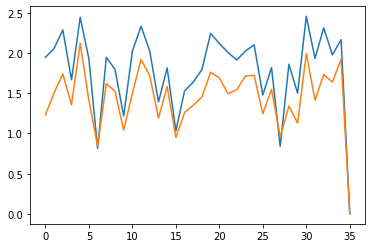

In [ ]:
glacier_class = 3

inds = np.argwhere((glacier_classes == glacier_class) & (NSE_fine > 0.7))

x1 = np.mean(max_diffs[inds,0,:], axis = 0).squeeze()
x2 = np.mean(max_diffs[inds,1,:], axis = 0).squeeze()

plt.plot(x1)
plt.plot(x2)

plt.show()

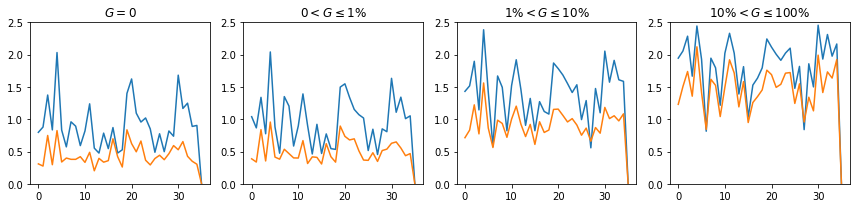

In [ ]:
ncols = 4
nrows = 1

fig, axes = plt.subplots(nrows = 1, ncols = 4, figsize = (3*ncols, 3*nrows))

for glacier_class, ax in enumerate(axes.flatten()):

  inds = np.argwhere((glacier_classes == glacier_class) & (NSE_fine > 0.7))

  x1 = np.mean(max_diffs[inds,0,:], axis = 0).squeeze()
  x2 = np.mean(max_diffs[inds,1,:], axis = 0).squeeze()

  ax.plot(x1)
  ax.plot(x2)
  ax.set_title(glacier_classes_names[glacier_class])
  ax.set_ylim(top = 2.5, bottom = 0.)

plt.tight_layout()

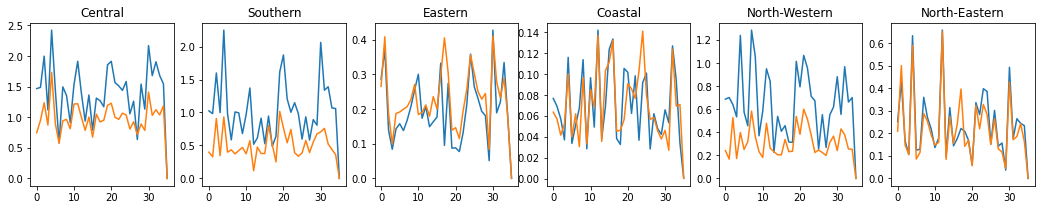

In [ ]:
ncols = 6
nrows = 1

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (3*ncols, 3*nrows))

for cluster, ax in enumerate(axes.flatten()):

  inds = np.argwhere((seasonal_clustering.labels_ == cluster) & (NSE_fine > 0.3))

  x1 = np.mean(max_diffs[inds,0,:], axis = 0).squeeze()
  x2 = np.mean(max_diffs[inds,1,:], axis = 0).squeeze()

  ax.plot(x1)
  ax.plot(x2)
  ax.set_title(cluster_names[cluster])

  # ax.set_ylim(bottom = 0, top = 2.5)

# Heat wave: rolling, different years, non-stationary climate

In [ ]:
#construct test predictor/target tensors -- here we won't make the train/validate predictor/target tensors to save memory; we will analyze the test period

Nyears = 36
Nyears_predict = 36
years = np.arange(Nyears_predict)
Ndays_predict = 365
Nruns = 1

# #load all models for easier use later on
# models = [[None for cluster in range(n_clusters_seasonal)] for run in range(Nruns)] 
# for run in range(Nruns):
#   for cluster in range(n_clusters_seasonal):
#     filename_model = 'model_fine_' + str(run) + '_cluster_' + str(cluster) + '.h5'
#     models[run][cluster] = tf.keras.models.load_model(dir_models + '/' + filename_model)

#define heat wave timing
days_start = np.arange(0,350,30)
heat_wave_duration = 7
days_fin = days_start + heat_wave_duration
N_heat_waves = len(days_start)

#temp anomalies to add to all days
T_background_anomalies = np.array([0,2])
N_background_anomalies = len(T_background_anomalies)
Tmax_background_anomalies = T_background_anomalies / Tmaxstd_train
Tmin_background_anomalies = T_background_anomalies / Tminstd_train

In [ ]:
#construct test predictor/target tensors -- here we won't make the train/validate predictor/target tensors to save memory; we will analyze the test period

Nyears = 36
Nyears_predict = 36
years = np.arange(Nyears_predict)
Ndays_predict = 365
Nruns = 1

#load all models for easier use later on
models = [[None for cluster in range(n_clusters_seasonal)] for run in range(Nruns)] 
for run in range(Nruns):
  for cluster in range(n_clusters_seasonal):
    filename_model = 'model_fine_' + str(run) + '_cluster_' + str(cluster) + '.h5'
    models[run][cluster] = tf.keras.models.load_model(dir_models + '/' + filename_model)

#define heat wave timing
days_start = np.arange(0,350,30)
heat_wave_duration = 7
days_fin = days_start + heat_wave_duration
N_heat_waves = len(days_start)

#temp anomalies to add to all days
T_background_anomalies = np.array([0,2])
N_background_anomalies = len(T_background_anomalies)
Tmax_background_anomalies = T_background_anomalies / Tmaxstd_train
Tmin_background_anomalies = T_background_anomalies / Tminstd_train

batch_size = 64
nchannels = 3 

y_predict_perturb_all = np.zeros((Ndays_predict, Nstations, N_heat_waves, Nyears_predict, N_background_anomalies, Nruns))
y_predict_all = np.zeros((Ndays_predict, Nstations, Nyears_predict, N_background_anomalies, Nruns))

#first, make (n_time x n_lon x n_lat x n_channels) tensor -- will be used to form weather videos 
x_intermediate = np.empty(np.shape(Tmaxnorm) + (nchannels,),dtype='single')
x_intermediate[:,:,:,0] = Tmaxnorm
x_intermediate[:,:,:,1] = Tminnorm
x_intermediate[:,:,:,2] = Pnorm

leap_adjust = np.zeros(Nyears, dtype = 'int')
leap_adjust[np.mod(range(Nyears),4)==1] = 1
leap_adjust = np.cumsum(leap_adjust)

for kk_background, (Tmax_background_anomaly, Tmin_background_anomaly) in enumerate(zip(Tmax_background_anomalies, Tmin_background_anomalies)):

  print('Background perturbation: ' + str(kk_background))

  for year in years:

    print('\tYear: ' + str(year+1) + ' / ' + str(Nyears_predict))

    for kk_heat_wave, (day_start, day_fin) in enumerate(zip(days_start, days_fin)):
      
      print('\t\tHeat wave: ' + str(kk_heat_wave))

      #predictor data
      x_heat_wave_background = np.empty((Ndays_predict, 365,) + np.shape(Tmaxnorm)[1:] + (nchannels,),dtype=np.float16)
      x_background = np.empty((Ndays_predict, 365,) + np.shape(Tmaxnorm)[1:] + (nchannels,),dtype=np.float16)

      #define heat wave days / magnitude for this heat wave start/fin time
      hot_days = np.array([np.arange(day_start,day_fin)+365*kk_heat_wave + leap_adjust[kk_heat_wave] for kk_heat_wave in range(Nyears)]).reshape(-1,)
      hot_anomaly_degrees = 10
      Tmax_anomaly = hot_anomaly_degrees / Tmaxstd_train
      Tmin_anomaly = hot_anomaly_degrees / Tminstd_train

      #define heat wave and background perturbations
      perturb_heat_wave = np.zeros(np.shape(x_intermediate))
      perturb_heat_wave[hot_days,:,:,0] = Tmax_anomaly
      perturb_heat_wave[hot_days,:,:,1] = Tmin_anomaly

      perturb_background = np.zeros(np.shape(x_intermediate))
      perturb_background[:,:,:,0] += Tmax_background_anomaly
      perturb_background[:,:,:,1] += Tmin_background_anomaly

      x_intermediate_heat_wave_background = x_intermediate + perturb_heat_wave + perturb_background
      x_intermediate_background = x_intermediate + perturb_background

      #testing
      for ii in range(Ndays_predict):
        x_background[ii] = x_intermediate_background[ii + 365*year : ii + 365*(year+1)]
        x_heat_wave_background[ii] = x_intermediate_heat_wave_background[ii + 365*year : ii + 365*(year+1)]

      #convert predict/target arrays to tensors
      x_background = tf.convert_to_tensor(x_background)
      x_heat_wave_background = tf.convert_to_tensor(x_heat_wave_background)

      for run in range(Nruns):

        print('\t\t\tRun: ' + str(run))

        for cluster in range(n_clusters_seasonal):

          # print('\t\t\tCluster: ' + str(cluster))

          #prep model
          inds = np.argwhere(seasonal_clustering.labels_ == cluster).squeeze()
          model = models[run][cluster]

          #predict perturbed (hot)
          y_predict_perturb_all[:,inds,kk_heat_wave,year,kk_background,run] = model.predict(x_heat_wave_background, batch_size = batch_size)
          if kk_heat_wave == 0:
            y_predict_all[:,inds,year,kk_background,run] = model.predict(x_background, batch_size = batch_size)

    print(hpy().heapu())

y_predict_perturb = np.mean(y_predict_perturb_all, axis = -1)
y_predict = np.mean(y_predict_all, axis = -1)
y_predict_heat_waves = y_predict_perturb

Background perturbation: 0
	Year: 1 / 36
		Heat wave: 0
			Run: 0
		Heat wave: 1
			Run: 0
		Heat wave: 2
			Run: 0
		Heat wave: 3
			Run: 0
		Heat wave: 4
			Run: 0
		Heat wave: 5
			Run: 0
		Heat wave: 6
			Run: 0
		Heat wave: 7
			Run: 0
		Heat wave: 8
			Run: 0
		Heat wave: 9
			Run: 0
		Heat wave: 10
			Run: 0
		Heat wave: 11
			Run: 0
Partition of a set of 89492 objects. Total size = 23586498 bytes.
 Index  Count   %     Size   % Cumulative  % Type
     0   2208   2 12846464  54  12846464  54 array.array
     1  19831  22  5242960  22  18089424  77 dict
     2  18847  21  1206208   5  19295632  82 shapely.geometry.polygon.Polygon
     3   7959   9   700392   3  19996024  85 builtins.weakref
     4    459   1   651256   3  20647280  88 set
     5   8061   9   644880   3  21292160  90 types.BuiltinMethodType
     6  19043  21   609364   3  21901524  93 int
     7   2210   2   442000   2  22343524  95 memoryview
     8   2210   2   318240   1  22661764  96 builtins.managedbuffer
   

10 minutes for (10 years, 1 run, 1 background)

In [ ]:
#save

save_data = 0

if save_data:

  for kk_background in range(N_background_anomalies):

    yy = np.reshape(np.transpose(y_predict[:,:,:,kk_background], [2,0,1]), (Nyears_predict * 365, Nstations)) 
    filename = 'y_predict_' + str(Nruns) + 'runs_' + str(Nyears_predict) + 'years_' + str(kk_background) + 'background.csv'
    np.savetxt(dir_data_temp + '/' + filename, yy, delimiter = ',')

    for heat_wave in range(N_heat_waves):

      yy_perturb = np.reshape(np.transpose(y_predict_perturb[:,:,heat_wave,:,kk_background], [2,0,1]), (Nyears_predict * 365, Nstations)) 
      filename_perturb = 'y_predict_perturb_' + str(Nruns) + 'runs_' + str(Nyears_predict) + 'years_heatwave' + str(heat_wave) + '_' + str(kk_background) + 'background.csv'
      np.savetxt(dir_data_temp + '/' + filename_perturb, yy_perturb, delimiter = ',')

In [ ]:
load_data = 1

if load_data:

  y_predict_perturb = np.zeros((Ndays_predict, Nstations, N_heat_waves, Nyears_predict, N_background_anomalies))
  y_predict = np.zeros((Ndays_predict, Nstations, Nyears_predict, N_background_anomalies))

  for kk_background in range(N_background_anomalies):

    filename = 'y_predict_' + str(Nruns) + 'runs_' + str(Nyears_predict) + 'years_' + str(kk_background) + 'background.csv'
    yy = pd.read_csv(dir_data_temp + '/' + filename, header = None).values
    y_predict[:,:,:,kk_background] = np.reshape(yy, (Nyears_predict, Ndays_predict, Nstations)).transpose([1,2,0])

    for heat_wave in range(N_heat_waves):
      filename_perturb = 'y_predict_perturb_' + str(Nruns) + 'runs_' + str(Nyears_predict) + 'years_heatwave' + str(heat_wave) + '_' + str(kk_background) + 'background.csv'
      yy_perturb = pd.read_csv(dir_data_temp + '/' + filename_perturb, header = None).values
      y_predict_perturb[:,:,heat_wave,:,kk_background] = np.reshape(yy_perturb, (Nyears_predict, Ndays_predict, Nstations)).transpose([1,2,0])
  
  y_predict_heat_waves = y_predict_perturb

In [ ]:
max_diffs = np.zeros((Nstations, N_heat_waves, N_background_anomalies, Nyears_predict))
min_diffs = np.zeros((Nstations, N_heat_waves, N_background_anomalies, Nyears_predict))

for kk_background in range(N_background_anomalies):

  for year in range(Nyears_predict):

    max_diffs[:,:,kk_background, year] = np.max(y_predict_heat_waves[:,:,:,year, kk_background] - np.expand_dims(y_predict[:,:,year, kk_background], axis = -1), axis = 0)
    min_diffs[:,:,kk_background, year] = np.min(y_predict_heat_waves[:,:,:,year, kk_background] - np.expand_dims(y_predict[:,:,year, kk_background], axis = -1), axis = 0)

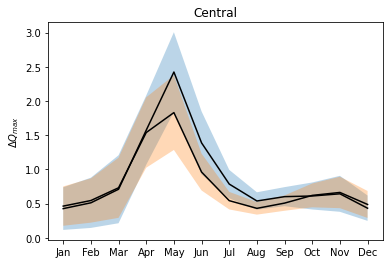

In [ ]:
cluster = 0

inds = np.argwhere(seasonal_clustering.labels_ == cluster).squeeze()

fig, ax = plt.subplots()

for kk_background in range(N_background_anomalies):

  x1 = np.mean(np.mean(max_diffs[inds,:,kk_background,:], axis = 0), axis = -1)
  x2 = np.std(np.mean(max_diffs[inds,:,kk_background,:], axis = 0), axis = -1)

  ax.fill_between(range(N_heat_waves), y1 = x1+x2, y2 = x1-x2, alpha = 0.3)
  ax.plot(x1, 'k')

ax.set_xticks(range(12))
ax.set_xticklabels(months_str)

ax.set_ylabel('$\Delta Q_{max}$')
ax.set_title(cluster_names[cluster])

plt.show()

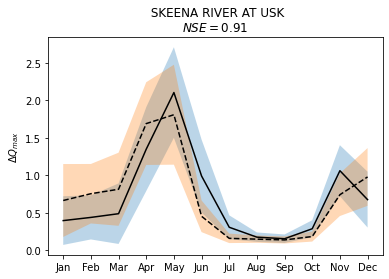

In [ ]:
ind = station_comm_inds[9]

fig, ax = plt.subplots()

for kk_background in range(N_background_anomalies):

  x1 = np.mean(max_diffs[ind,:,kk_background,:], axis = -1)
  x2 = np.std(max_diffs[ind,:,kk_background,:], axis = -1)

  ax.fill_between(range(N_heat_waves), y1 = x1+x2, y2 = x1-x2, alpha = 0.3)
  if kk_background == 0:
    ax.plot(x1, 'k')
  else:
    ax.plot(x1, 'k--')

ax.set_xticks(range(12))
ax.set_xticklabels(months_str)

ax.set_ylabel('$\Delta Q_{max}$')
ax.set_title(stationNames[ind] + '\n$NSE = $' + str(np.round(NSE_fine[ind], decimals = 2)))

plt.show()

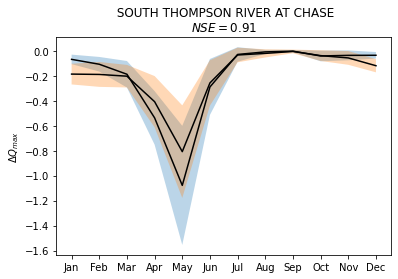

In [ ]:
inds = [station_comm_inds[0],station_comm_inds[1]]

kk_background = 0

fig, ax = plt.subplots()

for ind in inds:

  x1 = np.mean(min_diffs[ind,:,kk_background,:], axis = -1)
  x2 = np.std(min_diffs[ind,:,kk_background,:], axis = -1)

  ax.fill_between(range(N_heat_waves), y1 = x1+x2, y2 = x1-x2, alpha = 0.3)
  if kk_background == 0:
    ax.plot(x1, 'k')
  else:
    ax.plot(x1, 'k--')

ax.set_xticks(range(12))
ax.set_xticklabels(months_str)

ax.set_ylabel('$\Delta Q_{max}$')
ax.set_title(stationNames[ind] + '\n$NSE = $' + str(np.round(NSE_fine[ind], decimals = 2)))

plt.show()

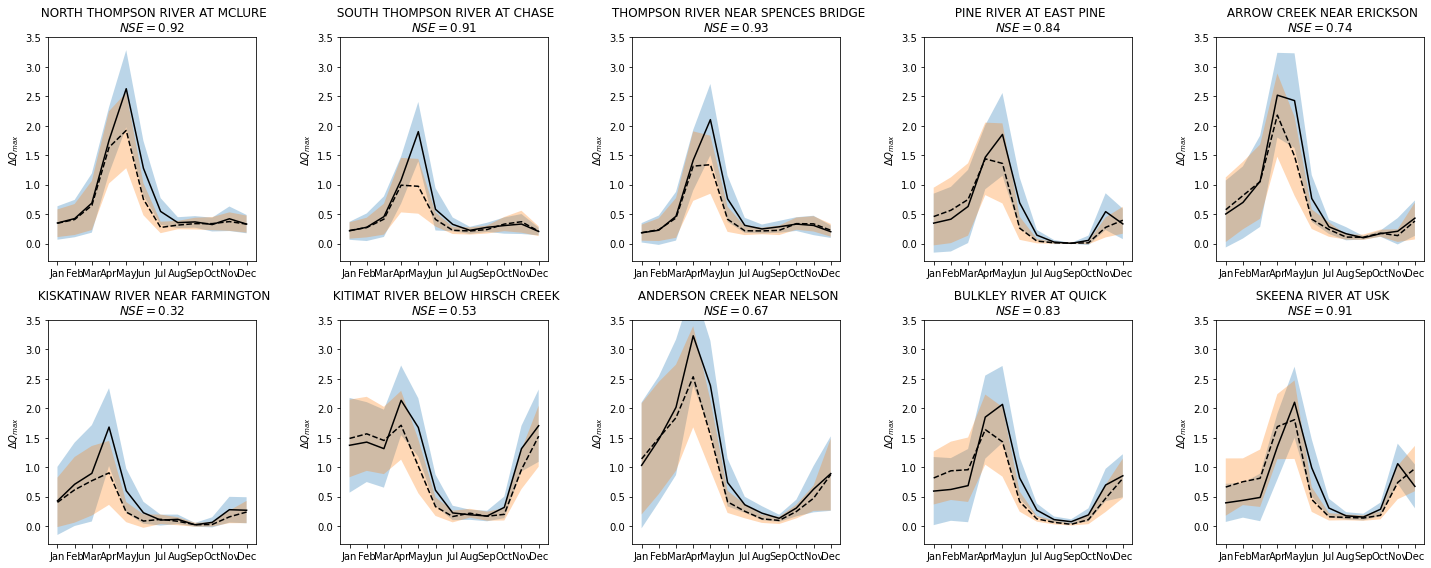

In [ ]:
fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (20,8))

for kk, ax in enumerate(axes.flatten()):

  ind = station_comm_inds[kk]

  for kk_background in range(N_background_anomalies):

    x1 = np.mean(max_diffs[ind,:,kk_background,:], axis = -1)
    x2 = np.std(max_diffs[ind,:,kk_background,:], axis = -1)

    ax.fill_between(range(N_heat_waves), y1 = x1+x2, y2 = x1-x2, alpha = 0.3)
    if kk_background == 0:
      ax.plot(x1, 'k')
    else:
      ax.plot(x1, 'k--')

  ax.set_xticks(range(12))
  ax.set_xticklabels(months_str)

  ax.set_ylim(bottom = -0.3, top = 3.5)

  ax.set_ylabel('$\Delta Q_{max}$')
  ax.set_title(stationNames[ind] + '\n$NSE = $' + str(np.round(NSE_fine[ind], decimals = 2)))

plt.tight_layout()

plt.show()

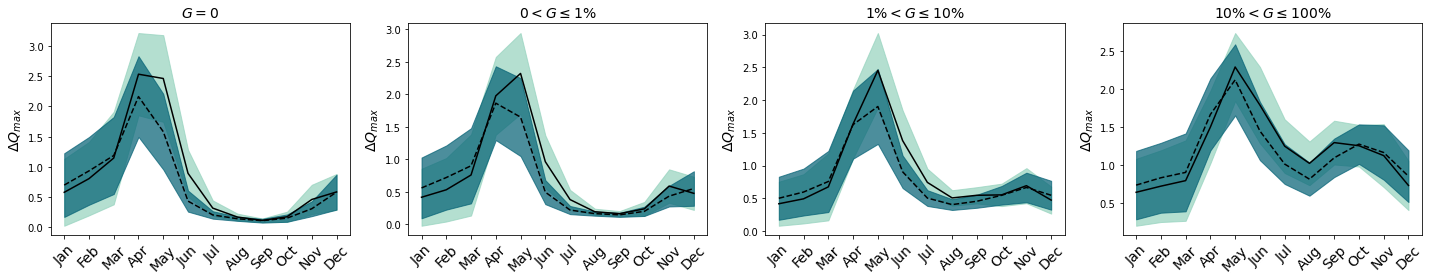

In [ ]:
saveIt = 0

fs = 14

rgb_baseline = rgbs_glacier[0,:]
rgb_warm = rgbs_glacier[2,:]
rgbs_background = [rgb_baseline, rgb_warm]

linestyles = ['-','--']

ncols = 4
nrows = 1
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (5*ncols, 4*nrows))

for glacier_class, ax in enumerate(axes.flatten()):#range(4):

  inds = np.argwhere((glacier_classes == glacier_class) & (NSE_fine > 0.7)).squeeze()

  for kk_background in range(N_background_anomalies):

    x1 = np.mean(np.mean(max_diffs[inds,:, kk_background,:], axis = 0), axis = -1)
    x2 = np.std(np.mean(max_diffs[inds,:, kk_background,:], axis = 0), axis = -1)

    ax.fill_between(range(N_heat_waves), y1 = x1+x2, y2 = x1-x2, alpha = 0.7, label = '1$\sigma$ envelope, 1980 - 2015', 
                    color = rgbs_background[kk_background])# rgbs_glacier[glacier_class,:])
    ax.plot(x1, 'k', label = 'Mean', linestyle = linestyles[kk_background])

  ax.set_xticks(range(12))
  ax.set_xticklabels(months_str, fontsize = fs, rotation = 45)
  ax.set_ylabel('$\Delta Q_{max}$', fontsize = fs)
  ax.set_title(glacier_classes_names[glacier_class], fontsize = fs)
  # ax.set_ylim(bottom = 0, top = 3)

  # if glacier_class == 0:
  #   ax.legend()

plt.tight_layout()

if saveIt:
  plt.savefig('deltaQmax_variability.png', dpi = 300, bbox_inches = 'tight')

plt.show()

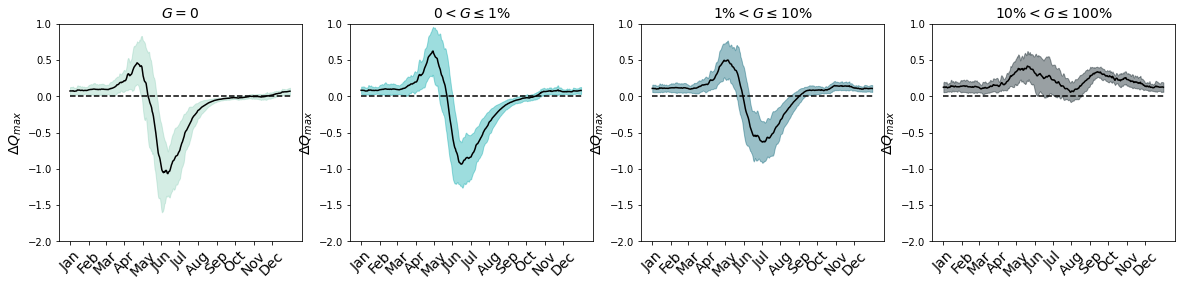

In [ ]:
x1 = y_predict[:,:,:,0]
x2 = y_predict[:,:,:,1]

dQ = x2 - x1
first_days_of_month = [0,31,59,90,120,151,181,212,243,273,304,334]
nrows = 1
ncols = 4
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (5*ncols, 4*nrows))

for glacier_class, ax in enumerate(axes.flatten()):

  inds = np.argwhere( (glacier_classes == glacier_class) & (NSE_fine > 0.7) )
  dQ_mean = np.mean(np.mean(dQ[:,inds,:], axis = 1), axis = -1).squeeze()
  dQ_std = np.std(np.mean(dQ[:,inds,:], axis = 1), axis = -1).squeeze()

  ax.plot([0,365],[0,0], 'k--')
  ax.fill_between(x = range(365), y1 = dQ_mean + dQ_std, y2 = dQ_mean - dQ_std, alpha = 0.4, color = rgbs_glacier[glacier_class,:])
  ax.plot(dQ_mean, color = 'k')

  ax.set_xticks(first_days_of_month)
  ax.set_xticklabels(months_str, fontsize = fs, rotation = 45)
  ax.set_ylabel('$\Delta Q_{max}$', fontsize = fs)
  ax.set_title(glacier_classes_names[glacier_class], fontsize = fs)

  ax.set_ylim(bottom = -2, top = 1)

In [ ]:
np.shape(max_diffs)

(226, 12, 2, 36)

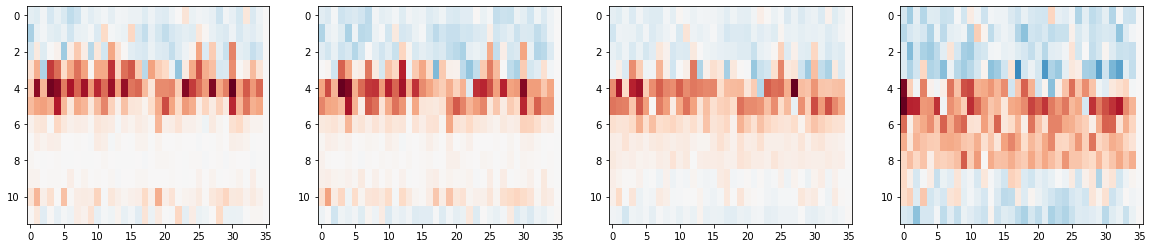

In [ ]:
nrows = 1
ncols = 4
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (5*ncols, 4*nrows))

for glacier_class, ax in enumerate(axes.flatten()):

  inds = np.argwhere( (glacier_classes == glacier_class) & (NSE_fine > 0.7) ).squeeze()

  x1 = np.mean(max_diffs[inds,:,0,:], axis = 0)
  x2 = np.mean(max_diffs[inds,:,1,:], axis = 0)

  x3 = x2 - x1

  vmax = np.max(np.abs(x3))
  vmin = -vmax
  ax.imshow(x3, aspect = 'auto', cmap = 'RdBu', vmin = vmin, vmax = vmax)


In [ ]:
np.linspace(0,365,12)

array([  0.        ,  33.18181818,  66.36363636,  99.54545455,
       132.72727273, 165.90909091, 199.09090909, 232.27272727,
       265.45454545, 298.63636364, 331.81818182, 365.        ])

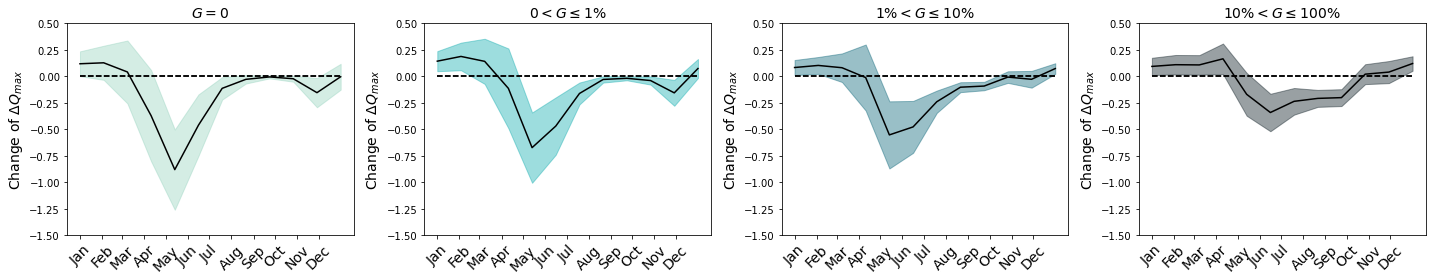

In [ ]:
saveIt = 0

x1 = max_diffs[:,:,0,:]
x2 = max_diffs[:,:,1,:]

d_deltaQ = x2 - x1

nrows = 1
ncols = 4
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (5*ncols, 4*nrows))

for glacier_class, ax in enumerate(axes.flatten()):

  inds = np.argwhere( (glacier_classes == glacier_class) & (NSE_fine > 0.7) ).squeeze()
  dQ_mean = np.mean(np.mean(d_deltaQ[inds,:,:], axis = 0), axis = -1).squeeze()
  dQ_std = np.std(np.mean(d_deltaQ[inds,:,:], axis = 0), axis = -1).squeeze()

  ax.plot([0,365],[0,0], 'k--')
  ax.fill_between(x = np.linspace(0,365,12), y1 = dQ_mean + dQ_std, y2 = dQ_mean - dQ_std, alpha = 0.4, color = rgbs_glacier[glacier_class,:])
  ax.plot(np.linspace(0,365,12), dQ_mean, color = 'k')

  dQ_mean = np.mean(np.mean(dQ[:,inds,:], axis = 1), axis = -1).squeeze()
  dQ_std = np.std(np.mean(dQ[:,inds,:], axis = 1), axis = -1).squeeze()

  ax.plot([0,365],[0,0], 'k--')
  # ax.fill_between(x = range(365), y1 = dQ_mean + dQ_std, y2 = dQ_mean - dQ_std, alpha = 0.4, color = rgbs_glacier[glacier_class,:])
  # ax.plot(dQ_mean, color = 'k')

  ax.set_ylim(bottom = -1.5, top = 0.5)

  ax.set_xticks(first_days_of_month)
  ax.set_xticklabels(months_str, fontsize = fs, rotation = 45)
  ax.set_ylabel('Change of $\Delta Q_{max}$', fontsize = fs)
  ax.set_title(glacier_classes_names[glacier_class], fontsize = fs)

plt.tight_layout()

if saveIt:
  plt.savefig('change_in_deltaQmax.png', dpi = 300, bbox_inches = 'tight')

plt.show()

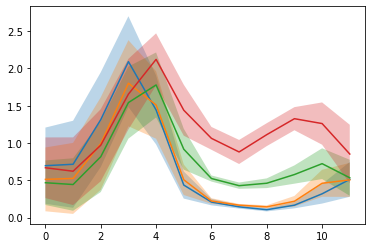

In [ ]:
|glacier_class = 3
kk_background = 1

for glacier_class in range(4):

  inds = np.argwhere((glacier_classes == glacier_class) & (NSE_fine > 0.7)).squeeze()

  x1 = np.mean(np.mean(max_diffs[inds,:, kk_background,:], axis = 0), axis = -1)
  x2 = np.std(np.mean(max_diffs[inds,:, kk_background,:], axis = 0), axis = -1)

  plt.plot(x1)
  plt.fill_between(range(N_heat_waves), y1 = x1+x2, y2 = x1-x2, alpha = 0.3)

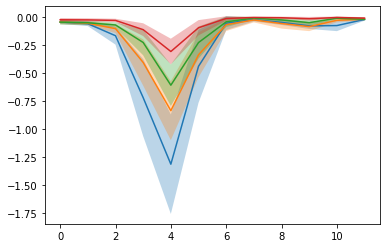

In [ ]:
#min diffs

for glacier_class in range(4):

  inds = np.argwhere((glacier_classes == glacier_class) & (NSE_fine > 0.7)).squeeze()

  x1 = np.mean(np.mean(min_diffs[inds,:,:], axis = 0), axis = -1)
  x2 = np.std(np.mean(min_diffs[inds,:,:], axis = 0), axis = -1)

  plt.plot(x1)
  plt.fill_between(range(N_heat_waves), y1 = x1+x2, y2 = x1-x2, alpha = 0.3)

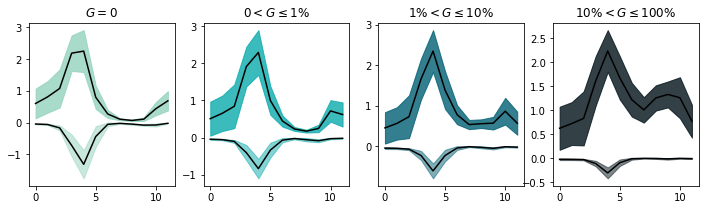

In [ ]:
rgbs_glacier = np.array([[148, 210, 189],
                         [11, 170, 173],
                         [0, 95, 115],
                         [0, 18, 25]]) / 255

nrows = 1
ncols = 4

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (3*ncols, 3*nrows))

for glacier_class, ax in enumerate(axes.flatten()):

  inds = np.argwhere((glacier_classes == glacier_class) & (NSE_fine > 0.7)).squeeze()

  x1 = np.mean(np.mean(max_diffs[inds,:,:], axis = 0), axis = -1)
  # x1 = 0
  x2 = np.std(np.mean(max_diffs[inds,:,:], axis = 0), axis = -1)
  x3 = np.mean(np.mean(min_diffs[inds,:,:], axis = 0), axis = -1)
  # x3 = 0
  x4 = np.std(np.mean(min_diffs[inds,:,:], axis = 0), axis = -1)

  ax.fill_between(range(N_heat_waves), y1 = x1+x2, y2 = x1-x2, alpha = 0.8, color = rgbs_glacier[glacier_class,:])
  ax.plot(x1, color = 'k')

  ax.fill_between(range(N_heat_waves), y1 = x3+x4, y2 = x3-x4, alpha = 0.5, color = rgbs_glacier[glacier_class,:])
  ax.plot(x3, color = 'k')

  ax.set_title(glacier_classes_names[glacier_class])

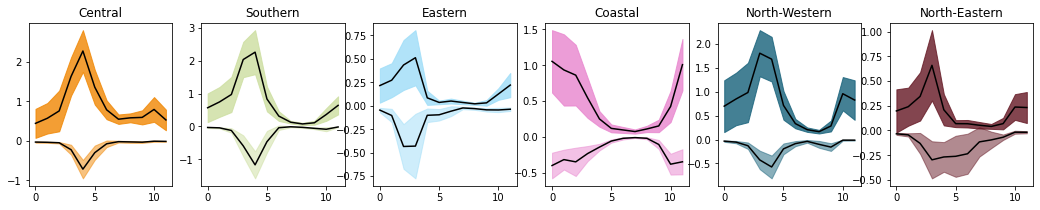

In [ ]:
nrows = 1
ncols = 6

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (3*ncols, 3*nrows))

for cluster, ax in enumerate(axes.flatten()):

  inds = np.argwhere((seasonal_clustering.labels_ == cluster) & (NSE_fine > 0.0)).squeeze()

  x1 = np.mean(np.mean(max_diffs[inds,:,:], axis = 0), axis = -1)
  x2 = np.std(np.mean(max_diffs[inds,:,:], axis = 0), axis = -1)
  x3 = np.mean(np.mean(min_diffs[inds,:,:], axis = 0), axis = -1)
  x4 = np.std(np.mean(min_diffs[inds,:,:], axis = 0), axis = -1)

  # x1 = 0
  # x3 = 0

  ax.fill_between(range(N_heat_waves), y1 = x1+x2, y2 = x1-x2, alpha = 0.8, color = rgbs_array[cluster,:])
  ax.plot(x1, color = 'k')

  ax.fill_between(range(N_heat_waves), y1 = x3+x4, y2 = x3-x4, alpha = 0.5, color = rgbs_array[cluster,:])
  ax.plot(x3, color = 'k')

  ax.set_title(cluster_names[cluster])

# Heat wave perturbations

In [ ]:
#construct test predictor/target tensors -- here we won't make the train/validate predictor/target tensors to save memory; we will analyze the test period

#predictor data
nchannels = 3 
x_test = np.empty((Ntest, 365,) + np.shape(Tmaxnorm)[1:] + (nchannels,),dtype=np.float16)

#first, make (n_time x n_lon x n_lat x n_channels) tensor -- will be used to form weather videos 
x_intermediate = np.empty(np.shape(Tmaxnorm) + (nchannels,),dtype='single')
x_intermediate[:,:,:,0] = Tmaxnorm
x_intermediate[:,:,:,1] = Tminnorm
x_intermediate[:,:,:,2] = Pnorm

Nyears = int(np.shape(x_intermediate)[0]/365)
leap_adjust = np.zeros(Nyears, dtype = 'int')
leap_adjust[np.mod(range(Nyears),4)==1] = 1
leap_adjust = np.cumsum(leap_adjust)
hot_days = np.array([np.arange(150,160)+365*kk + leap_adjust[kk] for kk in range(Nyears)]).reshape(-1,)
hot_anomaly_degrees = 10
Tmax_anomaly = hot_anomaly_degrees / Tmaxstd_train
Tmin_anomaly = hot_anomaly_degrees / Tminstd_train
perturb = np.zeros(np.shape(x_intermediate))
perturb[hot_days,:,:,0] = Tmax_anomaly
perturb[hot_days,:,:,1] = Tmin_anomaly

x_intermediate += perturb

#testing
for ii in range(Ntest):
  x_test[ii] = x_intermediate[ii + Ntrain + Nval - 365 : ii + Ntrain + Nval]
  # x_test[ii] = x_intermediate[-365 - Ntest + ii : -Ntest + ii]

#convert predict/target arrays to tensors
x_test = tf.convert_to_tensor(x_test)
y_test = tf.convert_to_tensor(y_test)

In [ ]:
Nruns = 10

batch_size = 128

y_predict_perturb_all = np.zeros((Ntest, Nstations, Nruns))
y_predict_all = np.zeros((Ntest, Nstations, Nruns))

for run in range(Nruns):

  print('Run: ' + str(run))

  #load modelled (not perturbed)
  filename_test_fine = 'y_test_fine_predict_' + str(run) + '.csv'
  y_predict_all[:,:,run] = np.asarray(pd.read_csv(dir_output + '/' + filename_test_fine, header = None))

  for cluster in range(n_clusters_seasonal):

    print('\tCluster: ' + str(cluster))

    #prep model
    inds = np.argwhere(seasonal_clustering.labels_ == cluster).squeeze()
    filename_model = 'model_fine_' + str(run) + '_cluster_' + str(cluster) + '.h5'
    model = tf.keras.models.load_model(dir_models + '/' + filename_model)

    #predict perturbed (hot)
    y_predict_perturb_all[:,inds,run] = model.predict(x_test, batch_size = batch_size)

y_predict_perturb = np.mean(y_predict_perturb_all, axis = -1)
y_predict = np.mean(y_predict_all, axis = -1)

Run: 0
	Cluster: 0
	Cluster: 1
	Cluster: 2
	Cluster: 3
	Cluster: 4
	Cluster: 5
Run: 1
	Cluster: 0
	Cluster: 1
	Cluster: 2
	Cluster: 3
	Cluster: 4
	Cluster: 5
Run: 2
	Cluster: 0
	Cluster: 1
	Cluster: 2
	Cluster: 3
	Cluster: 4
	Cluster: 5
Run: 3
	Cluster: 0
	Cluster: 1
	Cluster: 2
	Cluster: 3
	Cluster: 4
	Cluster: 5
Run: 4
	Cluster: 0
	Cluster: 1
	Cluster: 2
	Cluster: 3
	Cluster: 4
	Cluster: 5
Run: 5
	Cluster: 0
	Cluster: 1
	Cluster: 2
	Cluster: 3
	Cluster: 4
	Cluster: 5
Run: 6
	Cluster: 0
	Cluster: 1
	Cluster: 2
	Cluster: 3
	Cluster: 4
	Cluster: 5
Run: 7
	Cluster: 0
	Cluster: 1
	Cluster: 2
	Cluster: 3
	Cluster: 4
	Cluster: 5
Run: 8
	Cluster: 0
	Cluster: 1
	Cluster: 2
	Cluster: 3
	Cluster: 4
	Cluster: 5
Run: 9
	Cluster: 0
	Cluster: 1
	Cluster: 2
	Cluster: 3
	Cluster: 4
	Cluster: 5


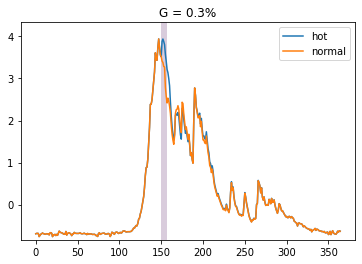

In [ ]:
station = 4

fig, ax = plt.subplots()

x1 = y_predict_perturb[:365,station]
x2 = y_predict[:365,station]

top = np.max([x1,x2])*1.1
bottom = np.min([x1,x2])*1.1

extent_heat = [np.min(hot_days), np.min(hot_days)+7, bottom, top]
ax.imshow(heat_shade, extent = extent_heat, alpha = 0.2, aspect = 'auto', label = 'Heat wave')

ax.plot(x1, label = 'hot')
ax.plot(x2, label = 'normal')
ax.set_title('G = ' + str(np.round(stationPG[station]*100, decimals = 1)) + '%')

ax.legend()




In [ ]:
y_test_clusters = np.zeros((Ntest,n_clusters_seasonal))
y_test_perturb_clusters = np.zeros((Ntest,n_clusters_seasonal))

for cluster in range(n_clusters_seasonal):
  inds = np.argwhere(seasonal_clustering.labels_ == cluster).squeeze()
  y_test_clusters[:,cluster] = np.mean(y_predict[:,inds], axis = -1)
  y_test_perturb_clusters[:,cluster] = np.mean(y_predict_perturb[:,inds], axis = -1)

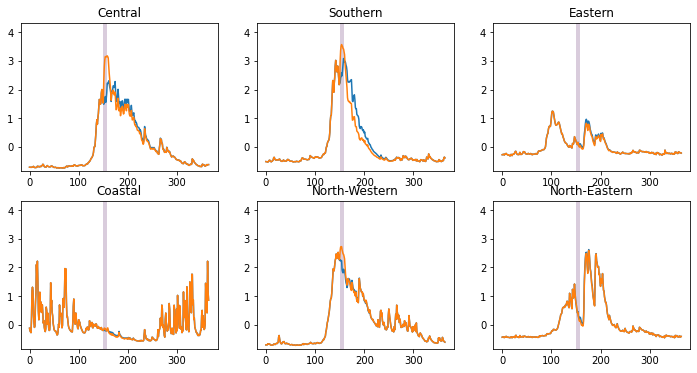

In [ ]:
nrows = 2
ncols = 3

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (4*ncols, 3*nrows))
for cluster, ax in enumerate(axes.flatten()):
  extent_heat = [np.min(hot_days), np.min(hot_days)+7, bottom, top]
  ax.imshow(heat_shade, extent = extent_heat, alpha = 0.2, aspect = 'auto', label = 'Heat wave')
  ax.plot(y_test_clusters[:365,cluster])
  ax.plot(y_test_perturb_clusters[:365,cluster])
  ax.set_title(cluster_names[cluster])


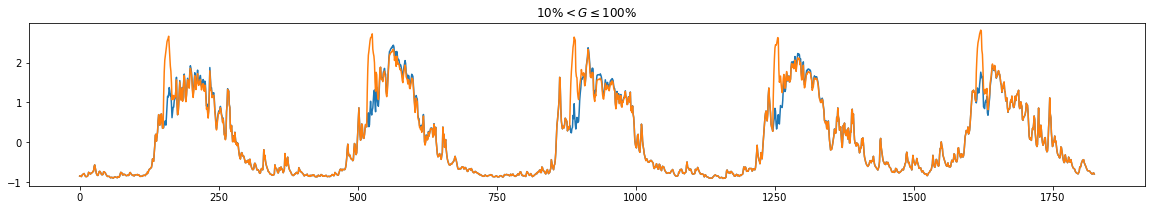

In [ ]:
fig, ax = plt.subplots(figsize = (20,3))
glacier_class = 3
Ndays_plot = 5*365
x1 = np.mean(y_predict[:Ndays_plot,glacier_classes == glacier_class], axis = -1)
x2 = np.mean(y_predict_perturb[:Ndays_plot,glacier_classes == glacier_class], axis = -1)
ax.plot(x1)
ax.plot(x2)
ax.set_title(glacier_classes_names[glacier_class])

plt.show()

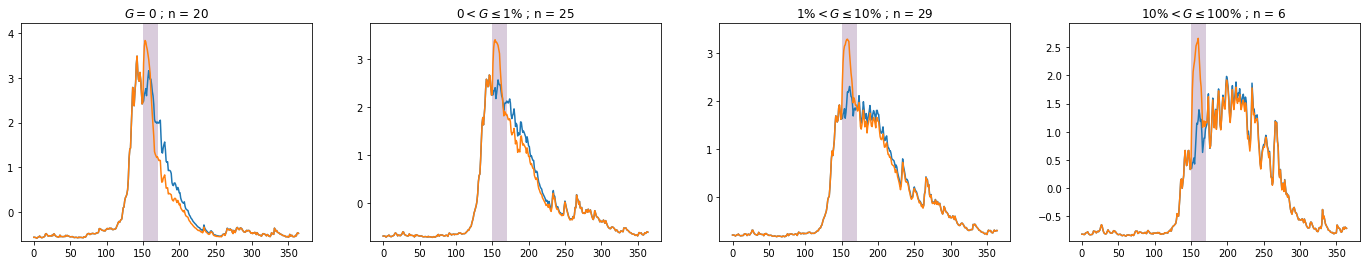

In [ ]:
nrows = 1
ncols = 4

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (6*ncols, 4*nrows))

for glacier_class, ax in enumerate(axes.flatten()):

  inds = np.argwhere((glacier_classes == glacier_class) & (NSE_fine > 0.8)).squeeze()

  Ndays_plot = 365
  x1 = np.mean(y_predict[:Ndays_plot,inds], axis = -1)
  x2 = np.mean(y_predict_perturb[:Ndays_plot,inds], axis = -1)

  top = np.max([x1,x2])*1.1
  bottom = np.min([x1,x2])*1.1

  extent_heat = [np.min(hot_days), np.min(hot_days)+20, bottom, top]
  ax.imshow(heat_shade, extent = extent_heat, alpha = 0.2, aspect = 'auto', label = 'Heat wave')

  ax.plot(x1)
  ax.plot(x2)

  ax.set_title(glacier_classes_names[glacier_class] + ' ; n = ' + str(len(inds)))

Text(0.5, 1.0, 'North-Eastern')

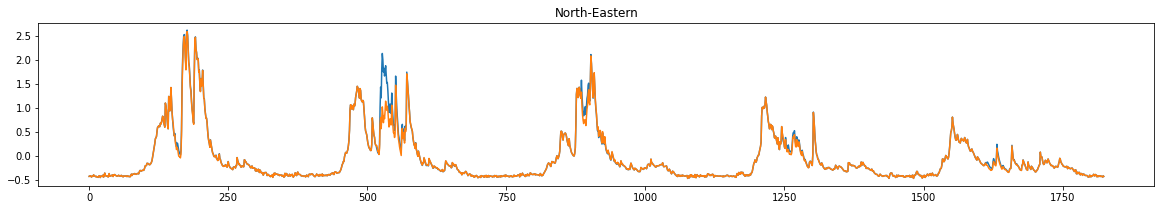

In [ ]:
fig, ax = plt.subplots(figsize = (20,3))
cluster = 5
Ndays_plot = 5*365
x1 = np.mean(y_predict[:Ndays_plot, seasonal_clustering.labels_ == cluster], axis = -1)
x2 = np.mean(y_predict_perturb[:Ndays_plot, seasonal_clustering.labels_ == cluster], axis = -1)
ax.plot(x1)
ax.plot(x2)
ax.set_title(cluster_names[cluster])

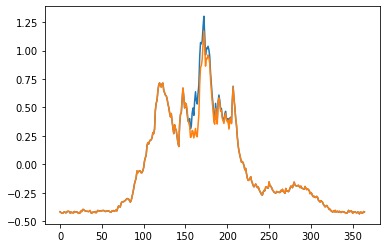

In [ ]:
cluster = 5
Nyears_plot = 5
Ndays_plot = Nyears_plot*365
x1 = np.mean(y_predict[:Ndays_plot, seasonal_clustering.labels_ == cluster], axis = -1)
x2 = np.mean(y_predict_perturb[:Ndays_plot, seasonal_clustering.labels_ == cluster], axis = -1)

f1 = x1.reshape(Nyears_plot,-1).mean(axis = 0)
f2 = x2.reshape(Nyears_plot,-1).mean(axis = 0)
plt.plot(f1)
plt.plot(f2)

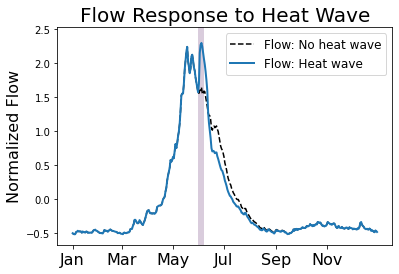

In [ ]:
saveIt = 0

glacier_class = 0
NSE_threshold = 0.7

inds = np.argwhere(
    (glacier_classes == glacier_class) & (NSE_fine > NSE_threshold)
).squeeze()

Nyears_plot = 5
Ndays_plot = Nyears_plot*365

x1 = np.mean(y_predict[:Ndays_plot, inds], axis = -1)
x2 = np.mean(y_predict_perturb[:Ndays_plot, inds], axis = -1)
f1 = x1.reshape(Nyears_plot,-1).mean(axis = 0)
f2 = x2.reshape(Nyears_plot,-1).mean(axis = 0)

top = np.max([f1,f2])*1.1
bottom = np.min([f1,f2])*1.3
extent_heat = [np.min(hot_days), np.min(hot_days)+7, bottom, top]

fig, ax = plt.subplots()
ax.imshow(heat_shade, extent = extent_heat, alpha = 0.2, aspect = 'auto', label = 'Heat wave')
ax.plot(f1,'k--', label = 'Flow: No heat wave')
ax.plot(f2, label = 'Flow: Heat wave', linewidth = 2)
ax.set_xticks(first_days_of_month[::2])
ax.set_xticklabels(months_str[::2], rotation = 0, fontsize = 16)
ax.set_ylabel('Normalized Flow', fontsize = 16)
ax.set_title('Flow Response to Heat Wave', fontsize = 20)
leg = ax.legend(fontsize = 12)

if saveIt:
  plt.savefig('no_glaciers_heat_wave.png', dpi = 300, bbox_inches = 'tight')

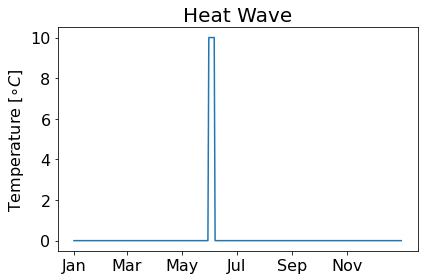

In [ ]:
saveIt = 0

heat = np.zeros(365)
days_hot = np.arange(150,157)
heat[days_hot] = 10

fs = 16
vars = [heat]
titles = ['Heat Wave']
nrows = 1
ncols = len(vars)
fig, ax = plt.subplots()
kk = 0
ax.plot(vars[kk])
ax.set_title(titles[kk], fontsize = 20)
ax.set_ylabel('Temperature [$\circ C$]', fontsize = fs)
ax.set_xticks(first_days_of_month[::2])
ax.set_xticklabels(months_str[::2], rotation = 0, fontsize = 16)
ax.tick_params(labelsize = fs)

plt.tight_layout()

if saveIt:
  plt.savefig('heat_wave_temp_series.png', bbox_inches = 'tight', dpi = 300)

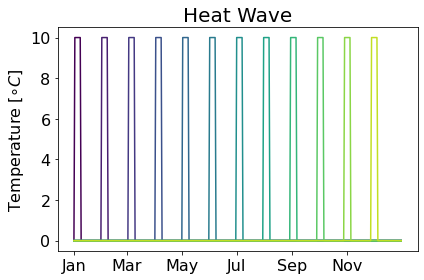

In [ ]:
saveIt = 1

heat = np.zeros(365)
days_hot = np.arange(150,167)
heat[days_hot] = 10

fs = 16

cmap = cm.get_cmap('viridis')
norm = matplotlib.colors.Normalize(vmin = 0, vmax = 365)

fig, ax = plt.subplots()

for kk in range(1,355,30):

  heat = np.zeros(365)
  days_hot = np.arange(kk,kk+7)
  heat[days_hot] = 10

  ax.plot(heat, color = cmap(norm(kk)))

ax.set_title('Heat Wave', fontsize = 20)
ax.set_ylabel('Temperature [$\circ C$]', fontsize = fs)
ax.set_xticks(first_days_of_month[::2])
ax.set_xticklabels(months_str[::2], rotation = 0, fontsize = 16)
ax.tick_params(labelsize = fs)

plt.tight_layout()

if saveIt:
  plt.savefig('heat_wave_multi_series.png', bbox_inches = 'tight', dpi = 300)

# Heat wave: rolling

In [ ]:
glacier_classes = 3*np.ones(Nstations)
glacier_classes[stationPG<=0.1] = 2
glacier_classes[stationPG<=0.01] = 1
glacier_classes[stationPG==0] = 0

In [ ]:
#construct test predictor/target tensors -- here we won't make the train/validate predictor/target tensors to save memory; we will analyze the test period

#target data
y_train = np.squeeze([Fnorm[365:trainInds[-1]+1,ii] for ii in range(np.shape(F)[1])]).T #drop first 365 days since those are used to predict first flow day
y_val = np.squeeze([Fnorm[valInds,ii] for ii in range(np.shape(F)[1])]).T
y_test = np.squeeze([Fnorm[testInds,ii] for ii in range(np.shape(F)[1])]).T

y_train = y_train.astype(dtype = np.float16)
y_val = y_val.astype(dtype = np.float16)
y_test = y_test.astype(dtype = np.float16)

#first, make (n_time x n_lon x n_lat x n_channels) tensor -- will be used to form weather videos 
x_intermediate = np.empty(np.shape(Tmaxnorm) + (nchannels,),dtype='single')
x_intermediate[:,:,:,0] = Tmaxnorm
x_intermediate[:,:,:,1] = Tminnorm
x_intermediate[:,:,:,2] = Pnorm

In [ ]:
#make perturbation
Nyears = int(np.shape(x_intermediate)[0]/365)
leap_adjust = np.zeros(Nyears, dtype = 'int')
leap_adjust[np.mod(range(Nyears),4)==1] = 1
leap_adjust = np.cumsum(leap_adjust)

days_start = np.arange(0,360,36)
heat_wave_duration = 7
days_fin = days_start + heat_wave_duration
N_heat_waves = len(days_start)

y_predict_heat_waves = np.zeros((Ntest,Nstations,N_heat_waves))

for kk, (day_start, day_fin) in enumerate(zip(days_start, days_fin)):

  print('Heat wave: ' + str(kk))

  hot_days = np.array([np.arange(day_start,day_fin)+365*kk + leap_adjust[kk] for kk in range(Nyears)]).reshape(-1,)
  hot_anomaly_degrees = 10
  Tmax_anomaly = hot_anomaly_degrees / Tmaxstd_train
  Tmin_anomaly = hot_anomaly_degrees / Tminstd_train
  perturb = np.zeros(np.shape(x_intermediate))
  perturb[hot_days,:,:,0] = Tmax_anomaly
  perturb[hot_days,:,:,1] = Tmin_anomaly

  x_intermediate_perturb = x_intermediate + perturb

  #predictor data
  nchannels = 3 
  x_test = np.empty((Ntest, 365,) + np.shape(Tmaxnorm)[1:] + (nchannels,),dtype=np.float16)
  for ii in range(Ntest):
    x_test[ii] = x_intermediate_perturb[ii + Ntrain + Nval - 365 : ii + Ntrain + Nval]

  #convert predict/target arrays to tensors
  x_test = tf.convert_to_tensor(x_test)
  y_test = tf.convert_to_tensor(y_test)

  Nruns = 10
  y_predict_perturb_all = np.zeros((Ntest, Nstations, Nruns))
  y_predict_all = np.zeros((Ntest, Nstations, Nruns))

  for run in range(Nruns):

    print('\tRun: ' + str(run))

    #load modelled (not perturbed)
    filename_test_fine = 'y_test_fine_predict_' + str(run) + '.csv'
    y_predict_all[:,:,run] = np.asarray(pd.read_csv(dir_output + '/' + filename_test_fine, header = None))

    for cluster in range(n_clusters_seasonal):

      print('\t\tCluster: ' + str(cluster))

      #prep model
      inds = np.argwhere(seasonal_clustering.labels_ == cluster).squeeze()
      filename_model = 'model_fine_' + str(run) + '_cluster_' + str(cluster) + '.h5'
      model = tf.keras.models.load_model(dir_models + '/' + filename_model)

      #predict perturbed (hot)
      y_predict_perturb_all[:365,inds,run] = model.predict(x_test[:365], batch_size = 64)

  y_predict_perturb = np.mean(y_predict_perturb_all, axis = -1)
  y_predict = np.mean(y_predict_all, axis = -1)

  y_predict_heat_waves[:365,:,kk] = y_predict_perturb[:365]

Heat wave: 0
	Run: 0
		Cluster: 0
		Cluster: 1
		Cluster: 2
		Cluster: 3
		Cluster: 4
		Cluster: 5
	Run: 1
		Cluster: 0
		Cluster: 1
		Cluster: 2
		Cluster: 3
		Cluster: 4
		Cluster: 5
	Run: 2
		Cluster: 0
		Cluster: 1
		Cluster: 2
		Cluster: 3
		Cluster: 4
		Cluster: 5
	Run: 3
		Cluster: 0
		Cluster: 1
		Cluster: 2
		Cluster: 3
		Cluster: 4
		Cluster: 5
	Run: 4
		Cluster: 0
		Cluster: 1
		Cluster: 2
		Cluster: 3
		Cluster: 4
		Cluster: 5
	Run: 5
		Cluster: 0
		Cluster: 1
		Cluster: 2
		Cluster: 3
		Cluster: 4
		Cluster: 5
	Run: 6
		Cluster: 0
		Cluster: 1
		Cluster: 2
		Cluster: 3
		Cluster: 4
		Cluster: 5
	Run: 7
		Cluster: 0
		Cluster: 1
		Cluster: 2
		Cluster: 3
		Cluster: 4
		Cluster: 5
	Run: 8
		Cluster: 0
		Cluster: 1
		Cluster: 2
		Cluster: 3
		Cluster: 4
		Cluster: 5
	Run: 9
		Cluster: 0
		Cluster: 1
		Cluster: 2
		Cluster: 3
		Cluster: 4
		Cluster: 5
Heat wave: 1
	Run: 0
		Cluster: 0
		Cluster: 1
		Cluster: 2
		Cluster: 3
		Cluster: 4
		Cluster: 5
	Run: 1
		Cluster: 0
		Clust

KeyboardInterrupt: ignored

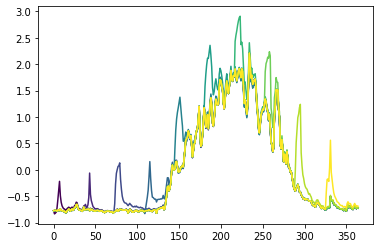

In [ ]:
station = 71

norm = matplotlib.colors.Normalize(vmin = 0, vmax = N_heat_waves-1)
cmap = cm.get_cmap('viridis')

fig, ax = plt.subplots()

ax.plot(y_predict[:365,station], 'k')

for heat_wave in range(N_heat_waves):
  ax.plot(y_predict_heat_waves[:365,station,heat_wave], color = cmap(norm(heat_wave)))

In [ ]:
max_diffs = np.max(y_predict_heat_waves - np.expand_dims(y_predict, axis = -1), axis = 0)
min_diffs = np.min(y_predict_heat_waves[:365,:,:] - np.expand_dims(y_predict[:365,:], axis = -1), axis = 0)


In [ ]:
np.shape(max_diffs)

(226, 10)

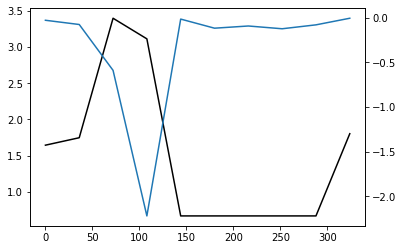

In [ ]:
station = 2

fig, ax = plt.subplots()
ax.plot(days_start, max_diffs[station,:],'k')
ax2 = ax.twinx()
ax2.plot(days_start, min_diffs[station,:])


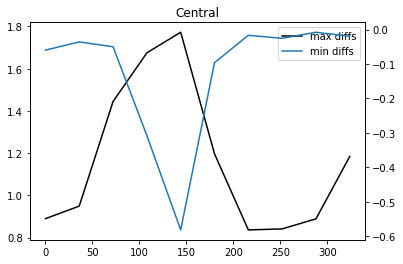

In [ ]:
cluster = 0

inds = np.argwhere(seasonal_clustering.labels_ == cluster).squeeze()
x1 = np.mean(max_diffs[inds,:], axis = 0)
x2 = np.mean(min_diffs[inds,:], axis = 0)

fig, ax = plt.subplots()
ax.plot(days_start, x1,'k', label = 'max diffs')
ax2 = ax.twinx()
ax2.plot(days_start, x2, label = 'min diffs')

ax.set_title(cluster_names[cluster])

#one legend with labels from both ax and ax2
h, l = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
labels = l+l2
handles = h+h2
ax.legend(handles, labels)


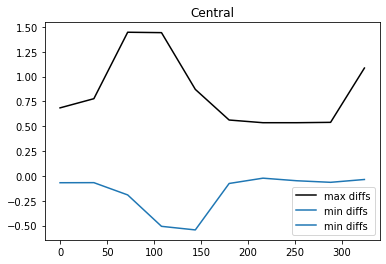

In [ ]:
glacier_class = 0

inds = np.argwhere(glacier_classes == glacier_class).squeeze()
x1 = np.mean(max_diffs[inds,:], axis = 0)
x2 = np.mean(min_diffs[inds,:], axis = 0)

fig, ax = plt.subplots()
ax.plot(days_start, x1,'k', label = 'max diffs')
# ax2 = ax.twinx()
ax.plot(days_start, x2, label = 'min diffs')

ax.set_title(cluster_names[cluster])

#one legend with labels from both ax and ax2
h, l = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
labels = l+l2
handles = h+h2
ax.legend(handles, labels)


In [ ]:
fig, ax  = plt.subplots()

sns.boxplot(x = glacier_classes, y = min_diffs[:,5])

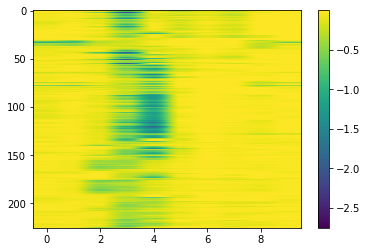

In [ ]:
plt.imshow(min_diffs, aspect = 'auto')
plt.colorbar()

# Heat wave: from ERA5 data

In [ ]:
#load data

#load daily temperature data
pickle_in = open(dir_data + '/' + 'tempDict_ERA5_2020_2021_075grid_AB_BC.pickle','rb')
tempDict = pickle.load(pickle_in)

#load daily precipitation data
pickle_in = open(dir_data + '/' + 'precDict_ERA5_2020_2021_075grid_AB_BC.pickle','rb')
precDict = pickle.load(pickle_in)

Tmax = np.asarray(tempDict['Tmax'])[:,0,:,:]
Tmin = np.asarray(tempDict['Tmin'])[:,0,:,:]
P = np.asarray(precDict['P'])[:,0,:,:]


In [ ]:
#select subset of stations

maxLat = 56. #maximum station latitude to include

#reduce spatial extent to only bound the stations of interest

bounding_box = 1 #1/0: yes/no if you want to reduce the spatial extent
border = 1 #number of pixels to border the outermost stations

if bounding_box:

  #find max/min lat/lon of stations in set
  minLon = np.min(stationLon[stationInds])
  maxLon = np.max(stationLon[stationInds])
  minLat = np.min(stationLat[stationInds])
  maxLat = np.max(stationLat[stationInds])

  #find corresponding indices in ERA lat/lon 
  indMinLonERA = np.argmin(np.abs(eraLon - minLon))
  indMaxLonERA = np.argmin(np.abs(eraLon - maxLon))
  indMinLatERA = np.argmin(np.abs(eraLat - minLat))
  indMaxLatERA = np.argmin(np.abs(eraLat - maxLat))

  #pad the bounding box by the value specified by border, if there is room in ERA dataset
  if indMinLatERA + border > len(eraLat) - 1:
    indMinLatERA = len(eraLat) - 1
  else:
    indMinLatERA = indMinLatERA + border

  if indMaxLatERA - border < 1:
    indMaxLatERA = 0
  else:
    indMaxLatERA = indMaxLatERA - border + 1

  if indMaxLonERA + border > len(eraLon) - 1:
    indMaxLonERA = len(eraLon) - 1
  else:
    indMaxLonERA = indMaxLonERA + border

  if indMinLonERA - border < 1:
    indMinLonERA = 0
  else:
    indMinLonERA = indMinLonERA - border

  #trim temp/precip data to only those values within bounding box
  Tmax = Tmax[:, indMaxLatERA:indMinLatERA+1, indMinLonERA:indMaxLonERA+1]
  Tmin = Tmin[:, indMaxLatERA:indMinLatERA+1, indMinLonERA:indMaxLonERA+1]
  P = P[:, indMaxLatERA:indMinLatERA+1, indMinLonERA:indMaxLonERA+1]

  #spatial resolution in lat/lon dimensions
  d_eraLon = eraLon[1] - eraLon[0]
  d_eraLat = eraLat[0] - eraLat[1]

  #for visualization using plt.imshow -- define extent
  extentERA = [eraLon[indMinLonERA] - d_eraLon/2,eraLon[indMaxLonERA] + d_eraLon/2,eraLat[indMinLatERA] - d_eraLat/2,eraLat[indMaxLatERA] + d_eraLat/2]
  eraLon = eraLon[indMinLonERA:indMaxLonERA+1]
  eraLat = eraLat[indMaxLatERA:indMinLatERA+1]

In [ ]:
#standardize data relative to training time period

#years/indices of testing/training

Nmodern = 578 - 365#len(Tmax) - 365

#standardize weather variables (normalize wrt training period), then reformat for memory
Tmaxnorm = (Tmax - Tmaxmean_train)/Tmaxstd_train
Tmaxnorm = np.single(Tmaxnorm)

Tminnorm = (Tmin - Tminmean_train)/Tminstd_train
Tminnorm = np.single(Tminnorm)

Pnorm = (P - Pmean_train)/Pstd_train
Pnorm = np.single(Pnorm)

In [ ]:
#construct test predictor/target tensors -- here we won't make the train/validate predictor/target tensors to save memory; we will analyze the test period

#target data
y_train = np.squeeze([Fnorm[365:trainInds[-1]+1,ii] for ii in range(np.shape(F)[1])]).T #drop first 365 days since those are used to predict first flow day
y_val = np.squeeze([Fnorm[valInds,ii] for ii in range(np.shape(F)[1])]).T
y_test = np.squeeze([Fnorm[testInds,ii] for ii in range(np.shape(F)[1])]).T

y_train = y_train.astype(dtype = np.float16)
y_val = y_val.astype(dtype = np.float16)
y_test = y_test.astype(dtype = np.float16)

#predictor data
nchannels = 3 
x_modern = np.empty((Nmodern, 365,) + np.shape(Tmaxnorm)[1:] + (nchannels,),dtype=np.float16)

#first, make (n_time x n_lon x n_lat x n_channels) tensor -- will be used to form weather videos 
x_intermediate = np.empty(np.shape(Tmaxnorm) + (nchannels,),dtype='single')
x_intermediate[:,:,:,0] = Tmaxnorm
x_intermediate[:,:,:,1] = Tminnorm
x_intermediate[:,:,:,2] = Pnorm

#testing
for ii in range(Nmodern):
  x_modern[ii] = x_intermediate[ii: ii + 365]

#convert predict/target arrays to tensors
x_modern = tf.convert_to_tensor(x_modern)

In [ ]:
Nruns = 10

y_predict_modern_all = np.zeros((Nmodern, Nstations, Nruns))

for run in range(Nruns):

  print('Run: ' + str(run))

  for cluster in range(n_clusters_seasonal):

    print('\tCluster: ' + str(cluster))

    #prep model
    inds = np.argwhere(seasonal_clustering.labels_ == cluster).squeeze()
    filename_model = 'model_fine_' + str(run) + '_cluster_' + str(cluster) + '.h5'
    model = tf.keras.models.load_model(dir_models + '/' + filename_model)

    #predict perturbed (hot)
    y_predict_modern_all[:,inds,run] = model.predict(x_modern, batch_size = 64)

y_predict_modern = np.mean(y_predict_modern_all, axis = -1)

Run: 0
	Cluster: 0
	Cluster: 1
	Cluster: 2
	Cluster: 3
	Cluster: 4
	Cluster: 5
Run: 1
	Cluster: 0
	Cluster: 1
	Cluster: 2
	Cluster: 3
	Cluster: 4
	Cluster: 5
Run: 2
	Cluster: 0
	Cluster: 1
	Cluster: 2
	Cluster: 3
	Cluster: 4
	Cluster: 5
Run: 3
	Cluster: 0
	Cluster: 1
	Cluster: 2
	Cluster: 3
	Cluster: 4
	Cluster: 5
Run: 4
	Cluster: 0
	Cluster: 1
	Cluster: 2
	Cluster: 3
	Cluster: 4
	Cluster: 5
Run: 5
	Cluster: 0
	Cluster: 1
	Cluster: 2
	Cluster: 3
	Cluster: 4
	Cluster: 5
Run: 6
	Cluster: 0
	Cluster: 1
	Cluster: 2
	Cluster: 3
	Cluster: 4
	Cluster: 5
Run: 7
	Cluster: 0
	Cluster: 1
	Cluster: 2
	Cluster: 3
	Cluster: 4
	Cluster: 5
Run: 8
	Cluster: 0
	Cluster: 1
	Cluster: 2
	Cluster: 3
	Cluster: 4
	Cluster: 5
Run: 9
	Cluster: 0
	Cluster: 1
	Cluster: 2
	Cluster: 3
	Cluster: 4
	Cluster: 5


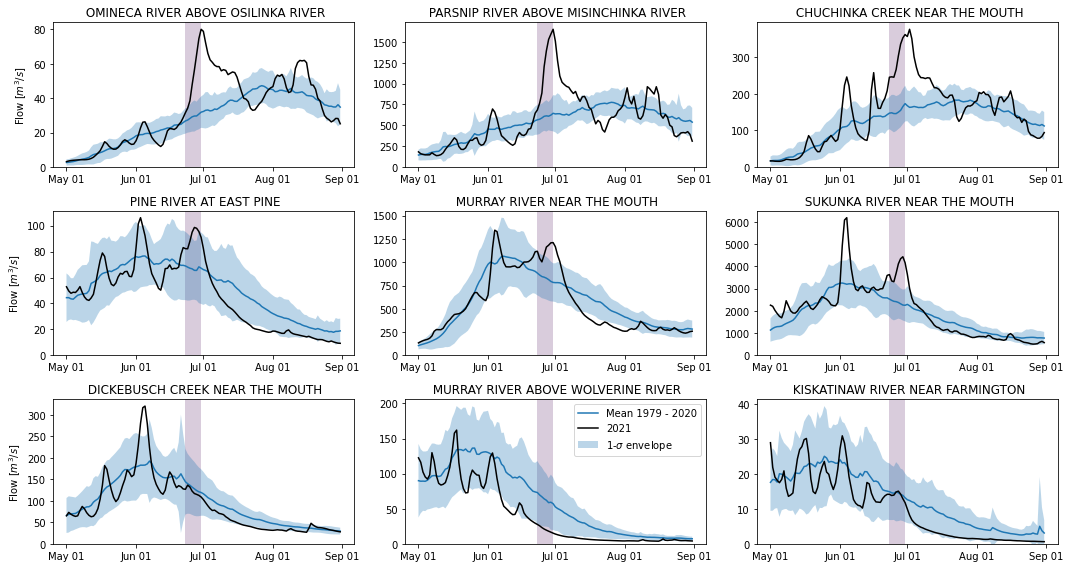

In [ ]:
#visualize

saveIt = 0

heat_start = 55
heat_fin = heat_start+7
heat_start = datetime(year = 2021, month = 6, day = 23)
heat_fin = heat_start + timedelta(days = 7)
heat_shade = np.ones((1,1))

fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (15,8))

for station, ax in enumerate(axes.flatten()):

  y1 = flow_mean[station,:] + flow_std[station,:]
  y2 = flow_mean[station,:] - flow_std[station,:]

  bottom = 0
  top = np.max([flow_daily[station,:], y1])*1.05

  extent_heat = [mdates.date2num(heat_start), mdates.date2num(heat_fin), top, bottom]
  ax.imshow(heat_shade, extent = extent_heat, alpha = 0.2, aspect = 'auto', label = 'Heat wave')

  ax.fill_between(x = datetimes, y1 = y1, y2 = y2, alpha = 0.3, label = '1-$\sigma$ envelope')
  ax.plot(datetimes, flow_mean[station,:], label  = 'Mean 1979 - 2020')

  ax.plot(datetimes, flow_daily[station,:], 'k', label = '2021')

  ax.set_ylim(bottom = bottom, top = top)

  ax.set_xticks(ax.get_xticks()[::2])  
  monthFormatter = DateFormatter('%b %d')
  ax.xaxis.set_major_formatter(monthFormatter)
  ax.xaxis_date()

  if station % 3 == 0:
    ax.set_ylabel('Flow [$m^3/s$]')

  ax.set_title(stationNames[station])  
  if station == 7:
    ax.legend()

plt.tight_layout()

if saveIt:
  plt.savefig('heat_wave_flows.png', dpi = 300, bbox_inches = 'tight')

In [ ]:
np.shape(Fmean)

(226,)

In [ ]:
np.argwhere(stationIDs_all[stationInds] == stationIDs[8]).squeeze()

array(37)

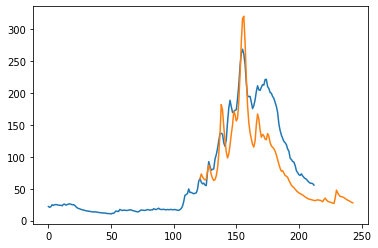

In [ ]:
kk = 6
station = np.argwhere(stationIDs_all[stationInds] == stationIDs[kk]).squeeze()

y1 = y_predict_modern[:,station] * Fstd[station] + Fmean[station]
y2 = flow_daily[kk,:]

x1 = np.arange(len(y1))
x2 = np.arange(len(y2)) + 121

plt.plot(x1, y1)
plt.plot(x2, y2)


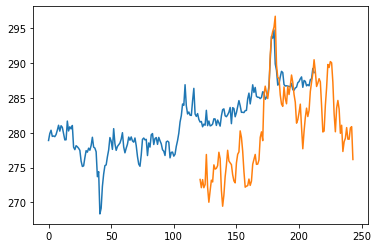

In [ ]:
plt.plot(x1, Tmax[365:Nmodern+365,7,13])
plt.plot(x2, temp_daily[0,:])

In [ ]:
eraLon[13], eraLat[7]

(-123.25, 51.0)

In [ ]:
SI = np.array([int(np.argwhere(stationIDs_all == stationID).squeeze()) for stationID in stationIDs])
stationLon[SI[0]], stationLat[SI[1]]

(-123.4533, 50.98636)

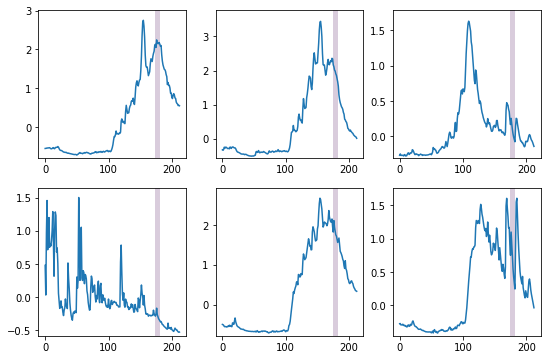

In [ ]:
nrows = 2
ncols = 3
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (3*ncols, 3*nrows)) 
for cluster , ax in enumerate(axes.flatten()):
  
  inds = np.argwhere(seasonal_clustering.labels_ == cluster).squeeze()
  x1 = np.mean(y_predict_modern[:,inds], axis = -1)

  top = np.max(x1)*1.1
  bottom = np.min(x1)*1.1

  extent_heat = [174, 181, bottom, top]
  ax.imshow(heat_shade, extent = extent_heat, alpha = 0.2, aspect = 'auto', label = 'Heat wave')

  ax.plot(x1)


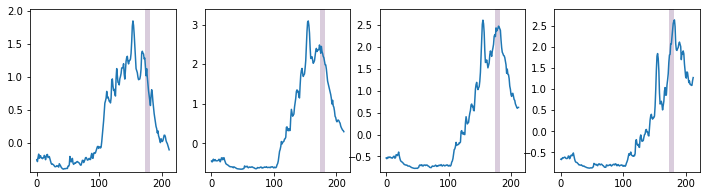

In [ ]:
nrows = 1
ncols = 4
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (3*ncols, 3*nrows)) 
for glacier_class, ax in enumerate(axes.flatten()):
  
  inds = np.argwhere(glacier_classes == glacier_class).squeeze()
  x1 = np.mean(y_predict_modern[:,inds], axis = -1)

  top = np.max(x1)*1.1
  bottom = np.min(x1)*1.1

  extent_heat = [174, 181, bottom, top]
  ax.imshow(heat_shade, extent = extent_heat, alpha = 0.2, aspect = 'auto', label = 'Heat wave')

  ax.plot(x1)


#Single heat wave under non-stationary climate

In [ ]:
#construct test predictor tensors -- here we won't make the train/validate predictor/target tensors to save memory; we will analyze the test period

Nruns = 10
hot_days_start = 150
heat_wave_duration = 7
hot_anomaly_degrees = 10
T_background_anomalies = np.arange(-2,3)
Ndays_predict = 365
batch_size = 128

#predictor data
nchannels = 3 
x_test = np.empty((Ndays_predict, 365,) + np.shape(Tmaxnorm)[1:] + (nchannels,),dtype=np.float16)

#first, make (n_time x n_lon x n_lat x n_channels) tensor -- will be used to form weather videos 
x_intermediate = np.empty(np.shape(Tmaxnorm) + (nchannels,),dtype='single')
x_intermediate[:,:,:,0] = Tmaxnorm
x_intermediate[:,:,:,1] = Tminnorm
x_intermediate[:,:,:,2] = Pnorm

Nyears = int(np.shape(x_intermediate)[0]/365)
leap_adjust = np.zeros(Nyears, dtype = 'int')
leap_adjust[np.mod(range(Nyears),4)==1] = 1
leap_adjust = np.cumsum(leap_adjust)

#temp anomalies to define the "heat wave"
hot_days = np.array([np.arange(hot_days_start,hot_days_start + heat_wave_duration)+365*kk + leap_adjust[kk] for kk in range(Nyears)]).reshape(-1,)
Tmax_anomaly = hot_anomaly_degrees / Tmaxstd_train
Tmin_anomaly = hot_anomaly_degrees / Tminstd_train

#temp anomalies to add to all days
N_background_anomalies = len(T_background_anomalies)
Tmax_background_anomalies = T_background_anomalies / Tmaxstd_train
Tmin_background_anomalies = T_background_anomalies / Tminstd_train

y_predict_perturb_all = np.zeros((Ndays_predict, Nstations, N_background_anomalies, Nruns))
y_predict_all = np.zeros((Ndays_predict, Nstations, N_background_anomalies, Nruns))

for kk, (Tmax_background_anomaly, Tmin_background_anomaly) in enumerate(zip(Tmax_background_anomalies, Tmin_background_anomalies)):

  print('Background perturbation: ' + str(kk))

  #predictor data
  x_test_heat_wave_background = np.empty((Ndays_predict, 365,) + np.shape(Tmaxnorm)[1:] + (nchannels,),dtype=np.float16)
  x_test_background = np.empty((Ndays_predict, 365,) + np.shape(Tmaxnorm)[1:] + (nchannels,),dtype=np.float16)

  perturb_heat_wave = np.zeros(np.shape(x_intermediate))
  perturb_heat_wave[hot_days,:,:,0] = Tmax_anomaly
  perturb_heat_wave[hot_days,:,:,1] = Tmin_anomaly

  perturb_background = np.zeros(np.shape(x_intermediate))
  perturb_background[:,:,:,0] += Tmax_background_anomaly
  perturb_background[:,:,:,1] += Tmin_background_anomaly

  x_intermediate_heat_wave_background = x_intermediate + perturb_heat_wave + perturb_background
  x_intermediate_background = x_intermediate + perturb_background

  #testing
  for ii in range(Ndays_predict):
    x_test_heat_wave_background[ii] = x_intermediate_heat_wave_background[ii + Ntrain + Nval - 365 : ii + Ntrain + Nval]
    x_test_background[ii] = x_intermediate_background[ii + Ntrain + Nval - 365 : ii + Ntrain + Nval]

  #convert predict/target arrays to tensors
  x_test_heat_wave_background = tf.convert_to_tensor(x_test_heat_wave_background)
  x_test_background = tf.convert_to_tensor(x_test_background)

  for run in range(Nruns):

    print('\tRun: ' + str(run))

    for cluster in range(n_clusters_seasonal):

      print('\t\tCluster: ' + str(cluster))

      #prep model
      inds = np.argwhere(seasonal_clustering.labels_ == cluster).squeeze()
      filename_model = 'model_fine_' + str(run) + '_cluster_' + str(cluster) + '.h5'
      model = tf.keras.models.load_model(dir_models + '/' + filename_model)

      #predict modelled (not perturbed, just background)
      y_predict_all[:,inds,kk,run] = model.predict(x_test_background, batch_size = batch_size)

      #predict perturbed (hot)
      y_predict_perturb_all[:,inds,kk,run] = model.predict(x_test_heat_wave_background, batch_size = batch_size)

y_predict_perturb = np.mean(y_predict_perturb_all, axis = -1)
y_predict = np.mean(y_predict_all, axis = -1)

Background perturbation: 0
	Run: 0
		Cluster: 0
		Cluster: 1
		Cluster: 2
		Cluster: 3
		Cluster: 4
		Cluster: 5
	Run: 1
		Cluster: 0
		Cluster: 1
		Cluster: 2
		Cluster: 3
		Cluster: 4
		Cluster: 5
	Run: 2
		Cluster: 0
		Cluster: 1
		Cluster: 2
		Cluster: 3
		Cluster: 4
		Cluster: 5
	Run: 3
		Cluster: 0
		Cluster: 1
		Cluster: 2
		Cluster: 3
		Cluster: 4
		Cluster: 5
	Run: 4
		Cluster: 0
		Cluster: 1
		Cluster: 2
		Cluster: 3
		Cluster: 4
		Cluster: 5
	Run: 5
		Cluster: 0
		Cluster: 1
		Cluster: 2
		Cluster: 3
		Cluster: 4
		Cluster: 5
	Run: 6
		Cluster: 0
		Cluster: 1
		Cluster: 2
		Cluster: 3
		Cluster: 4
		Cluster: 5
	Run: 7
		Cluster: 0
		Cluster: 1
		Cluster: 2
		Cluster: 3
		Cluster: 4
		Cluster: 5
	Run: 8
		Cluster: 0
		Cluster: 1
		Cluster: 2
		Cluster: 3
		Cluster: 4
		Cluster: 5
	Run: 9
		Cluster: 0
		Cluster: 1
		Cluster: 2
		Cluster: 3
		Cluster: 4
		Cluster: 5
Background perturbation: 1
	Run: 0
		Cluster: 0
		Cluster: 1
		Cluster: 2
		Cluster: 3
		Cluster: 4
		Cluster: 5


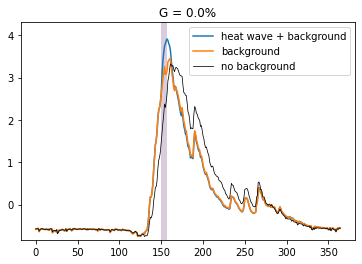

In [ ]:
station = 0
ind_background = 1

fig, ax = plt.subplots()

x1 = y_predict_perturb[:365,station,ind_background]
x2 = y_predict[:365,station,ind_background]
x3 = y_predict[:365,station,0]

top = np.max([x1,x2,x3])*1.1
bottom = np.min([x1,x2,x3])*1.1

extent_heat = [np.min(hot_days), np.min(hot_days)+7, bottom, top]
ax.imshow(heat_shade, extent = extent_heat, alpha = 0.2, aspect = 'auto', label = 'Heat wave')

ax.plot(x1, label = 'heat wave + background')
ax.plot(x2, label = 'background')
ax.plot(x3,'k', label = 'no background', linewidth = 0.75)
ax.set_title('G = ' + str(np.round(stationPG[station]*100, decimals = 1)) + '%')

ax.legend()




In [ ]:
y_test_clusters = np.zeros((Ndays_predict,n_clusters_seasonal, N_background_anomalies))
y_test_perturb_clusters = np.zeros((Ndays_predict,n_clusters_seasonal, N_background_anomalies))

for kk in range(N_background_anomalies):
  for cluster in range(n_clusters_seasonal):
    inds = np.argwhere(seasonal_clustering.labels_ == cluster).squeeze()
    y_test_clusters[:,cluster,kk] = np.mean(y_predict[:,inds,kk], axis = 1)
    y_test_perturb_clusters[:,cluster,kk] = np.mean(y_predict_perturb[:,inds,kk], axis = 1)

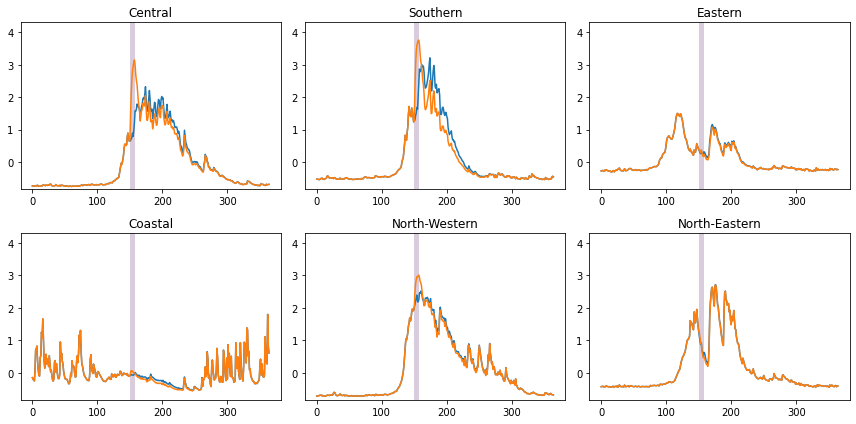

In [ ]:
ind_background = 0

nrows = 2
ncols = 3

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (4*ncols, 3*nrows))
for cluster, ax in enumerate(axes.flatten()):
  extent_heat = [np.min(hot_days), np.min(hot_days)+7, bottom, top]
  ax.imshow(heat_shade, extent = extent_heat, alpha = 0.2, aspect = 'auto', label = 'Heat wave')
  ax.plot(y_test_clusters[:365,cluster,ind_background])
  ax.plot(y_test_perturb_clusters[:365,cluster,ind_background])
  ax.set_title(cluster_names[cluster])

plt.tight_layout()

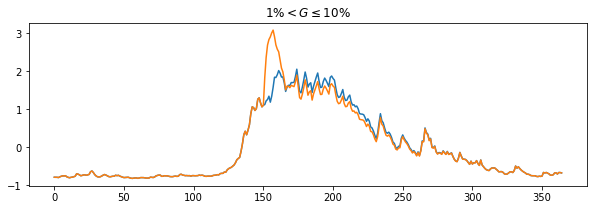

In [ ]:
ind_background = 1
fig, ax = plt.subplots(figsize = (10,3))
glacier_class = 2
Ndays_plot = 5*365
x1 = np.mean(y_predict[:Ndays_plot,glacier_classes == glacier_class, ind_background], axis = 1)
x2 = np.mean(y_predict_perturb[:Ndays_plot,glacier_classes == glacier_class, ind_background], axis = 1)
ax.plot(x1)
ax.plot(x2)
ax.set_title(glacier_classes_names[glacier_class])

plt.show()

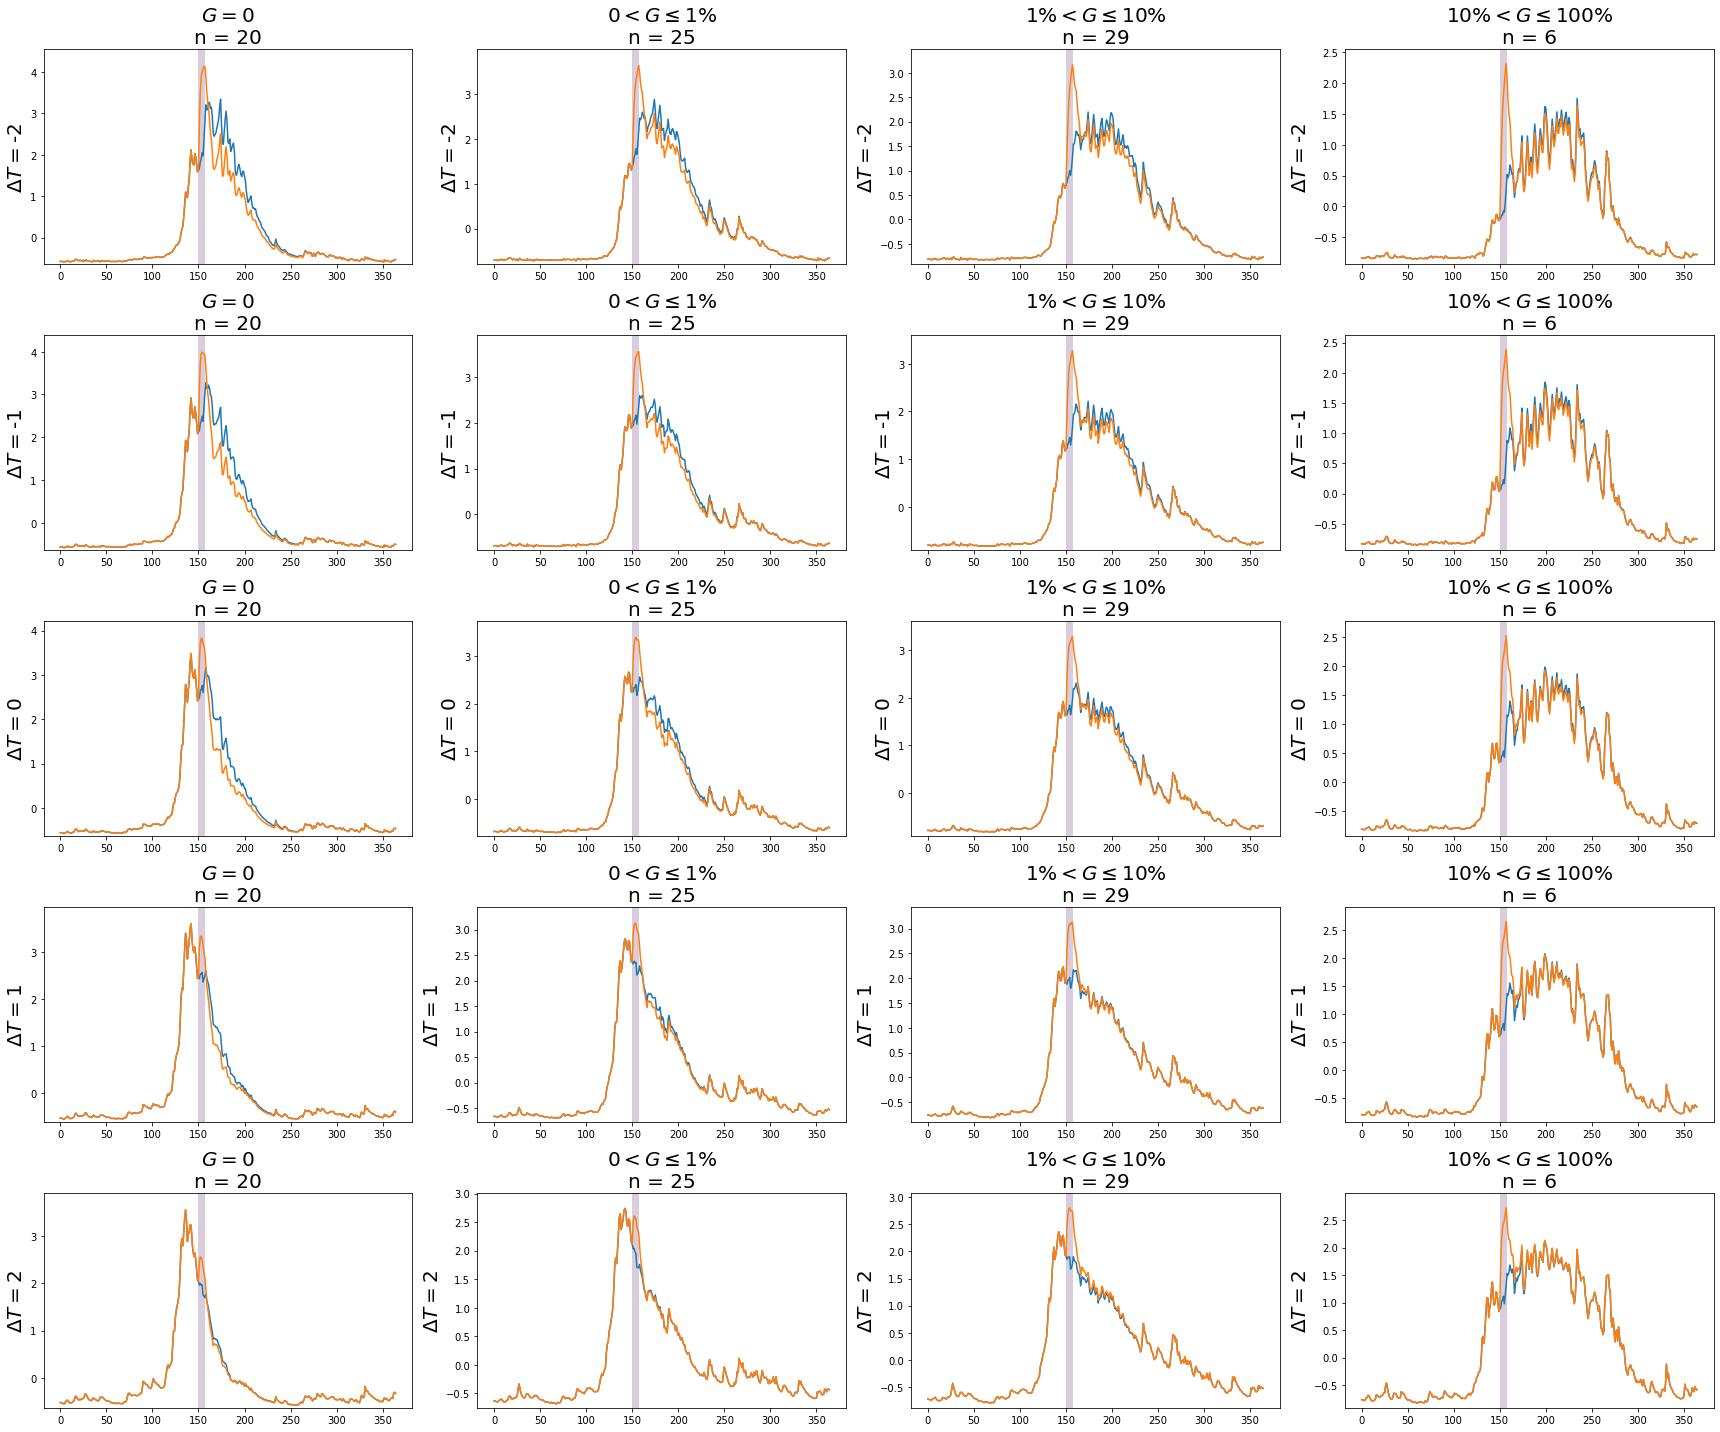

In [ ]:
nrows = N_background_anomalies
ncols = 4
fs = 20

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (6*ncols, 4*nrows))

for ind_background in range(N_background_anomalies):

  for glacier_class, ax in enumerate(axes[ind_background,:].flatten()):

    inds = np.argwhere((glacier_classes == glacier_class) & (NSE_fine > 0.8)).squeeze()

    Ndays_plot = 365
    x1 = np.mean(y_predict[:Ndays_plot,inds, ind_background], axis = 1)
    x2 = np.mean(y_predict_perturb[:Ndays_plot,inds, ind_background], axis = 1)

    top = np.max([x1,x2])*1.1
    bottom = np.min([x1,x2])*1.1

    extent_heat = [np.min(hot_days), np.min(hot_days)+heat_wave_duration, bottom, top]
    ax.imshow(heat_shade, extent = extent_heat, alpha = 0.2, aspect = 'auto', label = 'Heat wave')

    ax.plot(x1)
    ax.plot(x2)

    ax.set_title(glacier_classes_names[glacier_class] + '\nn = ' + str(len(inds)), fontsize = fs)
    ax.set_ylabel('$\Delta T=$' + str(T_background_anomalies[ind_background]), fontsize = fs)

plt.tight_layout()

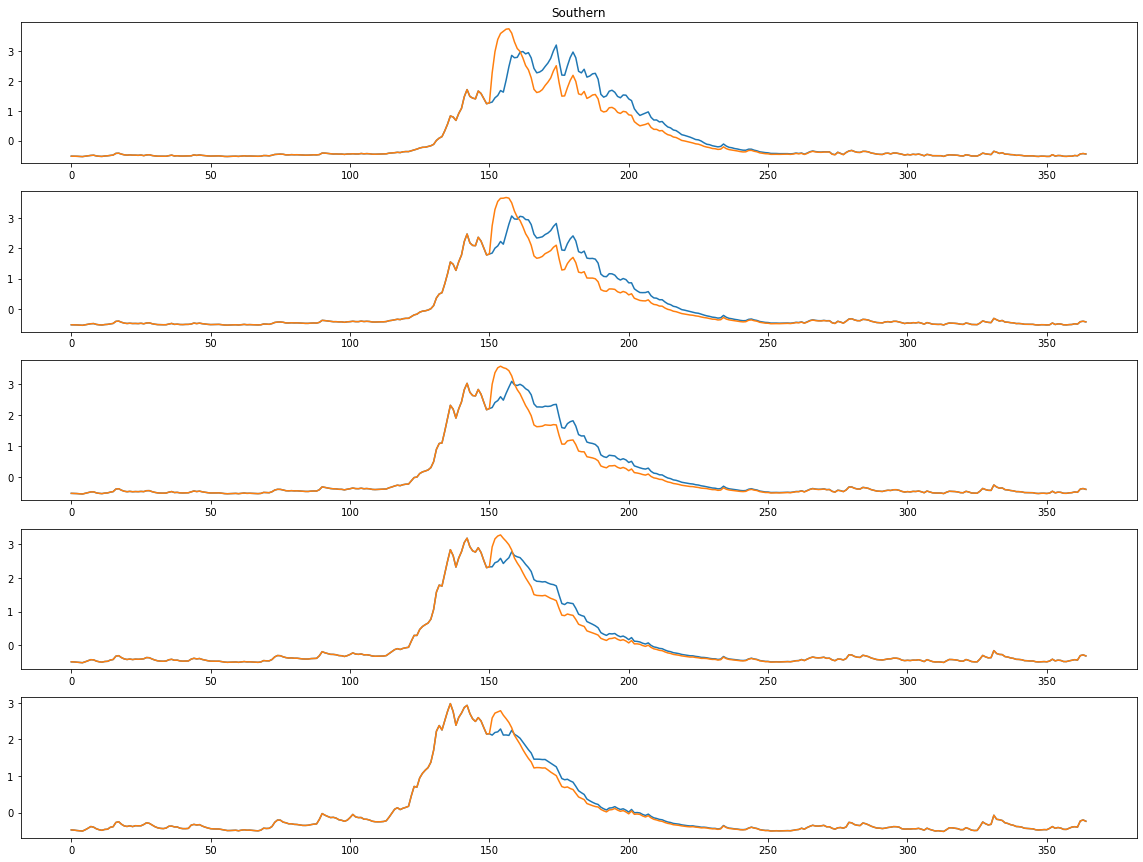

In [ ]:
nrows = N_background_anomalies

fig, ax = plt.subplots(nrows = nrows, figsize = (20,3*N_background_anomalies))
cluster = 1
Ndays_plot = 5*365

for ind_background in range(N_background_anomalies):

  x1 = np.mean(y_predict[:Ndays_plot, seasonal_clustering.labels_ == cluster, ind_background], axis = 1)
  x2 = np.mean(y_predict_perturb[:Ndays_plot, seasonal_clustering.labels_ == cluster, ind_background], axis = 1)
  ax[ind_background].plot(x1)
  ax[ind_background].plot(x2)

ax[0].set_title(cluster_names[cluster])

plt.show()


In [ ]:
np.shape(x1)

(365,)

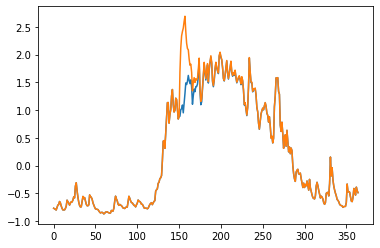

In [ ]:
glacier_class = 3
Nyears_plot = 1
Ndays_plot = Nyears_plot*365
x1 = np.mean(y_predict[:Ndays_plot, glacier_classes == glacier_class, ind_background], axis = 1)
x2 = np.mean(y_predict_perturb[:Ndays_plot, glacier_classes == glacier_class, ind_background], axis = 1)

f1 = x1.reshape(Nyears_plot,-1).mean(axis = 0)
f2 = x2.reshape(Nyears_plot,-1).mean(axis = 0)
plt.plot(f1)
plt.plot(f2)

In [ ]:
#by glacier class
Ndays = 365 
N_glacier_classes = 4
max_diffs_glacier_classes = np.zeros((N_glacier_classes, N_background_anomalies))
min_diffs_glacier_classes = np.zeros((N_glacier_classes, N_background_anomalies))

for ind_background in range(N_background_anomalies):
  for glacier_class in range(N_glacier_classes):
    x1 = np.mean(y_predict[:Ndays, glacier_classes == glacier_class, ind_background], axis = 1)
    x2 = np.mean(y_predict_perturb[:Ndays, glacier_classes == glacier_class, ind_background], axis = 1)
    max_diffs_glacier_classes[glacier_class,ind_background] = np.max(x2 - x1)
    min_diffs_glacier_classes[glacier_class,ind_background] = np.min(x2 - x1)

#by seasonal cluster
max_diffs_clusters = np.zeros((n_clusters_seasonal, N_background_anomalies))
min_diffs_clusters = np.zeros((n_clusters_seasonal, N_background_anomalies))

for ind_background in range(N_background_anomalies):
  for cluster in range(n_clusters_seasonal):
    x1 = np.mean(y_predict[:Ndays, seasonal_clustering.labels_ == cluster, ind_background], axis = 1)
    x2 = np.mean(y_predict_perturb[:Ndays, seasonal_clustering.labels_ == cluster, ind_background], axis = 1)
    max_diffs_clusters[cluster,ind_background] = np.max(x2 - x1)
    min_diffs_clusters[cluster,ind_background] = np.min(x2 - x1)

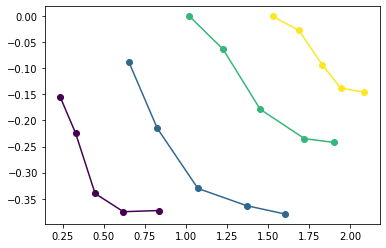

In [ ]:
cmap = cm.get_cmap('viridis')
norm = matplotlib.colors.Normalize(vmin = 0, vmax = 3)

fig, ax = plt.subplots()

for glacier_class in range(N_glacier_classes):

  ax.plot(max_diffs_glacier_classes[glacier_class,:], min_diffs_glacier_classes[glacier_class,:], color = cmap(norm(glacier_class)), marker = 'o')


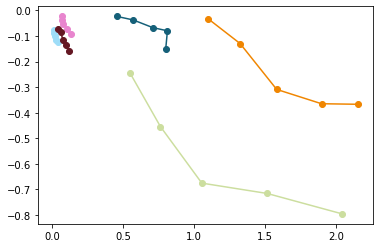

In [ ]:
cmap = cm.get_cmap('viridis')
norm = matplotlib.colors.Normalize(vmin = 0, vmax = 3)

fig, ax = plt.subplots()

for cluster in range(n_clusters_seasonal):

  ax.plot(max_diffs_clusters[cluster,:], min_diffs_clusters[cluster,:], color = rgbas_array[cluster,:], marker = 'o')


#Rolling heat waves under non-stationary climate

In [ ]:
print('hi')

hi


In [ ]:
#construct test predictor tensors -- here we won't make the train/validate predictor/target tensors to save memory; we will analyze the test period

Nruns = 10
days_start = np.arange(0,350,30)
heat_wave_duration = 7
T_background_anomalies = np.arange(0,2)
T_background_anomalies = [0,2]
Ndays_predict = 365

#predictor data
nchannels = 3 
x_test = np.empty((Ndays_predict, 365,) + np.shape(Tmaxnorm)[1:] + (nchannels,),dtype=np.float16)

#first, make (n_time x n_lon x n_lat x n_channels) tensor -- will be used to form weather videos 
x_intermediate = np.empty(np.shape(Tmaxnorm) + (nchannels,),dtype='single')
x_intermediate[:,:,:,0] = Tmaxnorm
x_intermediate[:,:,:,1] = Tminnorm
x_intermediate[:,:,:,2] = Pnorm

Nyears = int(np.shape(x_intermediate)[0]/365)
leap_adjust = np.zeros(Nyears, dtype = 'int')
leap_adjust[np.mod(range(Nyears),4)==1] = 1
leap_adjust = np.cumsum(leap_adjust)

#temp anomalies to define the "heat wave"
days_fin = days_start + heat_wave_duration
N_heat_waves = len(days_start)

#define background temperature perturbations
N_background_anomalies = len(T_background_anomalies)
Tmax_background_anomalies = T_background_anomalies / Tmaxstd_train
Tmin_background_anomalies = T_background_anomalies / Tminstd_train

y_predict_perturb_all = np.zeros((Ndays_predict, Nstations, N_background_anomalies, N_heat_waves, Nruns))
y_predict_all = np.zeros((Ndays_predict, Nstations, N_background_anomalies, Nruns))

for jj, (day_start, day_fin) in enumerate(zip(days_start, days_fin)):

  print('Heat wave: ' + str(jj))
  
  #define heat wave intensitiy
  hot_days = np.array([np.arange(day_start,day_fin)+365*ii + leap_adjust[ii] for ii in range(Nyears)]).reshape(-1,)
  hot_anomaly_degrees = 10
  Tmax_anomaly = hot_anomaly_degrees / Tmaxstd_train
  Tmin_anomaly = hot_anomaly_degrees / Tminstd_train

  for kk, (Tmax_background_anomaly, Tmin_background_anomaly) in enumerate(zip(Tmax_background_anomalies, Tmin_background_anomalies)):

    print('\tBackground perturbation: ' + str(kk))

    #predictor data
    x_test_heat_wave_background = np.empty((Ndays_predict, 365,) + np.shape(Tmaxnorm)[1:] + (nchannels,),dtype=np.float16)
    x_test_background = np.empty((Ndays_predict, 365,) + np.shape(Tmaxnorm)[1:] + (nchannels,),dtype=np.float16)

    perturb_heat_wave = np.zeros(np.shape(x_intermediate))
    perturb_heat_wave[hot_days,:,:,0] = Tmax_anomaly
    perturb_heat_wave[hot_days,:,:,1] = Tmin_anomaly

    perturb_background = np.zeros(np.shape(x_intermediate))
    perturb_background[:,:,:,0] += Tmax_background_anomaly
    perturb_background[:,:,:,1] += Tmin_background_anomaly

    x_intermediate_heat_wave_background = x_intermediate + perturb_heat_wave + perturb_background
    x_intermediate_background = x_intermediate + perturb_background

    #testing
    for ii in range(Ndays_predict):
      x_test_heat_wave_background[ii] = x_intermediate_heat_wave_background[ii + Ntrain + Nval - 365 : ii + Ntrain + Nval]
      x_test_background[ii] = x_intermediate_background[ii + Ntrain + Nval - 365 : ii + Ntrain + Nval]

    #convert predict/target arrays to tensors
    x_test_heat_wave_background = tf.convert_to_tensor(x_test_heat_wave_background)
    x_test_background = tf.convert_to_tensor(x_test_background)
    y_test = tf.convert_to_tensor(y_test)

    for run in range(Nruns):

      print('\t\tRun: ' + str(run))

      for cluster in range(n_clusters_seasonal):

        print('\t\t\tCluster: ' + str(cluster))

        batch_size = 64 * 2

        #prep model
        inds = np.argwhere(seasonal_clustering.labels_ == cluster).squeeze()
        filename_model = 'model_fine_' + str(run) + '_cluster_' + str(cluster) + '.h5'
        model = tf.keras.models.load_model(dir_models + '/' + filename_model)

        #predict modelled (not perturbed, just background)
        if jj == 0:
          y_predict_all[:,inds,kk,run] = model.predict(x_test_background, batch_size = batch_size)

        #predict perturbed (hot)
        y_predict_perturb_all[:,inds,kk,jj,run] = model.predict(x_test_heat_wave_background, batch_size = batch_size)

y_predict_perturb = np.mean(y_predict_perturb_all, axis = -1)
y_predict = np.mean(y_predict_all, axis = -1)

Heat wave: 0
	Background perturbation: 0
		Run: 0
			Cluster: 0
			Cluster: 1
			Cluster: 2
			Cluster: 3
			Cluster: 4
			Cluster: 5
		Run: 1
			Cluster: 0
			Cluster: 1
			Cluster: 2
			Cluster: 3
			Cluster: 4
			Cluster: 5
		Run: 2
			Cluster: 0
			Cluster: 1
			Cluster: 2
			Cluster: 3
			Cluster: 4
			Cluster: 5
		Run: 3
			Cluster: 0
			Cluster: 1
			Cluster: 2
			Cluster: 3
			Cluster: 4
			Cluster: 5
		Run: 4
			Cluster: 0
			Cluster: 1
			Cluster: 2
			Cluster: 3
			Cluster: 4
			Cluster: 5
		Run: 5
			Cluster: 0
			Cluster: 1
			Cluster: 2
			Cluster: 3
			Cluster: 4
			Cluster: 5
		Run: 6
			Cluster: 0
			Cluster: 1
			Cluster: 2
			Cluster: 3
			Cluster: 4
			Cluster: 5
		Run: 7
			Cluster: 0
			Cluster: 1
			Cluster: 2
			Cluster: 3
			Cluster: 4
			Cluster: 5
		Run: 8
			Cluster: 0
			Cluster: 1
			Cluster: 2
			Cluster: 3
			Cluster: 4
			Cluster: 5
		Run: 9
			Cluster: 0
			Cluster: 1
			Cluster: 2
			Cluster: 3
			Cluster: 4
			Cluster: 5
	Background perturbation: 1
	

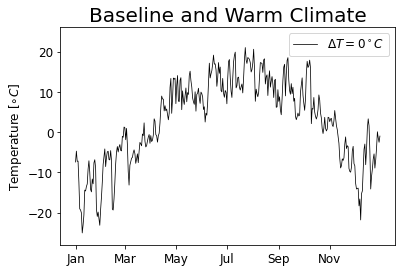

In [ ]:
saveIt = 0

fig, ax = plt.subplots()

x1 = Tmax[365:2*365,6,20] - 273

ax.plot(x1,'k', linewidth = 0.75, label = '$\Delta T=0^\circ C$')
# ax.plot(x1 + 3, label = '$\Delta T=2^\circ C$')
ax.legend(fontsize = 12)
ax.set_ylim(bottom = -28, top = 26)

ax.set_title('Baseline and Warm Climate', fontsize = 20)
ax.set_ylabel('Temperature [$\circ C$]', fontsize = fs)
ax.set_xticks(first_days_of_month[::2])
ax.set_xticklabels(months_str[::2], rotation = 0, fontsize = 16)
ax.tick_params(labelsize = fs)

if saveIt:
  plt.savefig('baseline_warm_climates2.png', dpi = 300, bbox_inches = 'tight')

In [ ]:
np.shape(y_predict)

(365, 226, 2)

In [ ]:
#by glacier class
Ndays = 365 
N_glacier_classes = 4
max_diffs_glacier_classes = np.zeros((N_glacier_classes, N_background_anomalies, N_heat_waves))
min_diffs_glacier_classes = np.zeros((N_glacier_classes, N_background_anomalies, N_heat_waves))

for ind_heat_wave in range(N_heat_waves):
  for ind_background in range(N_background_anomalies):
    for glacier_class in range(N_glacier_classes):
      x1 = np.mean(y_predict[:Ndays, glacier_classes == glacier_class, ind_background], axis = 1)
      x2 = np.mean(y_predict_perturb[:Ndays, glacier_classes == glacier_class, ind_background, ind_heat_wave], axis = 1)
      max_diffs_glacier_classes[glacier_class,ind_background, ind_heat_wave] = np.max(x2 - x1)
      min_diffs_glacier_classes[glacier_class,ind_background, ind_heat_wave] = np.min(x2 - x1)

#by seasonal cluster
max_diffs_clusters = np.zeros((n_clusters_seasonal, N_background_anomalies, N_heat_waves))
min_diffs_clusters = np.zeros((n_clusters_seasonal, N_background_anomalies, N_heat_waves))

for ind_heat_wave in range(N_heat_waves):
  for ind_background in range(N_background_anomalies):
    for cluster in range(n_clusters_seasonal):
      x1 = np.mean(y_predict[:Ndays, seasonal_clustering.labels_ == cluster, ind_background], axis = 1)
      x2 = np.mean(y_predict_perturb[:Ndays, seasonal_clustering.labels_ == cluster, ind_background, ind_heat_wave], axis = 1)
      max_diffs_clusters[cluster,ind_background, ind_heat_wave] = np.max(x2 - x1)
      min_diffs_clusters[cluster,ind_background, ind_heat_wave] = np.min(x2 - x1)

#by station
Ndays = 365 
max_diffs_stations = np.zeros((Nstations, N_background_anomalies, N_heat_waves))
min_diffs_stations = np.zeros((Nstations, N_background_anomalies, N_heat_waves))

for ind_heat_wave in range(N_heat_waves):
  for ind_background in range(N_background_anomalies):
    for station in range(Nstations):
      x1 = y_predict[:Ndays, station, ind_background]
      x2 = y_predict_perturb[:Ndays, station, ind_background, ind_heat_wave]
      max_diffs_stations[station,ind_background, ind_heat_wave] = np.max(x2 - x1)
      min_diffs_stations[station,ind_background, ind_heat_wave] = np.min(x2 - x1)

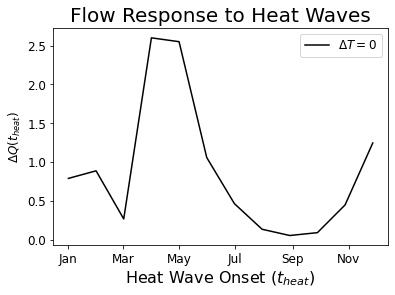

In [ ]:
saveIt = 0

fig, ax = plt.subplots()

glacier_class = 0
NSE_threshold = 0.7

inds = np.argwhere(
    (glacier_classes == glacier_class) & (NSE_fine > NSE_threshold)
).squeeze()

x1 = np.mean(max_diffs_stations[inds,0,:], axis = 0)
x2 = np.mean(max_diffs_stations[inds,1,:], axis = 0)

ax.plot(days_start, x1, label = '$\Delta T = $' + str(T_background_anomalies[0]), color = 'k')
# ax.plot(days_start, x2, label = '$\Delta T = $' + str(T_background_anomalies[1]), linewidth = 2)
ax.legend(fontsize = 12)

ax.set_title('Flow Response to Heat Waves', fontsize = 20)
ax.set_ylabel('$\Delta Q(t_{heat})$', fontsize = fs)
ax.set_xticks(first_days_of_month[::2])
ax.set_xticklabels(months_str[::2], rotation = 0, fontsize = 16)
ax.set_xlabel('Heat Wave Onset ($t_{heat}$)', fontsize = 16)
ax.tick_params(labelsize = fs)

if saveIt:
  plt.savefig('flow_response_multi_heat_waves1.png', dpi = 300, bbox_inches = 'tight')

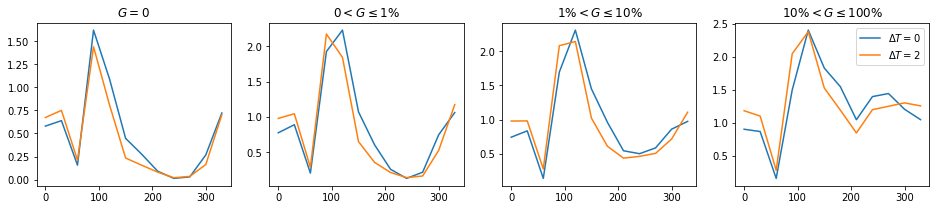

In [ ]:
#plot max_diff(t) for different background warming -- e.g. the capacity for heat waves to cause floods under different climates

nrows = 1
ncols = 4

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (4*ncols, 3*nrows))

for glacier_class, ax in enumerate(axes.flatten()):

  ax.plot(days_start, max_diffs_glacier_classes[glacier_class, 0,:], label = '$\Delta T = $' + str(T_background_anomalies[0]))
  ax.plot(days_start, max_diffs_glacier_classes[glacier_class, 1,:], label = '$\Delta T = $' + str(T_background_anomalies[1]))
  ax.set_title(glacier_classes_names[glacier_class])

ax.legend()

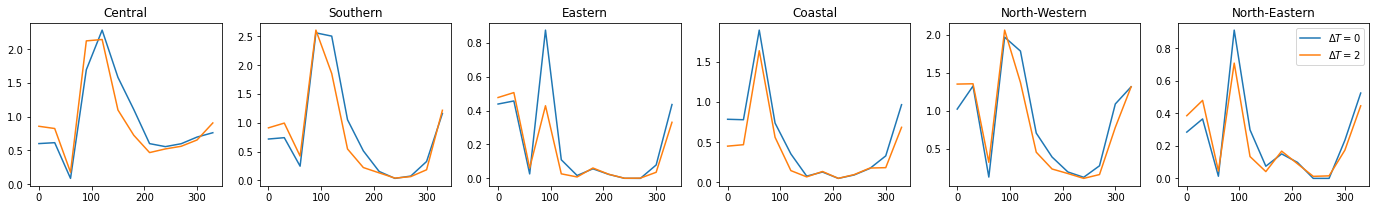

In [ ]:
#plot max_diff(t) for different background warming -- e.g. the capacity for heat waves to cause floods under different climates

nrows = 1
ncols = n_clusters_seasonal

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (4*ncols, 3*nrows))

for cluster, ax in enumerate(axes.flatten()):

  ax.plot(days_start, max_diffs_clusters[cluster, 0,:], label = '$\Delta T = $' + str(T_background_anomalies[0]))
  ax.plot(days_start, max_diffs_clusters[cluster, 1,:], label = '$\Delta T = $' + str(T_background_anomalies[1]))
  ax.set_title(cluster_names[cluster])
  
ax.legend()

No handles with labels found to put in legend.


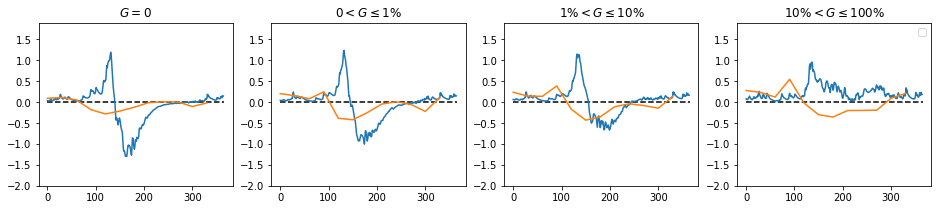

In [ ]:
#plot difference between background flows for different background warming -- e.g. the capacity for heat waves to cause floods under different climates

nrows = 1
ncols = 4

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (4*ncols, 3*nrows))

for glacier_class, ax in enumerate(axes.flatten()):

  inds = np.argwhere( (glacier_classes == glacier_class) & (NSE_fine > 0.7)).squeeze()
  x1 = np.mean(y_predict[:,inds,0] ,axis = 1)
  x2 = np.mean(y_predict[:,inds,1] ,axis = 1)
  x3 = x2 - x1

  x4 = max_diffs_glacier_classes[glacier_class, 0,:]
  x5 = max_diffs_glacier_classes[glacier_class, 1,:]
  x6 = x5 - x4

  # ax.plot(x1, label = '$\Delta T = $' + str(T_background_anomalies[0]))
  # ax.plot(x2, label = '$\Delta T = $' + str(T_background_anomalies[1]))
  ax.plot([0,365],[0,0], 'k--')
  ax.plot(x3)
  ax.plot(days_start, x6)
  ax.set_title(glacier_classes_names[glacier_class])

  ax.set_ylim(bottom = -2, top = 1.9)

ax.legend()

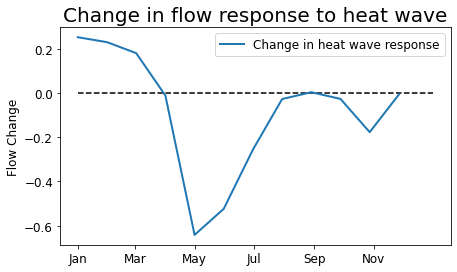

In [ ]:
#plot difference between background flows for different background warming -- e.g. the capacity for heat waves to cause floods under different climates

saveIt = 0

glacier_class = 0
NSE_threshold = 0.7

fig, ax = plt.subplots(figsize = (7,4))

inds = np.argwhere( (glacier_classes == glacier_class) & (NSE_fine > NSE_threshold)).squeeze()
x1 = np.mean(y_predict[:,inds,0] ,axis = 1)
x2 = np.mean(y_predict[:,inds,1] ,axis = 1)
x3 = x2 - x1

x4 = max_diffs_stations[inds, 0,:].mean(axis = 0)
x5 = max_diffs_stations[inds, 1,:].mean(axis = 0)
x6 = x5 - x4

ax.plot([0,365],[0,0], 'k--')
# ax.plot(x3, 'k', label = 'Change from warming climate')
ax.plot(days_start, x6, linewidth = 2, label = 'Change in heat wave response')
ax.set_title(glacier_classes_names[glacier_class])

# ax.set_ylim(bottom = -1.5, top = 1.3)

# ax.set_title('Flow Change By Driver', fontsize = 20)
ax.set_title('Change in flow response to heat wave', fontsize = 20)
ax.set_ylabel('Flow Change', fontsize = fs)
ax.set_xticks(first_days_of_month[::2])
ax.set_xticklabels(months_str[::2], rotation = 0, fontsize = 16)
ax.tick_params(labelsize = fs)
ax.legend(fontsize = 12)

if saveIt:
  plt.savefig('flow_change_by_driver0.png', dpi = 300, bbox_inches = 'tight')

plt.show()

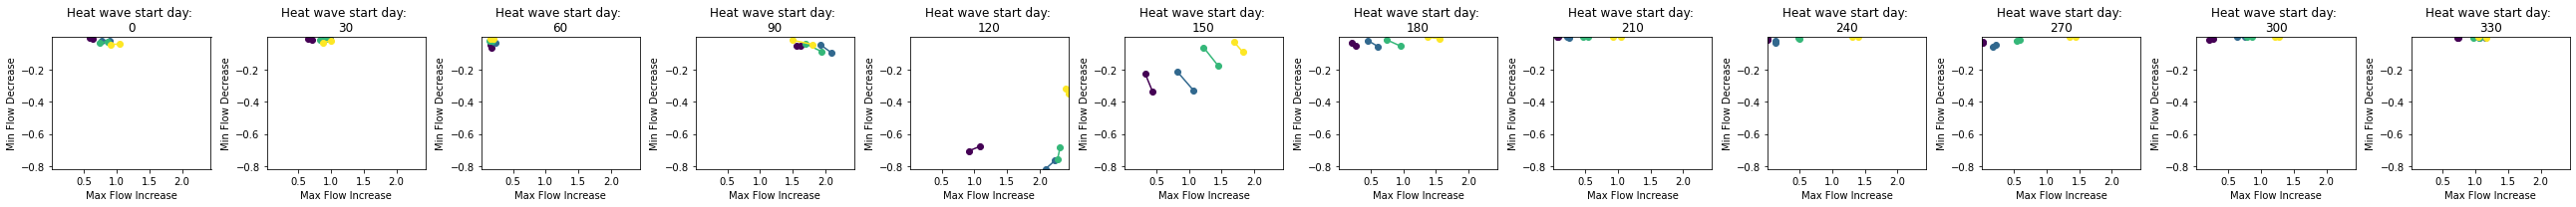

In [ ]:
cmap = cm.get_cmap('viridis')
norm = matplotlib.colors.Normalize(vmin = 0, vmax = 3)

nrows = 1
ncols = N_heat_waves
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (3*ncols, 3))

for ind_heat_wave, ax in enumerate(axes.flatten()):
  for glacier_class in range(N_glacier_classes):
    ax.plot(max_diffs_glacier_classes[glacier_class,:,ind_heat_wave], min_diffs_glacier_classes[glacier_class,:,ind_heat_wave], color = cmap(norm(glacier_class)), marker = 'o')
  ax.set_xlabel('Max Flow Increase')
  ax.set_ylabel('Min Flow Decrease')
  ax.set_title('Heat wave start day: \n' + str(days_start[ind_heat_wave]))
  ax.set_xlim(left = np.min(max_diffs_glacier_classes), right = np.max(max_diffs_glacier_classes))
  ax.set_ylim(bottom = np.min(min_diffs_glacier_classes), top = np.max(min_diffs_glacier_classes))

plt.tight_layout()
plt.show()

In [ ]:
hot_days_start

150

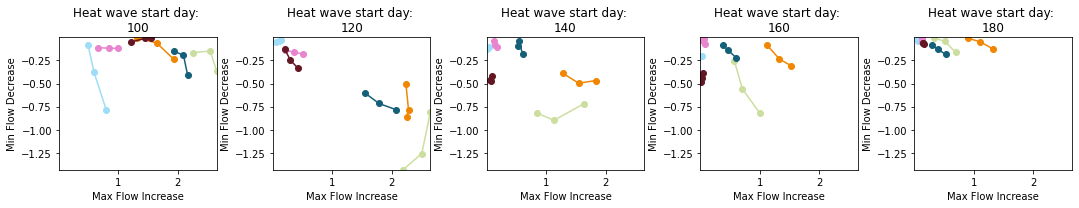

In [ ]:

nrows = 1
ncols = N_heat_waves
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (3*ncols, 3))

for ind_heat_wave, ax in enumerate(axes.flatten()):
  for cluster in range(n_clusters_seasonal):
    ax.plot(max_diffs_clusters[cluster,:,ind_heat_wave], min_diffs_clusters[cluster,:,ind_heat_wave], color = rgbas_array[cluster,:], marker = 'o')
  ax.set_xlabel('Max Flow Increase')
  ax.set_ylabel('Min Flow Decrease')
  ax.set_title('Heat wave start day: \n' + str(days_start[ind_heat_wave]))
  ax.set_xlim(left = np.min(max_diffs_clusters), right = np.max(max_diffs_clusters))
  ax.set_ylim(bottom = np.min(min_diffs_clusters), top = np.max(min_diffs_clusters))

plt.tight_layout()
plt.show()

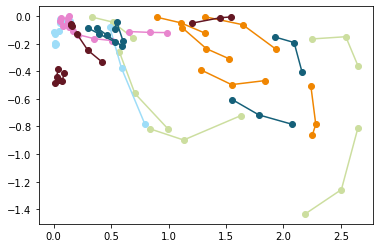

In [ ]:
cmap = cm.get_cmap('viridis')
norm = matplotlib.colors.Normalize(vmin = 0, vmax = 3)

fig, ax = plt.subplots()

for cluster in range(n_clusters_seasonal):

  ax.plot(max_diffs_clusters[cluster,:], min_diffs_clusters[cluster,:], color = rgbas_array[cluster,:], marker = 'o')


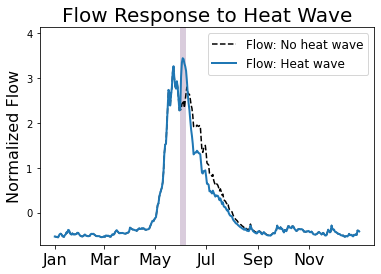

In [ ]:
saveIt = 1

glacier_class = 0
NSE_threshold = 0.7

inds = np.argwhere(
    (glacier_classes == glacier_class) & (NSE_fine > NSE_threshold)
).squeeze()

Nyears_plot = 1
Ndays_plot = Nyears_plot*365

x1 = np.mean(y_predict[:Ndays_plot, inds,0], axis = 1)
x2 = np.mean(y_predict_perturb[:Ndays_plot, inds,0,5], axis = 1)
f1 = x1.reshape(Nyears_plot,-1).mean(axis = 0)
f2 = x2.reshape(Nyears_plot,-1).mean(axis = 0)

top = np.max([f1,f2])*1.2
bottom = np.min([f1,f2])*1.3
extent_heat = [days_start[5], days_start[5]+7, bottom, top]

fig, ax = plt.subplots()
ax.imshow(heat_shade, extent = extent_heat, alpha = 0.2, aspect = 'auto', label = 'Heat wave')
ax.plot(f1,'k--', label = 'Flow: No heat wave')
ax.plot(f2, label = 'Flow: Heat wave', linewidth = 2)
ax.set_xticks(first_days_of_month[::2])
ax.set_xticklabels(months_str[::2], rotation = 0, fontsize = 16)
ax.set_ylabel('Normalized Flow', fontsize = 16)
ax.set_title('Flow Response to Heat Wave', fontsize = 20)
leg = ax.legend(fontsize = 12)

if saveIt:
  plt.savefig('no_glaciers_heat_wave.png', dpi = 300, bbox_inches = 'tight')

In [ ]:
np.shape(min_diffs_stations)

(226, 2, 12)

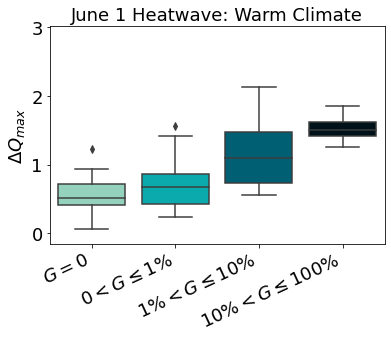

In [ ]:
#max diffs by glacier coverage (baseline and warm climate)

saveIt = 1

fs = 18

rgbs_glacier = np.array([
                      # [3, 4, 94],
                       [2, 62, 138],
                      [0, 119, 182],
                      [0, 180, 216],
                      [144, 224, 239]
]) / 256

rgbs_glacier = np.array([[148, 210, 189],
                         [11, 170, 173],
                         [0, 95, 115],
                         [0, 18, 25]]) / 255

fig, ax  = plt.subplots()

inds = np.argwhere(NSE_fine > 0.7).squeeze()

bp = sns.boxplot(x = glacier_classes[inds], y = max_diffs_stations[inds,1,5], ax = ax)
for kk in range(N_glacier_classes):
  # bp.artists[kk].set_facecolor(cmap(norm(kk)))
  bp.artists[kk].set_facecolor(rgbs_glacier[kk,:])

label_names = ['$G=0$', '$0<G\leq1\%$', '$1\%<G\leq10\%$', '$10\%<G\leq100\%$'] 
ax.set_xticklabels(label_names,rotation = 25, ha = 'right', fontsize = fs)
ax.set_ylabel('$\Delta Q_{max}$', fontsize = fs)
ax.set_title('June 1 Heatwave: Warm Climate', fontsize = fs)
ax.set_ylim(
    bottom = np.min([max_diffs_stations[inds,0,5],max_diffs_stations[inds,1,5]]) - 0.2,
    top = np.max([max_diffs_stations[inds,0,5],max_diffs_stations[inds,1,5]]) + 0.2
)
ax.tick_params(labelsize = fs)

if saveIt:
  plt.savefig('june1_warm_glacier_range.png', dpi = 300, bbox_inches = 'tight')

plt.show()


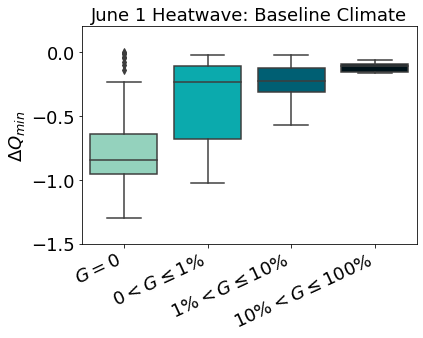

In [ ]:
#max diffs by glacier coverage (baseline and warm climate)

saveIt = 1

fs = 18

rgbs_glacier = np.array([
                      # [3, 4, 94],
                       [2, 62, 138],
                      [0, 119, 182],
                      [0, 180, 216],
                      [144, 224, 239]
]) / 256

rgbs_glacier = np.array([[148, 210, 189],
                         [11, 170, 173],
                         [0, 95, 115],
                         [0, 18, 25]]) / 255

fig, ax  = plt.subplots()

inds = np.argwhere(NSE_fine > 0.7).squeeze()

bp = sns.boxplot(x = glacier_classes[inds], y = min_diffs_stations[inds,0,5], ax = ax)
for kk in range(N_glacier_classes):
  # bp.artists[kk].set_facecolor(cmap(norm(kk)))
  bp.artists[kk].set_facecolor(rgbs_glacier[kk,:])

label_names = ['$G=0$', '$0<G\leq1\%$', '$1\%<G\leq10\%$', '$10\%<G\leq100\%$'] 
ax.set_xticklabels(label_names,rotation = 25, ha = 'right', fontsize = fs)
ax.set_ylabel('$\Delta Q_{min}$', fontsize = fs)
ax.set_title('June 1 Heatwave: Baseline Climate', fontsize = fs)
ax.set_ylim(
    bottom = np.min([min_diffs_stations[inds,0,5],min_diffs_stations[inds,1,5]]) - 0.2,
    top = np.max([min_diffs_stations[inds,0,5],min_diffs_stations[inds,1,5]]) + 0.2
)
ax.tick_params(labelsize = fs)

if saveIt:
  plt.savefig('june1_baseline_glacier_range_min.png', dpi = 300, bbox_inches = 'tight')

plt.show()

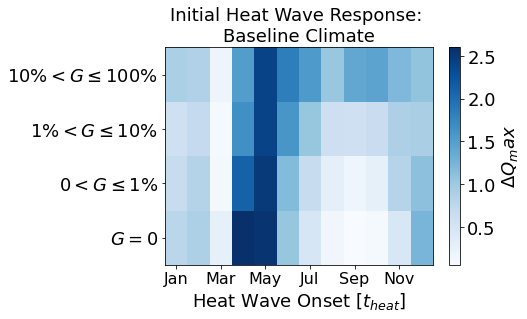

In [ ]:
saveIt = 1

var1 = np.zeros((4,12))
var2 = np.zeros((4,12))
for kk in range(4):
  inds = np.argwhere(
      (glacier_classes == kk) & (NSE_fine > 0.7)
  )
  var1[kk,:] = max_diffs_stations[inds,0,:].mean(axis = 0)
  var2[kk,:] = max_diffs_stations[inds,1,:].mean(axis = 0)

vmin = np.min([var1, var2])
vmax = np.max([var1, var2])

fig, ax = plt.subplots()

im = ax.imshow(var1, aspect = 'auto', vmin = vmin, vmax = vmax, cmap = 'Blues')
ax.invert_yaxis()
ax.set_xticks(np.arange(0,12,2))
ax.set_xticklabels(months_str[::2], rotation = 0, fontsize = 16)
ax.set_xlabel('Heat Wave Onset [$t_{heat}$]', fontsize = fs)

ax.set_yticks(np.arange(0,4))
ax.set_yticklabels(label_names, ha = 'right', fontsize = fs)

ax.set_title('Initial Heat Wave Response: \nBaseline Climate', fontsize = fs)

cb = plt.colorbar(im, ax = ax)
cb.set_label('$\Delta Q_max$', fontsize = fs)
cb.ax.tick_params(labelsize = fs)

if saveIt:
  plt.savefig('baseline_response_by_time_glaciers.png', dpi = 300, bbox_inches = 'tight')

In [ ]:
cb.ax.tick_params(labelsize = fs)

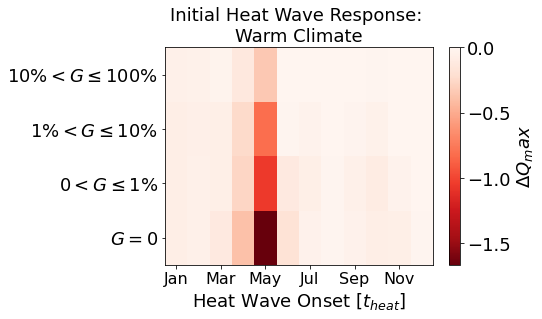

In [ ]:
saveIt = 1

var1 = np.zeros((4,12))
var2 = np.zeros((4,12))
for kk in range(4):
  inds = np.argwhere(
      (glacier_classes == kk) & (NSE_fine > 0.7)
  )
  var1[kk,:] = min_diffs_stations[inds,0,:].mean(axis = 0)
  var2[kk,:] = min_diffs_stations[inds,1,:].mean(axis = 0)

vmin = np.min([var1, var2])
vmax = np.max([var1, var2])

fig, ax = plt.subplots()

im = ax.imshow(var2, aspect = 'auto', vmin = vmin, vmax = 0, cmap = 'Reds_r')

ax.invert_yaxis()
ax.set_xticks(np.arange(0,12,2))
ax.set_xticklabels(months_str[::2], rotation = 0, fontsize = 16)
ax.set_xlabel('Heat Wave Onset [$t_{heat}$]', fontsize = fs)

ax.set_yticks(np.arange(0,4))
ax.set_yticklabels(label_names, ha = 'right', fontsize = fs)

ax.set_title('Initial Heat Wave Response: \nWarm Climate', fontsize = fs)

cb = plt.colorbar(im, ax = ax)
cb.set_label('$\Delta Q_max$', fontsize = fs)
cb.ax.tick_params(labelsize = fs)

if saveIt:
  plt.savefig('warm_later_response_by_time_glaciers.png', dpi = 300, bbox_inches = 'tight')